# Physiological data preprocessing

## Packages and imports

In [ ]:
!pip install neurokit2
!pip install pingouin
!pip install heartpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.5 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import neurokit2 as nk
import numpy as np
from datetime import datetime
import glob
import pingouin as pg
import heartpy as hp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Preprocess Raw data

In [ ]:
df.columns

Index(['Row', 'Timestamp', 'EventSource', 'SlideEvent', 'StimType', 'Duration',
       'CollectionPhase', 'SourceStimuliName', 'EventSource.1', 'SampleNumber',
       'Timestamp RAW', 'Timestamp CAL', 'System Timestamp CAL',
       'Internal ADC A13 PPG CAL', 'GSR RAW', 'GSR Resistance CAL',
       'GSR Conductance CAL', 'Heart Rate PPG ALG', 'IBI PPG ALG',
       'Packet reception rate RAW', 'N_Video active on Qualtrics-1',
       'P_Video active on Qualtrics-1', 'Without Error active on Qualtrics-1',
       'With Error active on Qualtrics-1',
       'RiskManipulation active on Qualtrics-1',
       'Qualtrics-1_QID1319131661 active on Qualtrics-1',
       'Qualtrics-1_QID1319131701 active on Qualtrics-1',
       'Qualtrics-1_QID1319131709 active on Qualtrics-1',
       'Qualtrics-1_QID1319131710 active on Qualtrics-1',
       'Qualtrics-1_QID1319131713 active on Qualtrics-1',
       'Qualtrics-1_QID1319131717 active on Qualtrics-1',
       'Qualtrics-1_QID1319131718 active on Qualtric

In [ ]:
# this function is responsible for column name consistency
def rename_columns(df):
  new_columns = []
  for column in df.columns:
    if ' active on Qualtrics-1' in column:
      new_columns.append(column.replace(' active on Qualtrics-1', ''))
    elif ' active' in column:
      new_columns.append(column.replace(' active', ''))
    else:
      new_columns.append(column)
  df.columns = new_columns
  return df





In [ ]:
#  this function includes necessary cleaning and additional modifications to create neccesary columns
def cleanData(df):

  # Remove rows where both 'With Error active' and 'Without Error active' are null
  df = rename_columns(df)
  print(df.shape)
  df = df.dropna(subset=['With Error', 'Without Error'], how='all')
  df = df.dropna(subset=['P_Video','N_Video'],how='all')
  print(df.shape)
  # df = df.dropna(subset=['N_Video'],inplace=True)


  df = df[df['GSR Conductance CAL'].notna()]
  # df = df[df['P_Video'].notna()]
  # df = df[df['N_Video'].notna()]
   #clean the HR data from noise
  #df = df[(df['Heart Rate PPG ALG'] != -1) & (df['Heart Rate PPG ALG'] <= 160)]
  df['Heart Rate PPG ALG_int'] = df['Heart Rate PPG ALG'].copy()
  df.loc[df['Heart Rate PPG ALG'] == -1, 'Heart Rate PPG ALG_int'] = np.nan
  df.loc[df['Heart Rate PPG ALG'] < 40, 'Heart Rate PPG ALG_int'] = np.nan
  df.loc[df['Heart Rate PPG ALG'] > 140, 'Heart Rate PPG ALG_int'] = np.nan

  df['Heart Rate PPG ALG_int'] = df['Heart Rate PPG ALG_int'].interpolate(method ='linear', limit_direction ='forward')

  # Smooth with moving average
  df['Heart Rate_mean'] = df['Heart Rate PPG ALG_int'].rolling(window=640).mean().bfill()
  df['Heart Rate_max'] = df['Heart Rate PPG ALG_int'].rolling(window=640).max().bfill()
  df['Heart Rate_min'] = df['Heart Rate PPG ALG_int'].rolling(window=640).min().bfill()
  df['Heart Rate_std'] = df['Heart Rate PPG ALG_int'].rolling(window=640).std().bfill()
  df['N_Video'] = df['N_Video'].fillna(3)
  df['P_Video'] = df['P_Video'].fillna(3)
  # df['Automation Error'] = np.where(df['With Error'] == 1, 'With Error', 'Without Error')
  df['Automation Error'] = np.where(df['P_Video'] == 1,  'Without Error','With Error')
  # df = df[::16] # downsample data




  # get date and time as features from UNIX timestamp
  timestamp = df.loc[:,'System Timestamp CAL'].astype(int)
  df['datetime'] = pd.to_datetime(timestamp, origin='unix',unit='ms',utc=True).map(lambda x: x.tz_convert('America/Detroit'))

  # df = df.set_index('datetime')
  # df = df.resample('s').mean()
  # df = df.reset_index()
  # print(df.shape)

  df['Date'] = df['datetime'].astype(str).str.split(' ', expand=True)[0]
  df['Time'] = df['datetime'].astype(str).str.split(' ', expand=True)[1]

  #add resampling
  #print(df.isna().sum())




  return df




In [ ]:
# link to the folder where the gsr folders are located
#root_directory = "/content/drive/MyDrive/EMOTION_TRUST_STUDY/Initial_DATA/Sensor_Data_New" # for Em
root_directory = "/content/drive/MyDrive/Emotion_Em/Sensor Data_New" # for Lily

In [ ]:
subfolders = [f.path for f in os.scandir(root_directory) if f.is_dir()]
#subfolders[0]

In [ ]:
data_row = 26df.columns

Index(['Row', 'Timestamp', 'EventSource', 'SlideEvent', 'StimType', 'Duration',
       'CollectionPhase', 'SourceStimuliName', 'EventSource.1', 'SampleNumber',
       'Timestamp RAW', 'Timestamp CAL', 'System Timestamp CAL',
       'Internal ADC A13 PPG CAL', 'GSR RAW', 'GSR Resistance CAL',
       'GSR Conductance CAL', 'Heart Rate PPG ALG', 'IBI PPG ALG',
       'Packet reception rate RAW', 'N_Video', 'P_Video', 'Without Error',
       'With Error', 'RiskManipulation', 'Qualtrics-1_QID1319131661',
       'Qualtrics-1_QID1319131701', 'Qualtrics-1_QID1319131709',
       'Qualtrics-1_QID1319131710', 'Qualtrics-1_QID1319131713',
       'Qualtrics-1_QID1319131717', 'Qualtrics-1_QID1319131718',
       'Qualtrics-1_QID1319131714', 'Qualtrics-1_QID1319131715',
       'Qualtrics-1_QID1319131716', 'Qualtrics-1_QID1319131723',
       'Qualtrics-1_QID1319131724', 'Qualtrics-1_QID1319131700',
       'Heart Rate PPG ALG_int', 'Heart Rate_mean', 'Heart Rate_max',
       'Heart Rate_min', 'Heart Rat

In [ ]:
data_row = 26
df = pd.read_csv("/content/drive/MyDrive/Emotion_Em/Sensor Data_New/HR 1/003_PT 13.csv",skiprows=data_row, header=0,low_memory=False)
x = cleanData(df)
x

<ipython-input-5-2d2493d764f4>:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Heart Rate_mean'] = df['Heart Rate PPG ALG_int'].rolling(window=640).mean().fillna(method='bfill')
<ipython-input-5-2d2493d764f4>:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Heart Rate_max'] = df['Heart Rate PPG ALG_int'].rolling(window=640).max().fillna(method='bfill')
<ipython-input-5-2d2493d764f4>:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Heart Rate_min'] = df['Heart Rate PPG ALG_int'].rolling(window=640).min().fillna(method='bfill')
<ipython-input-5-2d2493d764f4>:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Heart Rate_

Row  Timestamp  EventSource SlideEvent StimType  Duration  \
73021    73022     285265          NaN        NaN      NaN       NaN   
73022    73023     285269          NaN        NaN      NaN       NaN   
73023    73024     285273          NaN        NaN      NaN       NaN   
73024    73025     285277          NaN        NaN      NaN       NaN   
73025    73026     285281          NaN        NaN      NaN       NaN   
...        ...        ...          ...        ...      ...       ...   
547254  547255    2137745          NaN        NaN      NaN       NaN   
547255  547256    2137749          NaN        NaN      NaN       NaN   
547256  547257    2137753          NaN        NaN      NaN       NaN   
547257  547258    2137757          NaN        NaN      NaN       NaN   
547258  547259    2137761          NaN        NaN      NaN       NaN   

       CollectionPhase SourceStimuliName  EventSource.1  SampleNumber  ...  \
73021              NaN               NaN            1.0      143804.0  ...   
73022              NaN               NaN            1.0      143805.0  ...   
73023              NaN               NaN            1.0      143806.0  ...   
73024              NaN               NaN            1.0      143807.0  ...   
73025              NaN               NaN            1.0      143808.0  ...   
...                ...               ...            ...           ...  ...   
547254             NaN               NaN            1.0      618039.0  ...   
547255             NaN               NaN            1.0      618040.0  ...   
547256             NaN               NaN            1.0      618041.0  ...   
547257             NaN               NaN            1.0      618042.0  ...   
547258             NaN               NaN            1.0      618043.0  ...   

        Qualtrics-1_QID1319131700  Heart Rate PPG ALG_int  Heart Rate_mean  \
73021                         NaN                    82.0        83.493750   
73022                         NaN                    82.0        83.493750   
73023                         NaN                    82.0        83.493750   
73024                         NaN                    82.0        83.493750   
73025                         NaN                    82.0        83.493750   
...                           ...                     ...              ...   
547254                        NaN                    86.0        85.921875   
547255                        NaN                    86.0        85.926563   
547256                        NaN                    86.0        85.931250   
547257                        NaN                    86.0        85.935937   
547258                        NaN                    86.0        85.940625   

        Heart Rate_max  Heart Rate_min  Heart Rate_std  Automation Error  \
73021             87.0            82.0        1.161440     Without Error   
73022             87.0            82.0        1.161440     Without Error   
73023             87.0            82.0        1.161440     Without Error   
73024             87.0            82.0        1.161440     Without Error   
73025             87.0            82.0        1.161440     Without Error   
...                ...             ...             ...               ...   
547254            88.0            83.0        1.699716        With Error   
547255            88.0            83.0        1.695778        With Error   
547256            88.0            83.0        1.691817        With Error   
547257            88.0            83.0        1.687834        With Error   
547258            88.0            83.0        1.683829        With Error   

                               datetime        Date                   Time  
73021  2024-05-29 16:09:24.392000-04:00  2024-05-29  16:09:24.392000-04:00  
73022  2024-05-29 16:09:24.396000-04:00  2024-05-29  16:09:24.396000-04:00  
73023  2024-05-29 16:09:24.400000-04:00  2024-05-29  16:09:24.400000-04:00  
73024  2024-05-29 16:09:24.404000-04:00  2024-05-29

In [ ]:

# List all subfolders
subfolders = [f.path for f in os.scandir(root_directory) if f.is_dir()]
#subfolders = subfolders[0]

# Loop over each subfolder and list files within them
for subfolder in subfolders:
    print(f'Found subfolder: {subfolder}')
    # print(subdir.lower().find("/nof "))
    # if subdir.lower().find("nof ") == -1:
    #   continue
    for subdir, dirs, files in os.walk(subfolder):
        # Get all CSV files in the specified folder
       # filepath = '/content/drive/MyDrive/Emotion_Em/Sensor Data_New/Control 1'
       # files = glob.glob(os.path.join(subfolder, "*.csv"))
        for file in files:
            print(f'\tFile: {file}')
            data_row = 26
            # try:
            filepath = subdir+'/'+file
            df = pd.read_csv(filepath,skiprows=data_row, header=0,low_memory=False) # skiprows=28, header=0) - for main sensor data or 13 or 0
            #df = df[df['GSR RAW'].notna()]
            #print("df is defined")

            df = cleanData(df)
            print("cleaned")
            # df.dropna(inplace=True)
            # print(df.head(30))

            risk_group = (subdir.split('/')[-1]).split(' ')[0]
            id = (file.split(' ')[-1]).split('.')[0]


          # df[df['GSR RAW'] == Null].dropna(inplace=True)
            try:
              x = df.loc[:,['System Timestamp CAL','Timestamp RAW','Date','Time','Automation Error', 'GSR Conductance CAL','Heart Rate PPG ALG','Heart Rate PPG ALG_int','Heart Rate_mean','Heart Rate_max','Heart Rate_min','Heart Rate_std','IBI PPG ALG','Internal ADC A13 PPG CAL','N_Video','P_Video']]#, 'Qualtrics-1_QID1319131713','Qualtrics-1_QID1319131716']]
              # x = df.loc[:,['System Timestamp CAL','Timestamp RAW','Date','Time','N_Video active','N_Video instance', 'P_Video active', 'P_Video instance','Qualtrics-1_QID1319131713 active on Qualtrics-1','Qualtrics-1_QID1319131716 active on Qualtrics-1',
              #             'Heart Rate PPG ALG','IBI PPG ALG']] # initial select
            except:
              try:
                x = df.loc[:,['System Timestamp CAL','Timestamp RAW','Date','Time','Heart Rate PPG ALG','Heart Rate PPG ALG_int','Heart Rate_mean','Heart Rate_max','Heart Rate_min','Heart Rate_std','IBI PPG ALG','Internal ADC A13 PPG CAL','N_Video active','P_Video active']]
                print(f'in \tFile: {file} . Missing Quatrics')

              except:
                 x = df.loc[:,['System Timestamp CAL','Timestamp RAW','Date','Time','Heart Rate PPG ALG','Heart Rate PPG ALG_int','Heart Rate_mean','Heart Rate_max','Heart Rate_min','Heart Rate_std','IBI PPG ALG','Internal ADC A13 PPG CAL']]
                 print(f'Error in \tFile: {file} . Missing Annotations and qualtrics')

           # x.dropna(inplace=True)

            x['Risk Perception'] = risk_group
            x['ID'] = id


            data = x.loc[:,'GSR Conductance CAL']

            print(data.shape)

            # Preprocess the data (filter, find peaks, etc.)
            processed_data, info = nk.eda_process(data, sampling_rate=128) # sampling_rate=128


            # Compute relevant features
            results = nk.eda_analyze(processed_data, sampling_rate=16) # sampling_rate=128
          # print(processed_data)
            phasic = pd.DataFrame(processed_data)
            scaler = MinMaxScaler()
            phasic['EDA_Tonic_norm'] = scaler.fit_transform(phasic[['EDA_Tonic']])
            phasic['EDA_Phasic_norm'] = scaler.fit_transform(phasic[['EDA_Phasic']])


            x.reset_index(inplace=True,drop=True)
            phasic.reset_index(inplace=True,drop=True)
            print(x.shape)
            print(phasic.shape)
            final = pd.concat([x,phasic],axis=1)


            # print(final.isna().sum())
            final.dropna(inplace=True)
            final = final[::16] # downsample data
            # df_downsampled = final.resample('1S').mean()
            print(final.shape)

            filename = (file.split('_')[1])#.split('.')[0] # remove numbers at the begining of the file name
            final.to_csv('/content/drive/MyDrive/Emotion_Em/Physiological data/16hz_normalized/'+filename)



Found subfolder: /content/drive/MyDrive/Emotion_Em/Sensor Data_New/HR 1
	File: 001_PT 1.csv
(544089, 38)
(423924, 38)
cleaned
(423924,)
(423924, 18)
(423924, 13)
(26496, 31)
	File: 002_PT 5.csv
(538132, 38)
(421608, 38)
cleaned
(421608,)
(421608, 18)
(421608, 13)
(26350, 31)
	File: 003_PT 13.csv
(592619, 38)
(423438, 38)
cleaned
(423438,)
(423438, 18)
(423438, 13)
(26465, 31)
	File: 004_PT 21.csv
(561221, 38)
(422746, 38)
cleaned
(422746,)
(422746, 18)
(422746, 13)
(25748, 31)
	File: 005_PT 24.csv
(571225, 38)
(425323, 38)
cleaned
(425323,)
(425323, 18)
(425323, 13)
(26583, 31)
	File: 006_PT 31.csv
(606170, 38)
(420621, 38)
cleaned
(420621,)
(420621, 18)
(420621, 13)
(26289, 31)
	File: 007_PT 39.csv
(668184, 38)
(423915, 38)
cleaned
(423915,)
(423915, 18)
(423915, 13)
(26495, 31)
	File: 008_PT 43.csv
(551075, 38)
(366338, 38)
cleaned
(366338,)
(366338, 18)
(366338, 13)
(22536, 31)
	File: 009_PT 49.csv
(672703, 38)
(422887, 38)
cleaned
(422887,)
(422887, 18)
(422887, 13)
(26431, 31)
	Fi

In [ ]:
# Define HRV calcuation function
import numpy as np

def calculate_hrv(ibi_values):
    """
    Calculate Heart Rate Variability (HRV) from a list of interbeat interval (IBI) values.

    Args:
        ibi_values (list): A list of interbeat interval values in milliseconds.

    Returns:
        float: The Root Mean Square of Successive Differences (RMSSD) of the IBI values.
    """
    # Calculate the differences between successive IBI values
    diffs = np.diff(ibi_values)
    print(diffs)

    # Calculate the square of the differences
    squared_diffs = diffs ** 2
    #print(squared_diffs)

    # Calculate the mean of the squared differences
    mean_squared_diffs = np.mean(squared_diffs)

    # Calculate the RMSSD (square root of the mean of the squared differences)
    rmssd = np.sqrt(mean_squared_diffs)

    return rmssd

In [ ]:
# Calculate the HRV from data
ibi_values = df[df['IBI PPG ALG'] != -1]['IBI PPG ALG']
hrv = calculate_hrv(ibi_values)
print(f"Heart Rate Variability (RMSSD): {hrv:.2f} ms")
hrv

[  11.71875   -7.8125   136.71875   39.0625  -132.8125   101.5625
  -46.875     89.84375 -187.5      132.8125   -27.34375  -15.625
   62.5     -179.6875   140.625     15.625     31.25    -105.46875
  -62.5      203.125   -132.8125   -58.59375   89.84375 -101.5625
  -42.96875   15.625     50.78125   -3.90625  -39.0625   -50.78125
  -93.75     148.4375   148.4375    27.34375 -156.25     -85.9375
   93.75     -42.96875  -31.25     156.25     -93.75      39.0625
 -125.        42.96875  128.90625  -46.875    -23.4375    70.3125
  -70.3125   105.46875 -132.8125    42.96875   82.03125  -93.75
   93.75    -296.875    -11.71875  203.125     74.21875   39.0625
   -7.8125  -156.25     109.375    -89.84375 -218.75      82.03125
   93.75     121.09375 -101.5625   -15.625    -15.625    207.03125
 -113.28125 -105.46875   31.25     -27.34375  175.78125  -89.84375
  -82.03125  117.1875   -62.5       15.625     -7.8125  -226.5625
   89.84375  164.0625  -132.8125    97.65625   46.875    -70.3125
   -7.81

107.57064654401141

In [ ]:
# GSR(EDA) ref https://neuropsychology.github.io/NeuroKit/examples/eda_peaks/eda_peaks.html
# PPG analysis ref https://github.com/paulvangentcom/heartrate_analysis_python/blob/master/examples/1_regular_PPG/Analysing_a_PPG_signal.ipynb
  # https://python-heart-rate-analysis-toolkit.readthedocs.io/en/latest/

'PT 25.csv'

## Merging all participants data

In [ ]:
final.columns

Index(['System Timestamp CAL', 'Timestamp RAW', 'Date', 'Time',
       'Automation Error', 'GSR Conductance CAL', 'Heart Rate PPG ALG',
       'Heart Rate PPG ALG_int', 'Heart Rate_mean', 'Heart Rate_max',
       'Heart Rate_min', 'Heart Rate_std', 'IBI PPG ALG',
       'Internal ADC A13 PPG CAL', 'With Error', 'Without Error', 'N_Video',
       'P_Video', 'Risk Perception', 'ID', 'EDA_Raw', 'EDA_Clean', 'EDA_Tonic',
       'EDA_Phasic', 'SCR_Onsets', 'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude',
       'SCR_RiseTime', 'SCR_Recovery', 'SCR_RecoveryTime'],
      dtype='object')

In [ ]:
folder_path = "/content/drive/MyDrive/Emotion_Em/Physiological data/16hz_normalized"
output_file = "/content/drive/MyDrive/Emotion_Em/Results/Datasets/physiologicalData_norm_Nov8.csv"
combined_df = pd.DataFrame()

In [ ]:
  import glob
  # Get all CSV files in the specified folder

  csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
  print(len(csv_files))
  # Check if there are any CSV files
  if not csv_files:
      print("No CSV files found in the specified folder.")

  # List to store individual DataFrames
  df_list = []

  # Read each CSV file and append to the list
  for file in csv_files:
      df = pd.read_csv(file)
      df = df[['Risk Perception', 'Automation Error','ID','System Timestamp CAL','Timestamp RAW', 'Date', 'Time','EDA_Raw', 'Heart Rate PPG ALG',
       'Heart Rate PPG ALG_int', 'Heart Rate_mean', 'Heart Rate_max',
       'Heart Rate_min', 'Heart Rate_std', 'IBI PPG ALG','EDA_Clean', 'EDA_Tonic','EDA_Tonic_norm','EDA_Phasic','EDA_Phasic_norm',
       'N_Video', 'P_Video','SCR_Onsets', 'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude','SCR_RiseTime', 'SCR_Recovery', 'SCR_RecoveryTime']]
      df_list.append(df)

  # Concatenate all DataFrames in the list
  combined_df = pd.concat(df_list, ignore_index=True)

  combined_df.rename(columns={'Heart Rate PPG ALG':'Heart Rate_raw'},inplace=True)
  combined_df.rename(columns={'Heart Rate PPG ALG_int':'Heart Rate_cleaned'},inplace=True)
  combined_df['Record Number'] = combined_df.groupby(['ID', 'Risk Perception', 'Automation Error']).cumcount() + 1
  # Write the combined DataFrame to a new CSV file

  combined_df.to_csv(output_file, index=False)
  print(f"All CSV files have been appended to {output_file}")

70
All CSV files have been appended to /content/drive/MyDrive/Emotion_Em/Results/Datasets/physiologicalData_norm_Nov8.csv


In [ ]:
df.columns

Index(['Unnamed: 0', 'System Timestamp CAL', 'Timestamp RAW', 'Date', 'Time',
       'Automation error', 'GSR Conductance CAL', 'Heart Rate PPG ALG',
       'IBI PPG ALG', 'With Error', 'Without Error', 'N_Video', 'P_Video',
       'Qualtrics-1_QID1319131713', 'Qualtrics-1_QID1319131716',
       'Risk Perception', 'ID', 'EDA_Raw', 'EDA_Clean', 'EDA_Tonic',
       'EDA_Phasic', 'SCR_Onsets', 'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude',
       'SCR_RiseTime', 'SCR_Recovery', 'SCR_RecoveryTime'],
      dtype='object')

In [ ]:
combined_df.ID.unique()

array([21, 24, 31, 39, 43, 49, 61, 67, 73,  2,  8, 14, 20, 25, 34, 40, 44,
       50, 62, 68,  3,  9, 12, 18, 26, 29, 32, 45, 51, 63, 69,  4, 10, 16,
       22, 35, 36, 38, 46, 52, 64, 70,  6, 11, 17, 23, 33, 37, 41, 47, 53,
       59, 65, 71,  7, 15, 19, 27, 28, 30, 42, 48, 54, 60, 66, 72])

In [ ]:
combined_df['Risk Perception'].unique()

array(['HR', 'LR', 'Control'], dtype=object)

In [ ]:
#combined_df.rename(columns={'Automation error':'Automation Error'},inplace=True)
combined_df.rename(columns={'Heart Rate PPG ALG':'Heart Rate_raw'},inplace=True)
combined_df.rename(columns={'Heart Rate PPG ALG_int':'Heart Rate_cleaned'},inplace=True)

In [ ]:
combined_df.to_csv(output_file, index=False)

In [ ]:
# df.rename(columns={'Automation error':'Automation Error'},inplace=True)
# df.rename(columns={'Heart Rate PPG ALG':'Heart Rate'},inplace=True)

In [ ]:
 working_data, measures = hp.process(df['IBI PPG ALG'], 128.0,windowsize=5)

In [ ]:
print(measures['bpm']) #returns BPM value
print(measures['rmssd']) # returns RMSSD HRV measure

53.21016166281755
78.125


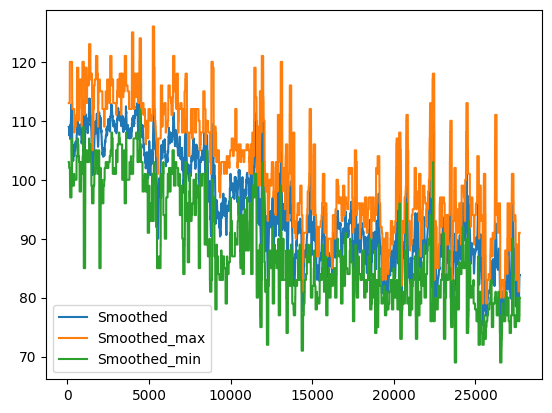

In [ ]:

import numpy as np
# Apply high and low value filters
df['Heart Rate_Filtered'] = df['Heart Rate']
df.loc[df['Heart Rate'] < 40, 'Heart Rate_Filtered'] = np.nan  # Example: Filter out values below 40
df.loc[df['Heart Rate'] > 140, 'Heart Rate_Filtered'] = np.nan  # Example: Filter out values above 160


# Smooth with moving average
df['Heart Rate_Smoothed'] = df['Heart Rate_Filtered'].rolling(window=80).mean()
df['Heart Rate_Smoothed_max'] = df['Heart Rate_Filtered'].rolling(window=80).max()
df['Heart Rate_Smoothed_min'] = df['Heart Rate_Filtered'].rolling(window=80).min()
df['Heart Rate_Smoothed_std'] = df['Heart Rate_Filtered'].rolling(window=80).std()


# Optional: Plot the results
import matplotlib.pyplot as plt

#plt.plot(df['Heart Rate'], label='Original')
# plt.plot(df['Heart Rate_Filtered'], label='Filtered')
plt.plot(df['Heart Rate_Smoothed'], label='Smoothed')
plt.plot(df['Heart Rate_Smoothed_max'], label='Smoothed_max')
plt.plot(df['Heart Rate_Smoothed_min'], label='Smoothed_min')



plt.legend()
plt.show()


## Plots

In [ ]:
#------- No need to run this-------
# # Read the file in chunks of 1000 rows
# for chunk in pd.read_csv("/content/drive/MyDrive/Emotion_Em/Results/Datasets/physiologicalData_33-end.csv", chunksize=100000):
#   # Process each chunk
#   df_new = pd.concat([df_new, chunk])

#   print(chunk.head(3))

In [ ]:
#df = pd.read_csv("/content/drive/MyDrive/Emotion_Em/Results/Datasets/physiologicalDataAll.csv")
df = combined_df.copy()

In [ ]:
df.shape

(1754410, 21)

In [ ]:

#df['ID'] = df['ID'].replace({'005_PT2': 2, '004_PT8': 8,'004_PT5':5,'005_PT1':1,'004_PT5':5})

# df['ID'] = df['ID'].astype(int)
# df['Time'] = pd.to_datetime(df['Time'])

# df.fillna(0,inplace=True)
# df.to_csv('/content/drive/MyDrive/Emotion_Em/Results/Datasets/physiologicalData_33-_downsampled.csv',index=False)

df.ID.unique()

array([ 5, 13, 21, 24, 31, 39, 43, 49, 55, 61, 67, 73,  2,  8, 14, 20, 25,
       34, 40, 44, 50, 62, 68,  1,  3,  9, 12, 18, 26, 29, 32, 45, 51, 63,
       69,  4, 10, 16, 22, 35, 36, 38, 46, 52, 64, 70,  7, 15, 19, 27, 28,
       30, 42, 48, 54, 60, 66, 72, 23, 71, 11,  6, 17, 33, 37, 41, 47, 53,
       59, 65])

In [ ]:
df1 = df[df['ID'] == 4]

NameError: name 'df' is not defined

In [ ]:
# Process the raw EDA signal
signals, info = nk.eda_process(df1.EDA_Raw, sampling_rate=128)

In [ ]:
import matplotlib.pyplot as plt

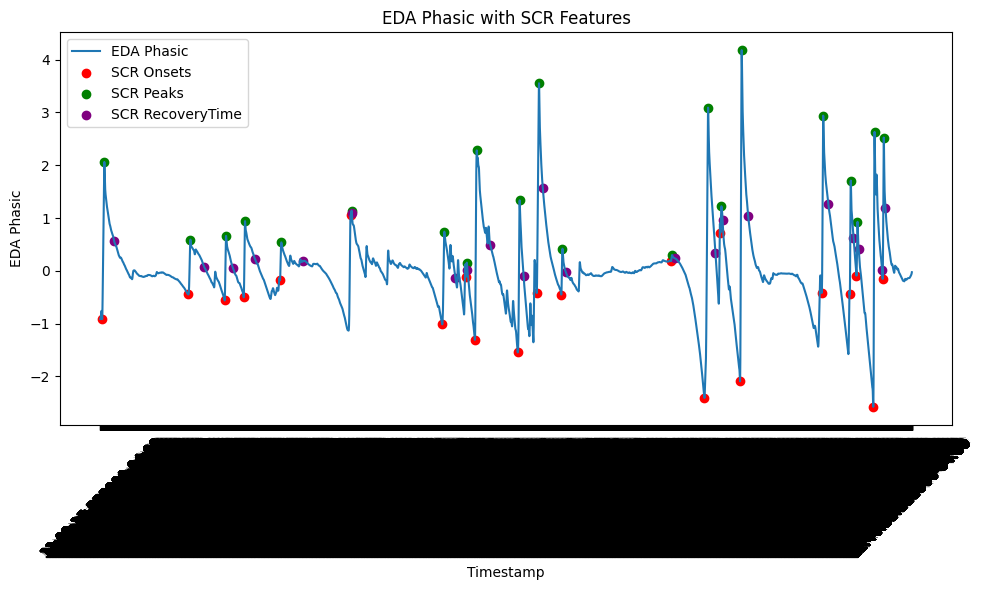

In [ ]:



# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot EDA_Phasic
ax.plot(df1['Time'], df1['EDA_Phasic'], label='EDA Phasic')


# Scatter plot for SCR_Onsets
ax.scatter(df1['Time'][df1['SCR_Onsets'] == 1], df1['EDA_Phasic'][df1['SCR_Onsets'] == 1], color='red', label='SCR Onsets')

# Scatter plot for SCR_Peaks
ax.scatter(df1['Time'][df1['SCR_Peaks'] == 1], df1['EDA_Phasic'][df1['SCR_Peaks'] == 1], color='green', label='SCR Peaks')

# # Scatter plot for SCR_RecoveryTime
# ax.scatter(df1['Time'][df1['SCR_RecoveryTime'] != 0], df1['EDA_Phasic'][df1['SCR_RecoveryTime'] != 0], color='purple', label='SCR RecoveryTime')

# Set labels and title
ax.set_xlabel('Timestamp')
ax.set_ylabel('EDA Phasic')
ax.set_title('EDA Phasic with SCR Features')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Add legend
ax.legend()

# Show the plot
plt.show()

In [ ]:
# plot EDA features over time for every ID

import matplotlib.pyplot as plt


# Group data by ID
grouped_data = df.groupby('ID')

# Loop through each group (ID)
for id, group in grouped_data:
  # Create a figure and axes
  fig, ax = plt.subplots(figsize=(10, 6))

  # Plot EDA features over time
  ax.plot(group['Timestamp RAW'], group['EDA_Phasic'], label='EDA Phasic')
  ax.plot(group['Timestamp RAW'], group['EDA_Tonic'], label='EDA Tonic')
  ax.plot(group['Timestamp RAW'], group['EDA_Raw'], label='EDA Raw')

  # Set labels and title
  ax.set_xlabel('')
  ax.set_ylabel('EDA')
  ax.set_title(f'EDA Features for ID: {id}')

  # Add legend
  ax.legend()

  # Show the plot
  plt.show()


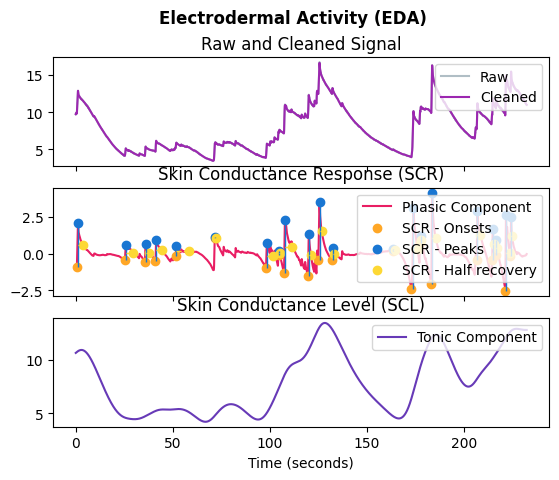

In [ ]:
# Plot EDA signal
plot = nk.eda_plot(signals,info=info)

In [ ]:
# signals = df1[['EDA_Clean', 'EDA_Tonic', 'EDA_Phasic']]
# info = df1[['SCR_Onsets', 'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude','SCR_RiseTime', 'SCR_Recovery', 'SCR_RecoveryTime']]

In [ ]:
# Extract clean EDA and SCR features
cleaned = signals["EDA_Clean"]
features = [info["SCR_Onsets"], info["SCR_Peaks"], info["SCR_Recovery"]]

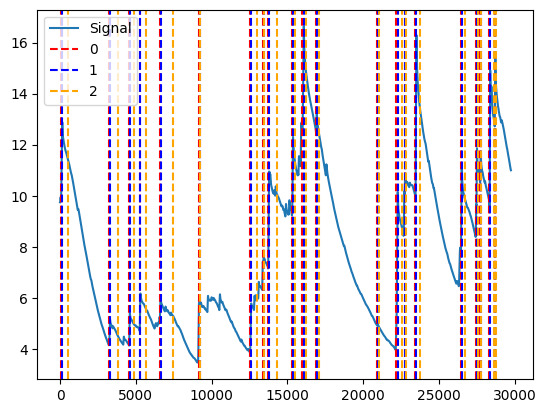

In [ ]:
# Visualize SCR features in cleaned EDA signal
plot = nk.events_plot(features, cleaned, color=['red', 'blue','orange'])


In [ ]:
df1.fillna(0,inplace=True)

<ipython-input-123-c4abd2bce96d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.fillna(0,inplace=True)


In [ ]:

def convert_time_format(time_str):
  """
  Converts a time string in the format 'HH:MM:SS.ffffff-TZ' to 'HH:MM:SS.fff'

  Args:
    time_str: The input time string.

  Returns:
    The converted time string.
  """
  try:
    return time_str.split('-')[0][:-3]
  except:
    return time_str

# Example usage:
time_str = "'11:35:47.973000-04:00'"
converted_time = convert_time_format(time_str)
print(converted_time)


'11:35:47.973


In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))


# Plot EDA_Phasic on the first y-axis
ax1.plot(df1['Time'], df1['EDA_Phasic'], color='blue', label='EDA Phasic')
ax1.set_xlabel('Time')
ax1.set_ylabel('EDA Phasic', color='blue')
ax1.tick_params('y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot P_Video active on the second y-axis
ax2.plot(df1['Time'], df1['P_Video'], color='orange', label='P_Video')
ax2.set_ylabel('P_Video active', color='green')
ax2.tick_params('y', labelcolor='green')

# Create a second y-axis
ax3 = ax1.twinx()

# Plot P_Video active on the second y-axis
ax3.plot(df1['Time'], df1['N_Video'], color='red', label='N_Video')
# ax3.set_ylabel('N_Video active', color='red')
# ax3.tick_params('y', labelcolor='red')

# Add title and legend
plt.title('EDA Phasic and N/P_Video active over Time')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# Show the plot
plt.show()

## GSR analysis

In [ ]:
# !nvidia-smi

Fri Oct 25 02:52:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
output_file

'/content/drive/MyDrive/Emotion_Em/Results/Datasets/physiologicalData_norm_Nov8.csv'

In [ ]:
final_df =pd.read_csv('/content/drive/MyDrive/Emotion_Em/Results/Datasets/physiologicalData_norm_Nov8_clean.csv')#pd.read_csv("/content/drive/MyDrive/Emotion_Em/Results/Datasets/physiologicalDataAll_Oct25.csv") # Lilit

In [ ]:
# mergin sub datasets to have all the data

# final_df = pd.DataFrame()
# # Read the file in chunks of 100000 rows
# for chunk in pd.read_csv("/content/drive/MyDrive/Emotion_Em/Results/Datasets/physiologicalData_33-_downsampled.csv", chunksize=100000):
#   # Process each chunk
#   final_df = pd.concat([final_df, chunk])


# # Read the file in chunks of 100000 rows
# for chunk in pd.read_csv("//content/drive/MyDrive/Emotion_Em/Results/Datasets/physiologicalData_0-32_downsampled.csv", chunksize=100000):
#   # Process each chunk
#   final_df = pd.concat([final_df, chunk])

# final_df['Group'] = final_df['Group'].replace({'NoInfo_2': 'NoInfo'})
# final_df.to_csv('/content/drive/MyDrive/Emotion_Em/Results/Datasets/completeData.csv',index=False)

In [ ]:
len(final_df.ID.unique())

70

In [ ]:
final_df.isna().sum()
# final_df.dropna(inplace=True)

In [ ]:
final_df.columns

Index(['Unnamed: 0', 'index', 'Risk Perception', 'Automation Error', 'ID',
       'System Timestamp CAL', 'Timestamp RAW', 'Date', 'Time', 'EDA_Raw',
       'Heart Rate_raw', 'Heart Rate_cleaned', 'Heart Rate_mean',
       'Heart Rate_max', 'Heart Rate_min', 'Heart Rate_std', 'IBI PPG ALG',
       'EDA_Clean', 'EDA_Tonic', 'EDA_Tonic_norm', 'EDA_Phasic',
       'EDA_Phasic_norm', 'N_Video', 'P_Video', 'SCR_Onsets', 'SCR_Peaks',
       'SCR_Height', 'SCR_Amplitude', 'SCR_RiseTime', 'SCR_Recovery',
       'SCR_RecoveryTime', 'Record Number', 'chunk'],
      dtype='object')

In [ ]:
final_df['EDA_Phasic'].describe()

count    2.195136e+06
mean     5.088694e-03
std      1.104846e+00
min     -1.753387e+01
25%     -3.228121e-01
50%     -2.822386e-03
75%      2.191671e-01
max      2.689691e+01
Name: EDA_Phasic, dtype: float64

In [ ]:
group_means = final_df[final_df['EDA_Phasic']>0.05].groupby('Risk Perception')['EDA_Phasic'].count()
group_means

Risk Perception
Control    223347
HR         239258
LR         181319
Name: EDA_Phasic, dtype: int64

In [ ]:
final_df['Risk Perception'].unique()

array(['HR', 'LR', 'Control'], dtype=object)

In [ ]:
import pingouin as pg

# Normality
normality_results = pg.normality(data=final_df, dv='EDA_Phasic', group='Risk Perception')
print(normality_results)

# Homogeneity of Variance
homogeneity_results = pg.homoscedasticity(data=final_df, dv='EDA_Phasic', group='Risk Perception', method='levene')
print(homogeneity_results)


Empty DataFrame
Columns: []
Index: []


AssertionError: Data must have at least two columns.

Series([], Name: EDA_Phasic, dtype: float64)


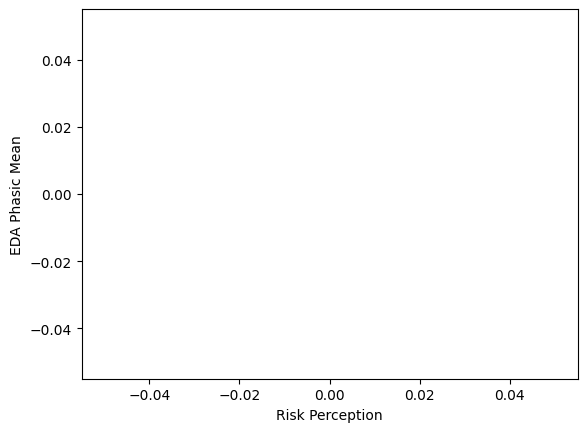

In [ ]:

import matplotlib.pyplot as plt

group_means = final_df[final_df['P_Video']== 0].groupby('Risk Perception')['EDA_Phasic'].mean().abs()
print(group_means.abs())
# Calculate standard deviations
group_stds = final_df[final_df['P_Video']==0].groupby('Risk Perception')['EDA_Phasic'].std()

# Create a bar plot
plt.bar(group_means.index, group_means.values, capsize=5)#,yerr=group_stds.values)

# Add labels and title
plt.xlabel('Risk Perception')
plt.ylabel('EDA Phasic Mean')
#plt.title('Absolure mean values for Phasic component per Risk group')

# Show the plot
plt.show()


### Heart Rate

Risk Perception  Automation Error
Control          With Error          80.620245
                 Without Error       82.772328
HR               With Error          82.234097
                 Without Error       85.363719
LR               With Error          84.208618
                 Without Error       86.759365
Name: Heart Rate_mean, dtype: float64


In [ ]:
final_df['Heart Rate'] = df['Heart Rate_mean']

In [ ]:
df.columns

Index(['Risk_Perception', 'Automation_Error', 'ID', 'Gender', 'Years_Driving',
       'Eagerness_to_Adopt', 'Knowledge_of_SDV',
       'Perceived_Benefits_of_Using_a_Self-Driving_Vehicle',
       'Dispositional_Trust', 'Risk_Propensity', 'Learned_Trust', 'Trust',
       'Risk', 'Hostility', 'Confidence', 'Loneliness', 'Anxiety',
       'SCR_Onsets', 'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude',
       'SCR_RiseTime', 'SCR_Recovery', 'SCR_RecoveryTime',
       'Heart_Rate_cleaned', 'Heart_Rate_mean', 'Heart_Rate_max',
       'Heart_Rate_min', 'Heart_Rate_std', 'EDA_Phasic', 'EDA_Clean',
       'EDA_Tonic'],
      dtype='object')

Risk Perception  Automation Error
Control          With Error          80.461794
                 Without Error       82.493778
HR               With Error          81.818983
                 Without Error       85.413980
LR               With Error          84.015188
                 Without Error       87.041669
Name: Heart Rate_mean, dtype: float64
Risk Perception
Control    17.570062
HR         19.287140
LR         19.531672
Name: Heart Rate_mean, dtype: float64

 Standard Error
Risk Perception
Control    0.000028
HR         0.000031
LR         0.000034
Name: Heart Rate_mean, dtype: float64


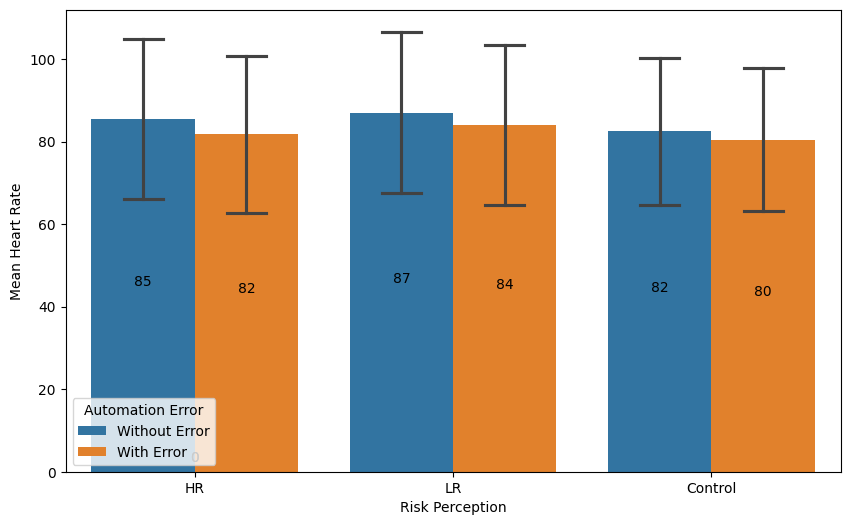

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))
# plt.plot(df['Heart Rate_mean'])
# group_means = final_df.groupby('Risk Perception')['Heart Rate_cleaned'].mean()
# print(group_means.abs())

group_means = final_df.groupby(['Risk Perception','Automation Error'])['Heart Rate_mean'].mean()



# Print the result
print(group_means)

# Calculate standard deviations
group_stds = final_df.groupby('Risk Perception')['Heart Rate_mean'].std() #.sem() #for standard error
group_se = final_df.groupby('Risk Perception')['Heart Rate_mean'].std()/final_df.groupby('Risk Perception')['Heart Rate_mean'].count()
print(group_stds)
print('\n Standard Error')
print(group_se)

# Create a bar plot
#plt.bar(group_means.index, group_means.values, capsize=5,yerr=group_stds.values)


ax = sns.barplot(data=final_df, y='Heart Rate_mean',hue='Automation Error',x='Risk Perception',errorbar='sd',capsize=0.3)

# Add data labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                 (p.get_x() + p.get_width() / 2., p.get_height()/2.),
                 ha='center', va='center',
                 xytext=(0, 10), textcoords='offset points')
# Add labels and title
plt.xlabel('Risk Perception')
plt.ylabel('Mean Heart Rate')
#plt.title('Mean of Heart Rate per Risk group')

# Show the plot
plt.show()
# with standard error
# fig = plt.figure(figsize=(10, 6))
# sns.barplot(data=final_df, y='Heart Rate_mean',hue='Automation Error',x='Risk Perception',errorbar='se')

In [ ]:
# sns.barplot(data=final_df, y='Heart Rate_mean',hue='Automation Error',x='Risk Perception',errorbar='sd')

#### Line plots

In [ ]:
df8 =final_df[final_df['ID']==68]

In [ ]:
df = final_df.copy()

In [ ]:
df['Heart Rate_smooth'] = df['Heart Rate_mean'].rolling(window=128).mean()

In [ ]:
df8 = df[df['ID'] == 68]

In [ ]:
df8.time = pd.to_datetime(df8.time)
df8.set_index('time', inplace=True)

<ipython-input-43-0368f7260733>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df8.time = pd.to_datetime(df8.time)
<ipython-input-43-0368f7260733>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df8.time = pd.to_datetime(df8.time)


### Heart Rate anova

### HRV

In [ ]:
df8.columns

Index(['Risk Perception', 'Automation Error', 'ID', 'System Timestamp CAL',
       'Timestamp RAW', 'Date', 'Time', 'EDA_Raw', 'Heart Rate', 'EDA_Clean',
       'EDA_Tonic', 'EDA_Phasic', 'N_Video', 'P_Video', 'SCR_Onsets',
       'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude', 'SCR_RiseTime',
       'SCR_Recovery', 'SCR_RecoveryTime', 'time', 'ttime', 'Record Number'],
      dtype='object')

### EDA_Phasic

In [ ]:
final_df['EDA_Phasic_abs'] = final_df['EDA_Phasic'].abs()

In [ ]:
final_df.columns

Index(['Risk Perception', 'Automation Error', 'ID', 'System Timestamp CAL',
       'Timestamp RAW', 'Date', 'Time', 'EDA_Raw', 'Heart Rate PPG ALG',
       'Heart Rate PPG ALG_int', 'Heart Rate_mean', 'Heart Rate_max',
       'Heart Rate_min', 'Heart Rate_std', 'IBI PPG ALG', 'EDA_Clean',
       'EDA_Tonic', 'EDA_Phasic', 'N_Video', 'P_Video', 'SCR_Onsets',
       'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude', 'SCR_RiseTime',
       'SCR_Recovery', 'SCR_RecoveryTime'],
      dtype='object')

In [ ]:
##------- EDA_Phasic
#aov = pg.anova(dv='EDA_Phasic', between='Group',data=final_df)
print("-------------EDA Clean Raw---------------")
aov = pg.mixed_anova(dv='EDA_Clean', between='Risk Perception', within='Automation Error', subject='ID', data=final_df).round(3)
print(aov)
print("\n -------------EDA Tonic---------------")
aov = pg.mixed_anova(dv='EDA_Tonic_norm', between='Risk Perception', within='Automation Error', subject='ID', data=final_df).round(3)
print(aov)

print("\n -------------EDA Phasic---------------")
aov = pg.mixed_anova(dv='EDA_Phasic_norm', between='Risk Perception', within='Automation Error', subject='ID', data=final_df).round(3)

# Print the result
print(aov)

# sns.barplot(data=final_df, y='EDA_Clean',hue='Automation Error',x='Risk Perception')
# plt.show()


-------------EDA Clean Raw---------------
             Source       SS  DF1  DF2      MS      F  p-unc    np2  eps
0   Risk Perception  161.040    2   67  80.520  0.918  0.404  0.027  NaN
1  Automation Error    6.507    1   67   6.507  0.410  0.524  0.006  1.0
2       Interaction   21.679    2   67  10.840  0.684  0.508  0.020  NaN

 -------------EDA Tonic---------------
             Source       SS  DF1  DF2      MS      F  p-unc    np2  eps
0   Risk Perception  161.077    2   67  80.538  0.919  0.404  0.027  NaN
1  Automation Error    6.477    1   67   6.477  0.409  0.525  0.006  1.0
2       Interaction   21.725    2   67  10.863  0.686  0.507  0.020  NaN

 -------------EDA Phasic---------------
             Source     SS  DF1  DF2     MS      F  p-unc    np2  eps
0   Risk Perception  0.002    2   67  0.001  0.123  0.884  0.004  NaN
1  Automation Error  0.000    1   67  0.000  0.005  0.943  0.000  1.0
2       Interaction  0.000    2   67  0.000  1.863  0.163  0.053  NaN


In [ ]:
pg.rm_anova(data=final_df, dv='EDA_Phasic_norm', within='Automation Error', subject='ID', correction='auto', detailed=False, effsize='n2')

Source  ddof1  ddof2         F     p-unc            n2  eps
0  Automation Error      1     69  0.005052  0.943541  4.921100e-09  1.0

In [ ]:
final_df['EDA_Phasic']

In [ ]:
len(final_df.ID.unique())


70

             Source     SS  DF1  DF2     MS      F  p-unc    np2  eps
0   Risk Perception  0.002    2   67  0.001  0.123  0.884  0.004  NaN
1  Automation Error  0.000    1   67  0.000  0.000  0.997  0.000  1.0
2       Interaction  0.000    2   67  0.000  1.692  0.192  0.048  NaN


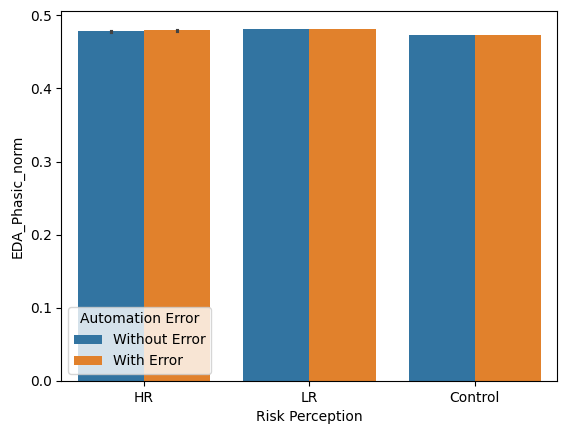

In [ ]:
##------- EDA_Phasic
#aov = pg.anova(dv='EDA_Phasic', between='Group',data=final_df)
aov = pg.mixed_anova(dv='EDA_Phasic_norm', between='Risk Perception', within='Automation Error', subject='ID', data=final_df).round(3)

# Print the result
print(aov)

sns.barplot(data=final_df, y='EDA_Phasic_norm',hue='Automation Error',x='Risk Perception')
plt.show()

             Source     SS  DF1  DF2     MS      F  p-unc    np2  eps
0   Risk Perception  0.078    2   67  0.039  1.483  0.234  0.042  NaN
1  Automation Error  0.001    1   67  0.001  0.018  0.895  0.000  1.0
2       Interaction  0.069    2   67  0.035  0.562  0.572  0.017  NaN


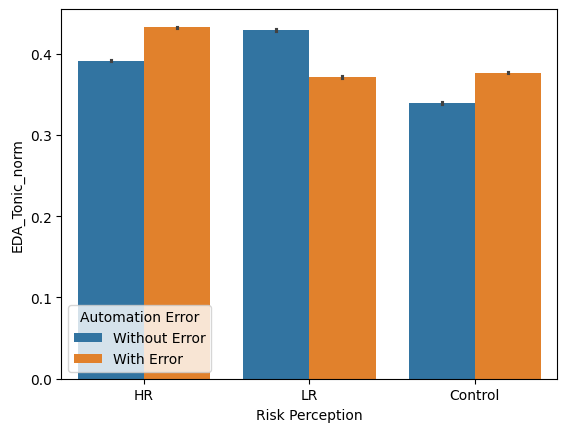

In [ ]:
##------- EDA_Tonic
#aov = pg.anova(dv='EDA_Phasic', between='Group',data=final_df)
aov = pg.mixed_anova(dv='EDA_Tonic_norm', between='Risk Perception', within='Automation Error', subject='ID', data=final_df).round(3)

# Print the result
print(aov)

sns.barplot(data=final_df, y='EDA_Tonic_norm',hue='Automation Error',x='Risk Perception')
plt.show()

             Source       SS  DF1  DF2      MS      F  p-unc    np2  eps
0   Risk Perception  152.570    2   67  76.285  0.842  0.435  0.025  NaN
1  Automation Error    9.350    1   67   9.350  0.682  0.412  0.010  1.0
2       Interaction   17.786    2   67   8.893  0.649  0.526  0.019  NaN


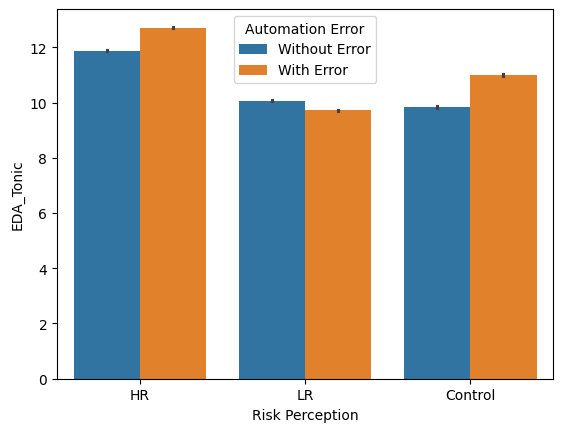

In [ ]:
##------- EDA_Tonic
#aov = pg.anova(dv='EDA_Phasic', between='Group',data=final_df)
aov = pg.mixed_anova(dv='EDA_Tonic', between='Risk Perception', within='Automation Error', subject='ID', data=final_df).round(3)

# Print the result
print(aov)

sns.barplot(data=final_df, y='EDA_Tonic',hue='Automation Error',x='Risk Perception')
plt.show()

#### Means bar plots

In [ ]:
# dim = min(len(final_df[final_df['Risk Perception']=='HR']),len(final_df[final_df['Risk Perception']=='LR']),len(final_df[final_df['Risk Perception']=='Control']))
# print(dim)
# dim1 = int(dim/3)

aov = pg.mixed_anova(dv='EDA_Phasic', between='Risk Perception', within='Automation Error', subject='ID', data=final_df.iloc[0:dim1,:]).round(3)
print( aov)



# sns.barplot(data=final_df, y='EDA_Phasic_norm',hue='Automation Error',x='Risk Perception')
# plt.show()


# sns.barplot(data=final_df, y='EDA_Phasic',hue='Automation Error',x='Risk Perception')
# plt.show()

# aov = pg.mixed_anova(dv='EDA_Tonic', between='Risk Perception', within='Automation Error', subject='ID', data=final_df).round(3)
# print( aov)
# sns.barplot(data=final_df, y='EDA_Tonic',hue='Automation Error',x='Risk Perception')
# plt.show()

689379
             Source   SS  DF1  DF2   MS      F  p-unc    np2  eps
0   Risk Perception  0.0    0    6  NaN    NaN    NaN  0.000  NaN
1  Automation Error  0.0    1    6  0.0  0.827  0.398  0.121  1.0
2       Interaction -0.0    0    6 -inf   -inf    NaN -0.000  NaN


In [ ]:
# prompt: conver Time column into datetime format
final_df['ttime'] = pd.to_datetime(final_df['Time']) #,format='%H:%M:%S.%f')[:-3]

# Now you can use strftime
final_df['time'] = (final_df['ttime'].dt.strftime("%H:%M:%S.%f")[:-3])
final_df['time'].head(2)

# final_df['time']=final_df['Time'].strftime("%H:%M:%S")
# final_df['time'].head(2)

<ipython-input-199-7e17f0a714dd>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  final_df['ttime'] = pd.to_datetime(final_df['Time']) #,format='%H:%M:%S.%f')[:-3]


0    13:21:02.229000
1    13:21:02.291000
Name: time, dtype: object

In [ ]:
final_df['Record Number'] = final_df.groupby(['ID', 'Risk Perception', 'Automation Error']).cumcount() + 1


In [ ]:
final_df.to_csv(output_file)
# final_df.to_csv('/content/drive/MyDrive/Emotion_Em/Results/Datasets/physiologicalDataAll_Oct25.csv',index=False)

In [ ]:
# prompt: remove records that have less than 44 data points

# Assuming 'final_df' is your DataFrame
# Group by 'ID' and count the number of data points for each ID
#record_counts = final_df.groupby('Record Number')['Heart Rate_mean'].count()
# record_counts = final_df.groupby(['Record Number'])['Heart Rate_mean'].value_counts()
record_counts = final_df.groupby(['Automation Error','Record Number'])['Heart Rate_mean'].size()
print(record_counts)

# Filter out IDs with less than 44 data points
valid_ids = record_counts[record_counts >= 70].index
print(valid_ids)
# Subset the DataFrame to include only the valid IDs
df = final_df[final_df['Record Number'].isin(valid_ids.get_level_values(1))]
print(df.shape)
print(final_df.shape)
# final_df = df

record_counts = df.groupby(['Automation Error','Record Number'])['Heart Rate_mean'].size()
print(record_counts)

final_df = df

Automation Error  Record Number
With Error        1                70
                  2                70
                  3                70
                  4                70
                  5                70
                                   ..
Without Error     19619             1
                  19620             1
                  19621             1
                  19622             1
                  19623             1
Name: Heart Rate_mean, Length: 39787, dtype: int64
MultiIndex([(   'With Error',     1),
            (   'With Error',     2),
            (   'With Error',     3),
            (   'With Error',     4),
            (   'With Error',     5),
            (   'With Error',     6),
            (   'With Error',     7),
            (   'With Error',     8),
            (   'With Error',     9),
            (   'With Error',    10),
            ...
            ('Without Error', 10965),
            ('Without Error', 10966),
            ('Without Error

In [ ]:
# valid_ids.get_level_values(1)

Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,    10,
       ...
       10965, 10966, 10967, 10968, 10969, 10970, 10971, 10972, 10973, 10974],
      dtype='int64', name='Record Number', length=21546)

In [ ]:
average_Phasic_HR_nE = final_df[(final_df['Risk Perception']=='HR')& (final_df['Automation Error']=='Without Error')].groupby('Record Number')['EDA_Phasic'].mean()
average_Phasic_HR_E = final_df[(final_df['Risk Perception']=='HR') & (final_df['Automation Error']=='With Error')].groupby('Record Number')['EDA_Phasic'].mean()
average_Phasic_LR_nE = final_df[(final_df['Risk Perception']=='LR') & (final_df['Automation Error']=='Without Error')].groupby('Record Number')['EDA_Phasic'].mean()
average_Phasic_LR_E = final_df[(final_df['Risk Perception']=='LR') & (final_df['Automation Error']=='With Error')].groupby('Record Number')['EDA_Phasic'].mean()
average_Phasic_C_nE = final_df[(final_df['Risk Perception']=='Control') & (final_df['Automation Error']=='Without Error')].groupby('Record Number')['EDA_Phasic'].mean()
average_Phasic_C_E = final_df[(final_df['Risk Perception']=='Control') & (final_df['Automation Error']=='With Error')].groupby('Record Number')['EDA_Phasic'].mean()

In [ ]:
#------- using video annotations-------
average_Phasic_HR_nE = final_df[(final_df['Risk Perception']=='HR')& (final_df['P_Video']==1)].groupby('Record Number')['EDA_Phasic'].mean()
average_Phasic_HR_E = final_df[(final_df['Risk Perception']=='HR') & (final_df['N_Video']==1)].groupby('Record Number')['EDA_Phasic'].mean()
average_Phasic_LR_nE = final_df[(final_df['Risk Perception']=='LR') & (final_df['P_Video']==1)].groupby('Record Number')['EDA_Phasic'].mean()
average_Phasic_LR_E = final_df[(final_df['Risk Perception']=='LR') & (final_df['N_Video']==1)].groupby('Record Number')['EDA_Phasic'].mean()
average_Phasic_C_nE = final_df[(final_df['Risk Perception']=='Control') & (final_df['P_Video']==1)].groupby('Record Number')['EDA_Phasic'].mean()
average_Phasic_C_E = final_df[(final_df['Risk Perception']=='Control') & (final_df['N_Video']==1)].groupby('Record Number')['EDA_Phasic'].mean()

In [ ]:
#------- using video annotations-------
average_HRate_HR_nE = final_df[(final_df['Risk Perception']=='HR')& (final_df['P_Video']==1)].groupby('Record Number')['Heart Rate_mean'].mean()
average_HRate_HR_E = final_df[(final_df['Risk Perception']=='HR') & (final_df['N_Video']==1)].groupby('Record Number')['Heart Rate_mean'].mean()
average_HRate_LR_nE = final_df[(final_df['Risk Perception']=='LR') & (final_df['P_Video']==1)].groupby('Record Number')['Heart Rate_mean'].mean()
average_HRate_LR_E = final_df[(final_df['Risk Perception']=='LR') & (final_df['N_Video']==1)].groupby('Record Number')['Heart Rate_mean'].mean()
average_HRate_C_nE = final_df[(final_df['Risk Perception']=='Control') & (final_df['P_Video']==1)].groupby('Record Number')['Heart Rate_mean'].mean()
average_HRate_C_E = final_df[(final_df['Risk Perception']=='Control') & (final_df['N_Video']==1)].groupby('Record Number')['Heart Rate_mean'].mean()

In [ ]:
final_df.columns

Index(['Risk Perception', 'Automation Error', 'ID', 'System Timestamp CAL',
       'Timestamp RAW', 'Date', 'Time', 'EDA_Raw', 'Heart Rate_raw',
       'Heart Rate_cleaned', 'Heart Rate_mean', 'Heart Rate_max',
       'Heart Rate_min', 'Heart Rate_std', 'IBI PPG ALG', 'EDA_Clean',
       'EDA_Tonic', 'EDA_Phasic', 'N_Video', 'P_Video', 'SCR_Onsets',
       'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude', 'SCR_RiseTime',
       'SCR_Recovery', 'SCR_RecoveryTime', 'EDA_Phasic_abs', 'time',
       'Record Number', 'EDA_Phasic_norm'],
      dtype='object')

In [ ]:
final_df[(final_df['Risk Perception']=='HR')& (final_df['Automation Error']=='Without Error')].groupby('Record Number')['EDA_Phasic'].count()

In [ ]:
print(len(average_Phasic_HR_nE))
print(len(average_Phasic_LR_nE))
print(len(average_Phasic_C_nE))

12513
12502
12761


In [ ]:
print(len(average_Phasic_HR_E))
print(len(average_Phasic_LR_E))
print(len(average_Phasic_C_E))

14398
13824
14429


In [ ]:
average_Phasic_HR_nE

Record Number
1        0.184178
2        0.235436
3        0.285894
4        0.335218
5        0.383092
           ...   
17587    0.255569
17588    0.517737
17589    0.788175
17590    1.064505
17591    1.344214
Name: EDA_Phasic, Length: 17591, dtype: float64

#### Line plots

In [ ]:
print(len(average_Phasic_HR_nE))
print(len(average_Phasic_LR_nE))
print(len(average_Phasic_C_nE))

12690
12577
12729


10974


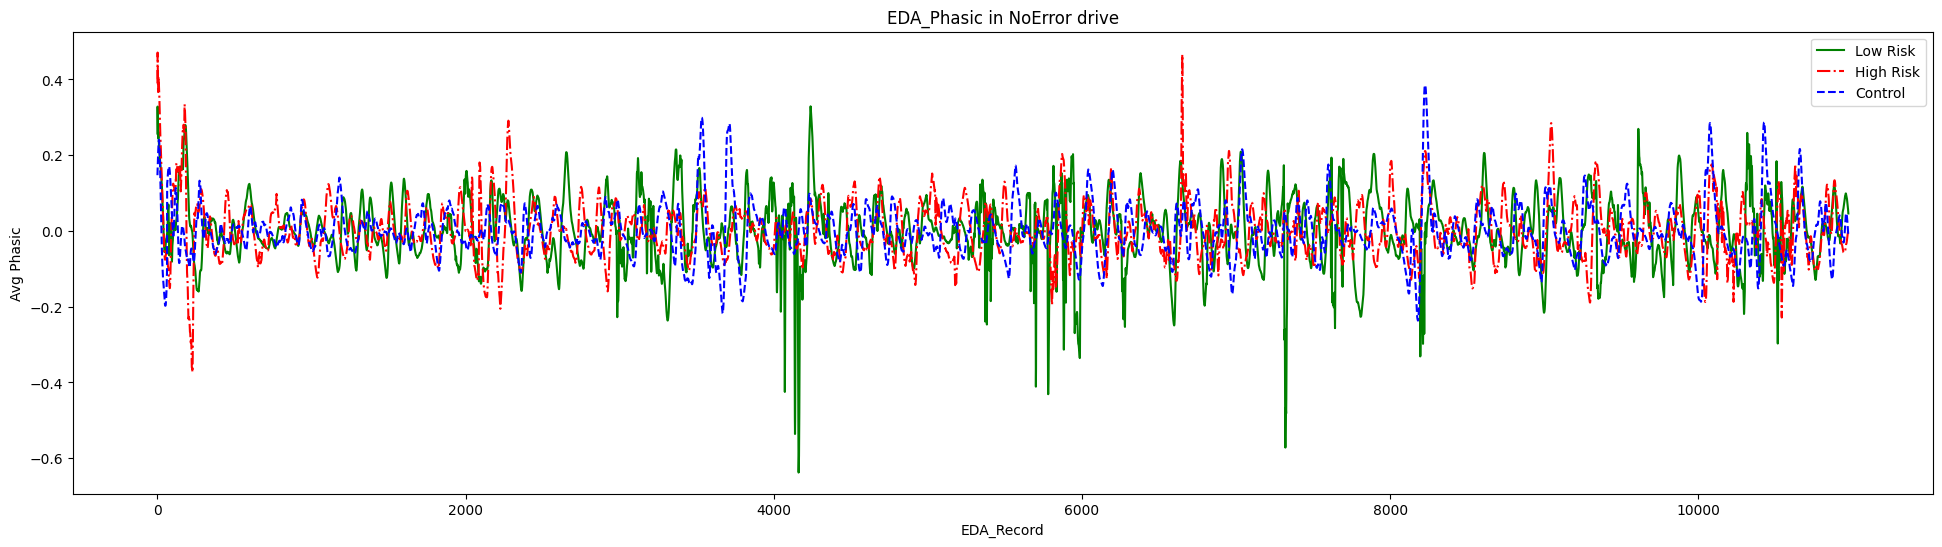

In [ ]:
# No Error drive Phasic
dim = min(len(average_Phasic_HR_nE),len(average_Phasic_LR_nE),len(average_Phasic_C_nE)) #,len(average_sa_LR_E,len(average_sa_HR_E),)
print(dim)

dim_th = int((dim/3))
# print(dim)
dim1 = 1
dim2 = dim
x = range(1, dim )
#x = range(1, dim_th +1)

# Create a wider figure
fig, ax = plt.subplots(figsize=(24, 6))

# Plot the first set of data
ax.plot(x, average_Phasic_LR_nE[dim1:dim2], label='Low Risk',  color='green', markersize = 5)#marker='x',

# Plot the second set of data on the same axis, stacked on top of the first set
ax.plot(x, average_Phasic_HR_nE[dim1:dim2], label='High Risk', color='r',markersize = 5,linestyle='dashdot') #marker='o'
# Plot the second set of data on the same axis, stacked on top of the first set
ax.plot(x, average_Phasic_C_nE[dim1:dim2], label='Control', color='b',markersize = 5,linestyle='--') #marker='s'

# # Add vertical lines
# vertical_lines = [5, 10, 15, 23]
# for line in vertical_lines:
#     ax.axvline(x=line, color='orange', linestyle='--', label='TOR')

# Set labels and title
ax.set_xlabel('EDA_Record')
ax.set_ylabel('Avg Phasic')
ax.set_title('EDA_Phasic in NoError drive')

# Add legend
handles, labels = ax.get_legend_handles_labels()
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)
ax.legend(unique_handles, unique_labels)


# Set y-axis limits
#ax.set_xlim(0, 100)
#plt.xticks(range(1, len(average_Phasic_HR_nE) + 1,100),rotation=45)

# Display the plot
plt.show()

10974


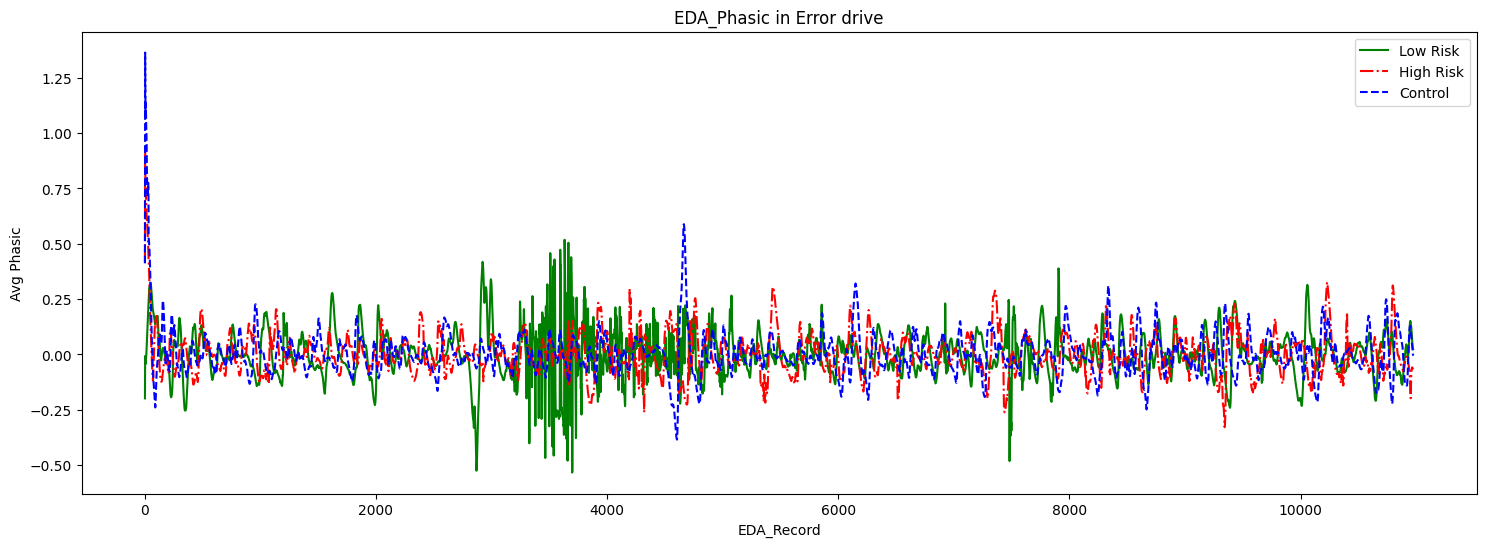

In [ ]:
# Error drive SA
dim = min(len(average_Phasic_HR_E),len(average_Phasic_LR_E),len(average_Phasic_C_E)) #,len(average_sa_LR_E,len(average_sa_HR_E),)
print(dim)
#dim =dim-100
dim_th = int((dim/3))
# print(dim)
x = range(1, dim + 1)
#x = range(1, dim_th+1)

dim1 = 0#2*dim_th
dim2 = dim

# Create a wider figure
fig, ax = plt.subplots(figsize=(18, 6))

# Plot the first set of data
ax.plot(x, average_Phasic_LR_E[dim1:dim2], label='Low Risk',  color='green',markersize=5) #marker='x',

# Plot the second set of data on the same axis, stacked on top of the first set
ax.plot(x, average_Phasic_HR_E[dim1:dim2], label='High Risk', color='r',linestyle='dashdot',markersize=5) #marker='o',
# Plot the second set of data on the same axis, stacked on top of the first set
ax.plot(x, average_Phasic_C_E[dim1:dim2], label='Control', color='b',linestyle='--',markersize=5) #marker='s'
## Plot the first set of data
# x = range(1, len(average_Phasic_LR_E) + 1)
# ax.plot(x, average_Phasic_LR_E[:], label='Low Risk',  color='green') #marker='x',

# # Plot the second set of data on the same axis, stacked on top of the first set
# x = range(1, len(average_Phasic_HR_E) + 1)
# ax.plot(x, average_Phasic_HR_E[:], label='High Risk', color='r',linestyle='dashdot') #marker='o',
# # Plot the second set of data on the same axis, stacked on top of the first set
# x = range(1, len(average_Phasic_C_E) + 1)
# ax.plot(x, average_Phasic_C_E[:], label='Control', color='b',linestyle='--') #marker='s'

# # Add vertical lines
# vertical_lines = [5, 10, 15, 23]
# for line in vertical_lines:
#     ax.axvline(x=line, color='orange', linestyle='--', label='TOR')

# Set labels and title
ax.set_xlabel('EDA_Record')
ax.set_ylabel('Avg Phasic')
ax.set_title('EDA_Phasic in Error drive')

# Add legend
handles, labels = ax.get_legend_handles_labels()
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)
ax.legend(unique_handles, unique_labels)


# Set y-axis limits
#ax.set_ylim(-3, 4)
#plt.xticks(range(dim, 2*dim+ 1),rotation=45)

# Display the plot
plt.show()

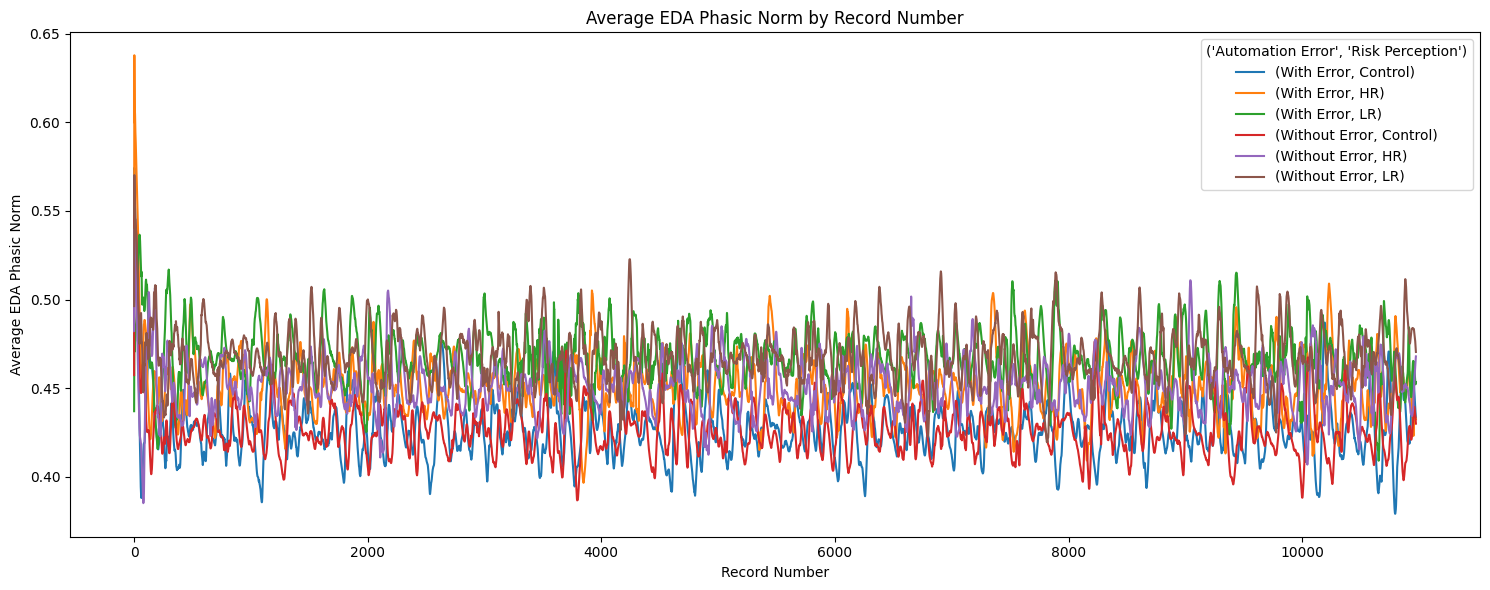

In [ ]:
# plot the average EDA_phasic_norm value by record number groupped by automation error and Risk Perception

import matplotlib.pyplot as plt

# Group the data by 'Record Number', 'Automation Error', and 'Risk Perception' and calculate the average 'EDA_Phasic_norm'
average_phasic_by_record = final_df.groupby(['Record Number', 'Automation Error', 'Risk Perception'])['EDA_Phasic_norm'].mean().unstack(['Automation Error', 'Risk Perception'])

# Plot the average EDA_Phasic_norm by record number for each group
average_phasic_by_record.plot(figsize=(15, 6))

# Customize the plot
plt.title('Average EDA Phasic Norm by Record Number')
plt.xlabel('Record Number')
plt.ylabel('Average EDA Phasic Norm')
plt.legend(title=('Automation Error', 'Risk Perception'))
plt.tight_layout()

# Show the plot
# Display the plot
plt.show()


#### By automation error

In [ ]:
final_df[(final_df['P_Video']==1)].groupby('Record Number')['EDA_Phasic'].mean()

Record Number
1        0.114332
2        0.289279
3        0.352872
4        0.332473
5        0.296484
           ...   
10970    0.021498
10971    0.018781
10972    0.015710
10973    0.012478
10974    0.009317
Name: EDA_Phasic, Length: 10974, dtype: float64

12762


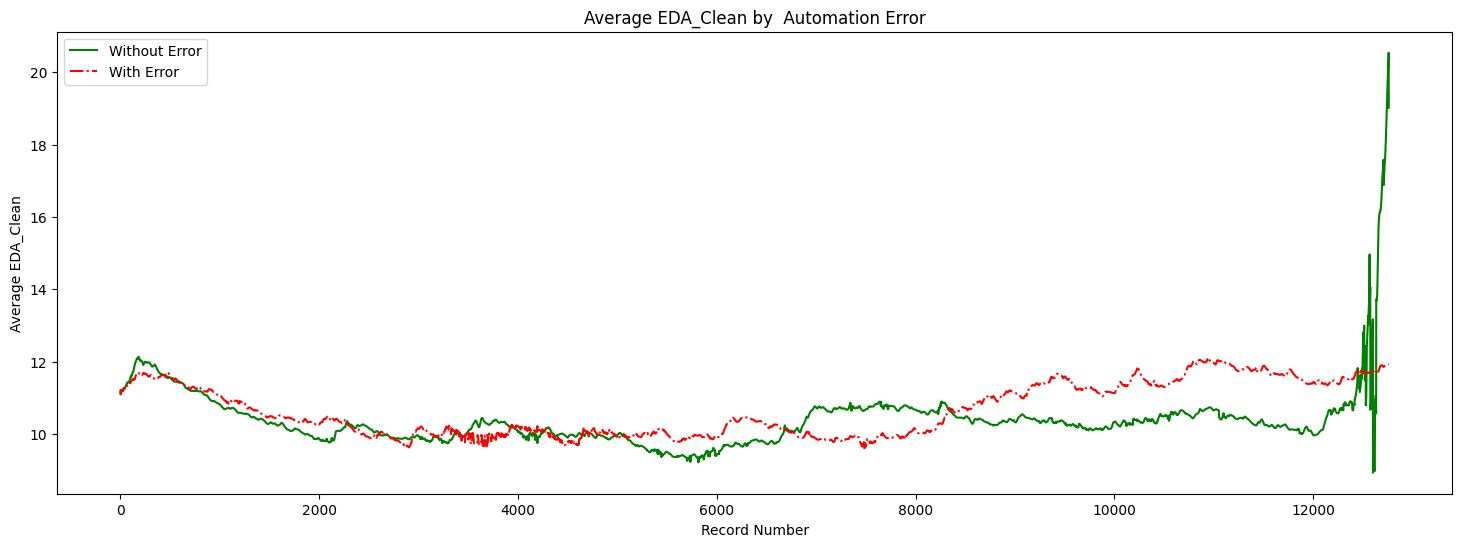

In [ ]:
# plot the average EDA_phasic_norm value by record number groupped by automation error

import matplotlib.pyplot as plt
var = 'EDA_Clean'
average_Phasic_nE = final_df[(final_df['P_Video']==1)].groupby('Record Number')[var].mean()
average_Phasic_E = final_df[(final_df['N_Video']==1)].groupby('Record Number')[var].mean()


dim = min(len(average_Phasic_nE),len(average_Phasic_E))
print(dim)
x = range(1, dim + 1)

# Create a wider figure
fig, ax = plt.subplots(figsize=(18, 6))

# Plot the first set of data
ax.plot(x, average_Phasic_nE[:dim], label='Without Error',  color='green',markersize=5) #marker='x',

# Plot the second set of data on the same axis, stacked on top of the first set
ax.plot(x, average_Phasic_E[:dim], label='With Error', color='r',linestyle='dashdot',markersize=5) #marker='o',

# Set labels and title
ax.set_xlabel('Record Number')
ax.set_ylabel(f'Average {var}')
ax.set_title(f'Average {var} by  Automation Error')

# Add legend
ax.legend()
# plt.xlim(100,dim)
# plt.ylim(0.42,0.52)
#plt.xticks(range(0, dim),rotation=45)
# Display the plot
plt.show()

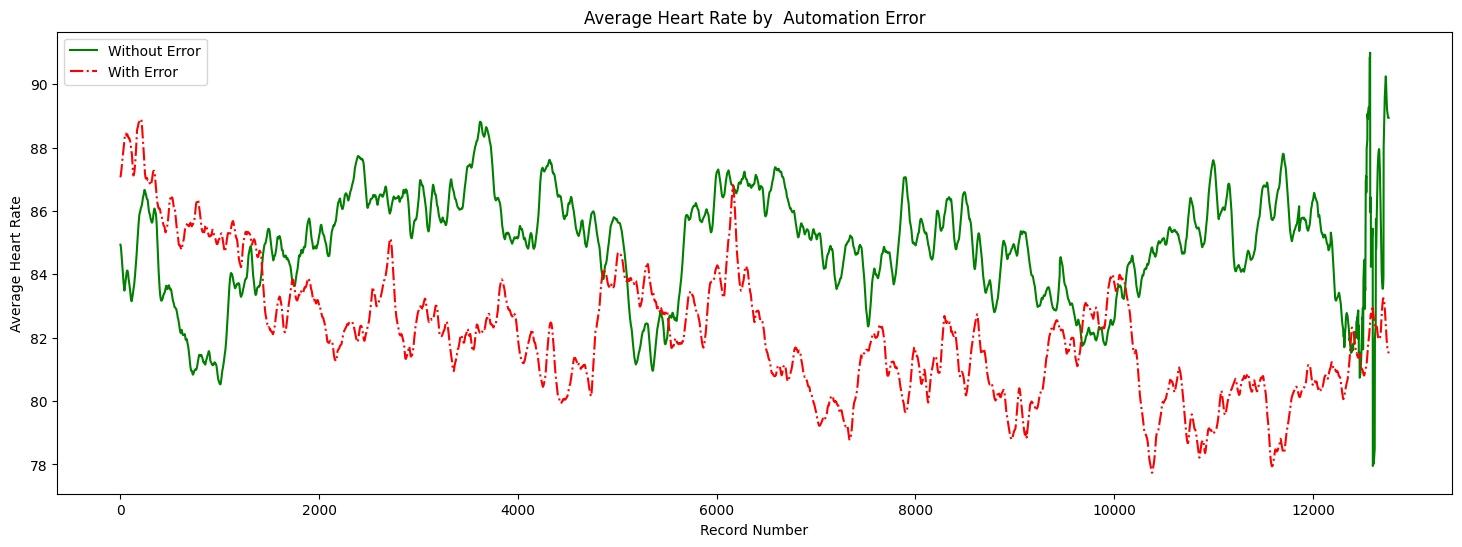

In [ ]:
import matplotlib.pyplot as plt
average_HR_nE = final_df[(final_df['P_Video']==1)].groupby('Record Number')['Heart Rate_mean'].mean()
average_HR_E = final_df[(final_df['N_Video']==1)].groupby('Record Number')['Heart Rate_mean'].mean()

dim = min(len(average_HR_nE),len(average_HR_E))
x = range(1, dim + 1)

# Create a wider figure
fig, ax = plt.subplots(figsize=(18, 6))

# Plot the first set of data
ax.plot(x, average_HR_nE[:dim], label='Without Error',  color='green',markersize=5) #marker='x',

# Plot the second set of data on the same axis, stacked on top of the first set
ax.plot(x, average_HR_E[:dim], label='With Error', color='r',linestyle='dashdot',markersize=5) #marker='o',

# Set labels and title
ax.set_xlabel('Record Number')
ax.set_ylabel('Average Heart Rate')
ax.set_title('Average Heart Rate by  Automation Error')

# Add legend
ax.legend()
#plt.xlim(0,200)
# Display the plot
plt.show()

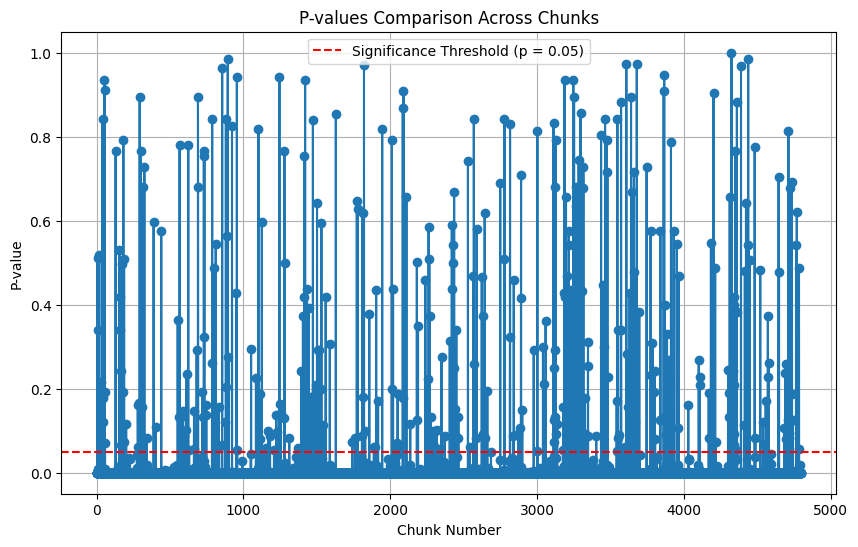

In [ ]:
compare_stats(final_df,'Heart Rate_mean',80)

ValueError: too many values to unpack (expected 2)

In [ ]:
n = final_df.groupby(['Risk Perception','Automation Error'])['Record Number'].max()
print(n)
#

k = final_df.groupby(['Risk Perception','Automation Error'])['Record Number'].value_counts()
print(k)

part_n = final_df.groupby(['Risk Perception'])['ID'].nunique()
part_n
#

Risk Perception  Automation Error
Control          With Error          14540
                 Without Error       12762
HR               With Error          14059
                 Without Error       12632
LR               With Error          13962
                 Without Error       12576
Name: Record Number, dtype: int64
Risk Perception  Automation Error  Record Number
Control          With Error        1                24
                                   2                24
                                   3                24
                                   4                24
                                   5                24
                                                    ..
LR               Without Error     12572             1
                                   12573             1
                                   12574             1
                                   12575             1
                                   12576             1
Name: count, Length:

Risk Perception
Control    24
HR         24
LR         22
Name: ID, dtype: int64

In [ ]:
part_n = final_df.groupby(['Record Number','Automation Error'])['ID'].nunique()
part_n

Record Number  Automation Error
1              With Error          70
               Without Error       70
2              With Error          70
               Without Error       70
3              With Error          70
                                   ..
20160          With Error           1
20161          With Error           1
20162          With Error           1
20163          With Error           1
20164          With Error           1
Name: ID, Length: 39779, dtype: int64

Record Number
1        140
2        140
3        140
4        140
5        140
        ... 
20160      1
20161      1
20162      1
20163      1
20164      1
Name: Heart Rate_mean, Length: 20164, dtype: int64
Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,    10,
       ...
       15616, 15617, 15618, 15619, 15620, 15621, 15622, 15623, 15624, 15625],
      dtype='int64', name='Record Number', length=15625)
(2107301, 28)
(2188188, 28)
Record Number
1        140
2        140
3        140
4        140
5        140
        ... 
15621     70
15622     70
15623     70
15624     70
15625     70
Name: Heart Rate_mean, Length: 15625, dtype: int64


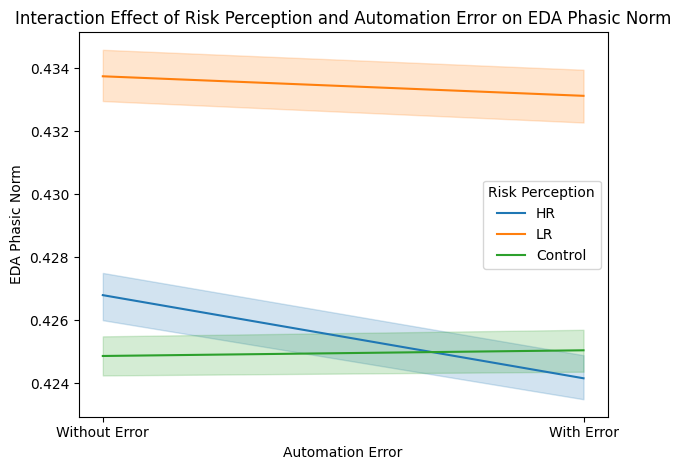

In [ ]:
#  plot the interaction effect of Risk perception and automation error for EDA_Phasic_norm

import seaborn as sns
import matplotlib.pyplot as plt

# Create an interaction plot using seaborn
sns.lineplot(data=subset1,  y='EDA_Phasic_norm', hue='Risk Perception', x='Automation Error')

# Customize the plot
plt.title('Interaction Effect of Risk Perception and Automation Error on EDA Phasic Norm')
plt.xlabel('Automation Error')
plt.ylabel('EDA Phasic Norm')
plt.legend(title=('Risk Perception'))
plt.tight_layout()

# Show the plot
plt.show()


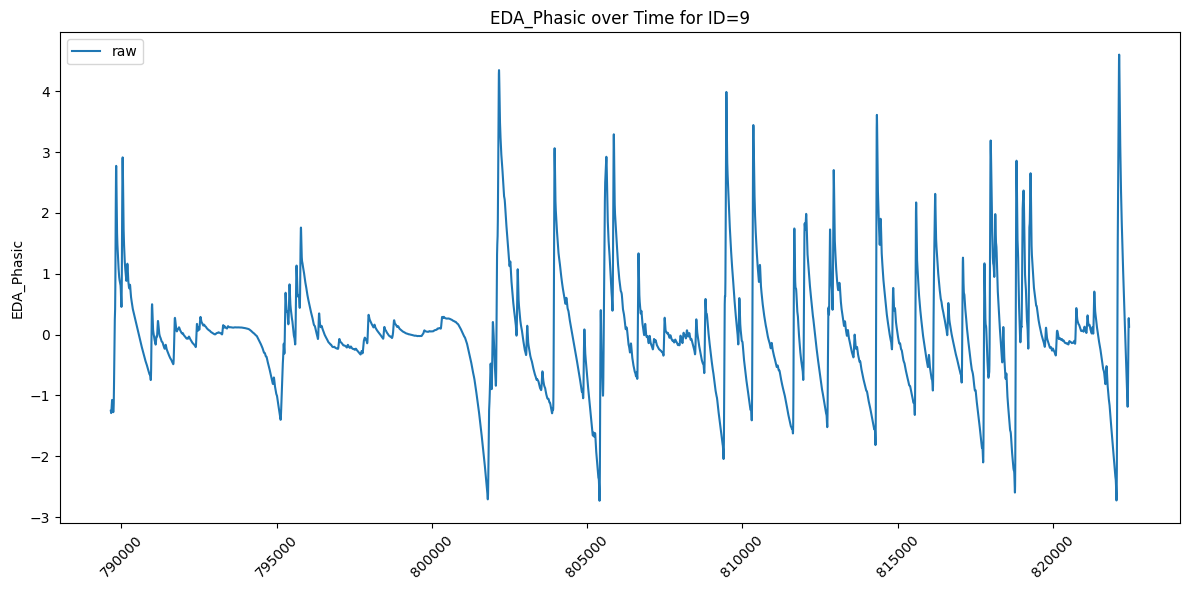

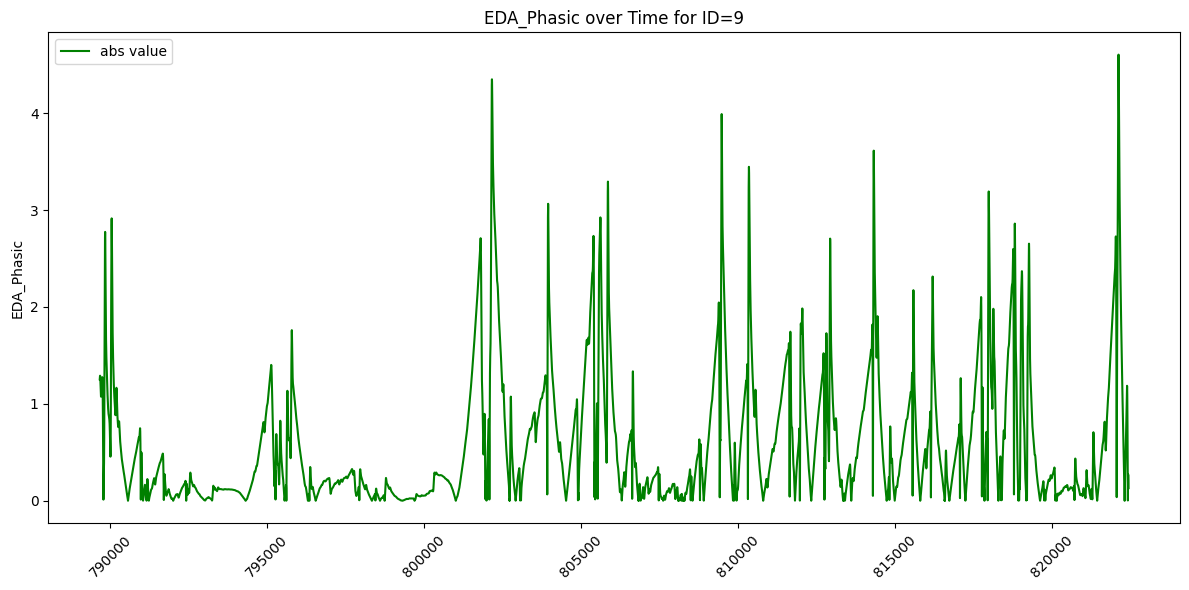

In [ ]:
# prompt: plot EDA_Phasic over Time for ID=8

# Filter the DataFrame for ID=8
df_id8 = final_df[final_df['ID'] == 9]

# Convert the 'Time' column to datetime format
#df_id8['Time'] = pd.to_datetime(df_id8['Time'],format='%H:%M:%S')
#df_id8['Time']  = datetime.strptime(df_id8['Time'], '%H:%M:%S')
plt.figure(figsize=(12, 6))
plt.plot(df_id8['EDA_Phasic'].index, df_id8['EDA_Phasic'],label='raw')
#plt.xlabel('Time')
plt.ylabel('EDA_Phasic')
plt.title('EDA_Phasic over Time for ID=9')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


# Create the plot
plt.figure(figsize=(12, 6))
#plt.plot(df_id8['EDA_Phasic'].index, df_id8['EDA_Phasic'],label='raw')
plt.plot(df_id8['EDA_Phasic_abs'].index, df_id8['EDA_Phasic_abs'],label='abs value',c='g')


#plt.xlabel('Time')
plt.ylabel('EDA_Phasic')
plt.title('EDA_Phasic over Time for ID=9')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [ ]:
# fig = plt.figure(figsize=(15, 6))
# plt.plot(final_df['Time'],final_df['EDA_Phasic'],data=final_df[final_df['ID']==8])
# plt.xticks(rotation=30, fontsize=10)

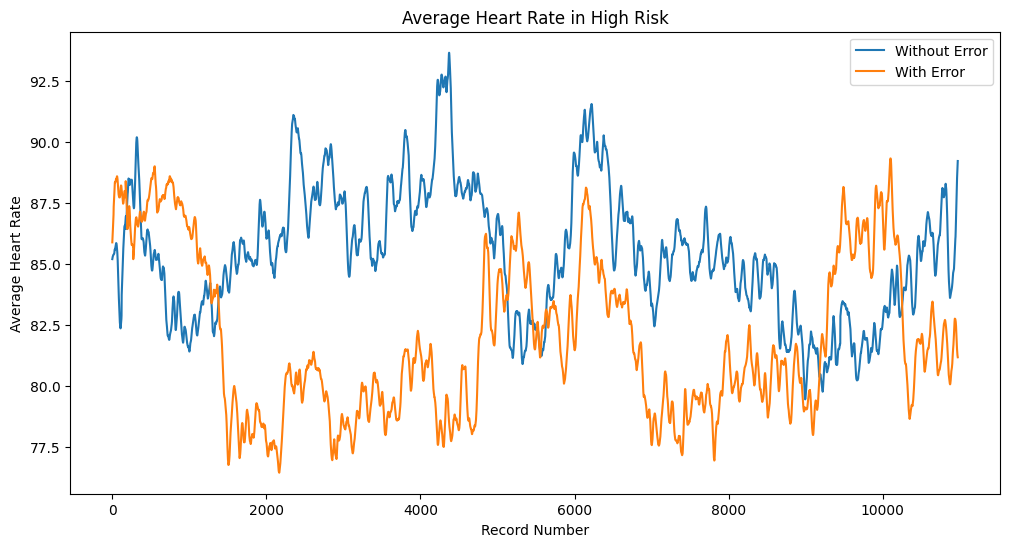

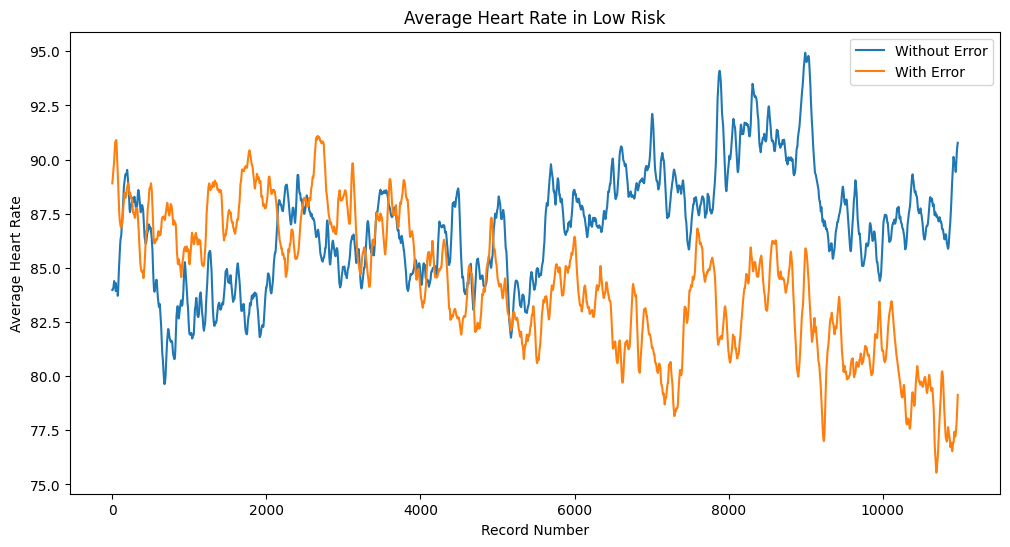

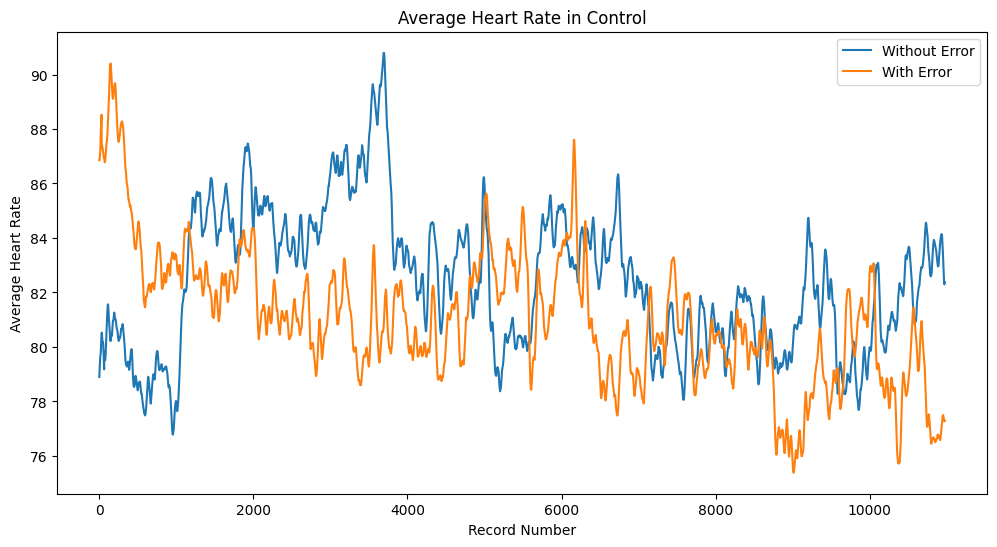

In [ ]:
# prompt: plot average heart rate with error and without error in HR


plt.figure(figsize=(12, 6))
plt.plot(average_HRate_HR_nE, label='Without Error')
plt.plot(average_HRate_HR_E, label='With Error')
plt.xlabel('Record Number')
plt.ylabel('Average Heart Rate')
plt.title('Average Heart Rate in High Risk')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(average_HRate_LR_nE, label='Without Error')
plt.plot(average_HRate_LR_E, label='With Error')
plt.xlabel('Record Number')
plt.ylabel('Average Heart Rate')
plt.title('Average Heart Rate in Low Risk')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(average_HRate_C_nE, label='Without Error')
plt.plot(average_HRate_C_E, label='With Error')
plt.xlabel('Record Number')
plt.ylabel('Average Heart Rate')
plt.title('Average Heart Rate in Control')
plt.legend()
plt.show()


Risk Perception
Control    24
HR         24
LR         22
Name: ID, dtype: int64

In [ ]:


# # Create histograms for each group
# for group in final_df['Risk Perception'].unique():
#   plt.figure()  # Create a new figure for each group
#   sns.histplot(final_df['EDA_Phasic'][final_df['Risk Perception'] == group], kde=True)
#   plt.title(f'Histogram of EDA_Phasic for Risk Perception {group}')
#   plt.xlabel('EDA_Phasic')
#   plt.ylabel('Frequency')
#   plt.show()

In [ ]:
# prompt: plot average phasic with error and withiut error in HR


plt.figure(figsize=(12, 6))
plt.plot(average_Phasic_HR_nE, label='Without Error')
plt.plot(average_Phasic_HR_E, label='With Error')
plt.xlim(30,)
plt.xlabel('Record Number')
plt.ylabel('Average EDA Phasic')
plt.title('Average  EDA Phasic in High Risk')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(average_Phasic_LR_nE, label='Without Error')
plt.plot(average_Phasic_LR_E, label='With Error')
plt.xlim(30,)
plt.xlabel('Record Number')
plt.ylabel('Average EDA Phasic')
plt.title('Average  EDA Phasic in Low Risk')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(average_Phasic_C_nE, label='Without Error')
plt.plot(average_Phasic_C_E, label='With Error')
plt.xlabel('Record Number')
plt.xlim(30,)
plt.ylabel('Average EDA Phasic')
plt.title('Average  EDA Phasic in Control')
plt.legend()
plt.show()


NameError: name 'average_Phasic_HR_nE' is not defined

<Figure size 1200x600 with 0 Axes>

### Subsets

In [ ]:
# prompt: split the dataset into 3 subsets based on Record number

# Assuming 'final_df' is your DataFrame and 'Record Number' is the column you want to use for splitting.

# Find the maximum 'Record Number'
max_record_number = final_df.groupby(['Risk Perception', 'Automation Error'])['Record Number'].max()
print(max_record_number.min())
split_num = max_record_number.min()

# Calculate the split points (approximately equal subsets)
split_point1 = int(split_num / 3)
split_point2 = int(2 * split_num / 3)

# Create the subsets
subset1 = final_df[final_df['Record Number'] <= split_point1]
subset2 = final_df[(final_df['Record Number'] > split_point1) & (final_df['Record Number'] <= split_point2)]
subset3 = final_df[final_df['Record Number'] > split_point2]

# Now you have three subsets: subset1, subset2, and subset3.


16695


In [ ]:
aov = pg.mixed_anova(dv='EDA_Phasic_norm', between='Risk Perception', within='Automation Error', subject='ID', data=subset1).round(3)
print(aov)

             Source     SS  DF1  DF2     MS      F  p-unc    np2  eps
0   Risk Perception  0.002    2   67  0.001  0.057  0.945  0.002  NaN
1  Automation Error  0.000    1   67  0.000  0.658  0.420  0.010  1.0
2       Interaction  0.000    2   67  0.000  0.441  0.645  0.013  NaN


In [ ]:
aov = pg.mixed_anova(dv='Heart Rate_mean', between='Risk Perception', within='Automation Error', subject='ID', data=subset1).round(3)
print(aov)

             Source       SS  DF1  DF2       MS      F  p-unc    np2  eps
0   Risk Perception  245.515    2   67  122.757  0.254  0.776  0.008  NaN
1  Automation Error   72.936    1   67   72.936  0.652  0.422  0.010  1.0
2       Interaction  207.390    2   67  103.695  0.927  0.401  0.027  NaN


In [ ]:
#post-hoc comparisons
posthoc_result = pg.pairwise_tests(data=subset1, between='Risk Perception', dv='EDA_Phasic_norm',within='Automation Error',subject='ID').round(3)
print(posthoc_result.round(3))

                             Contrast Automation Error           A  \
0                    Automation Error                -  With Error   
1                     Risk Perception                -     Control   
2                     Risk Perception                -     Control   
3                     Risk Perception                -          HR   
4  Automation Error * Risk Perception       With Error     Control   
5  Automation Error * Risk Perception       With Error     Control   
6  Automation Error * Risk Perception       With Error          HR   
7  Automation Error * Risk Perception    Without Error     Control   
8  Automation Error * Risk Perception    Without Error     Control   
9  Automation Error * Risk Perception    Without Error          HR   

               B Paired Parametric  U-val   W-val alternative  p-unc  hedges  
0  Without Error   True      False    NaN  1117.0   two-sided  0.464  -0.011  
1             HR  False      False  296.0     NaN   two-sided  0.877  -

In [ ]:
df_id = subset1[subset1['ID']==68]

Text(0.5, 1.0, 'Mean HEART RATE and EDA_phasic during "With Error" (subset1)')

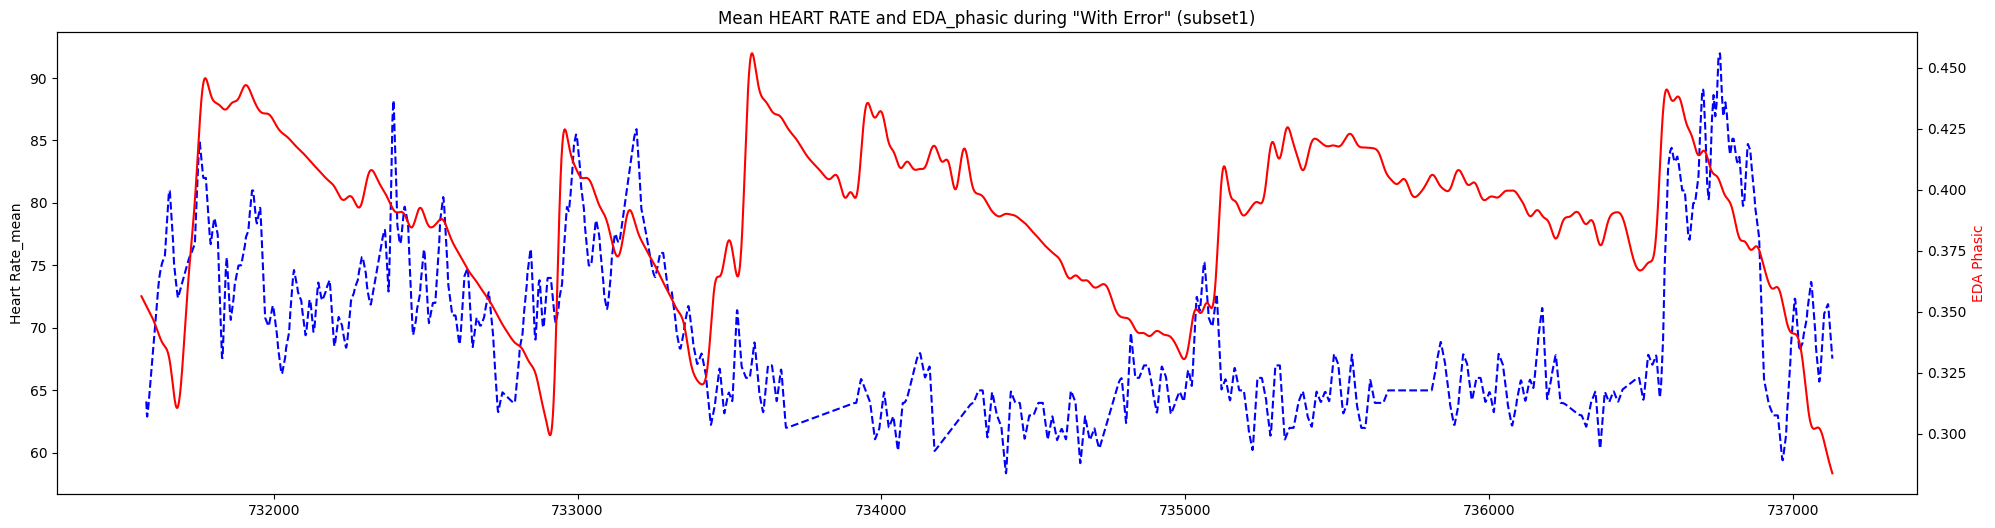

In [ ]:
# Create a wider figure
fig, ax = plt.subplots(figsize=(24, 6))

# Plot the first set of data

ax.plot( df_id[df_id['Automation Error']=='With Error']['Heart Rate_mean'],  color='b',markersize = 5,linestyle='--') #marker='s'
ax.set_ylabel('Heart Rate_mean')

ax2= ax.twinx()

# Plot the second set of data on the same axis, stacked on top of the first set

ax2.plot(df_id[df_id['Automation Error']=='With Error']['EDA_Phasic_norm'], label='Phasic', color='r',markersize = 5,linestyle='solid') #marker='o'


ax2.set_ylabel('EDA Phasic',color='r')

plt.title('Mean HEART RATE and EDA_phasic during "With Error" (subset1)')


Text(0.5, 1.0, 'Mean HEART RATE and EDA_phasic during Without Error (subset1)')

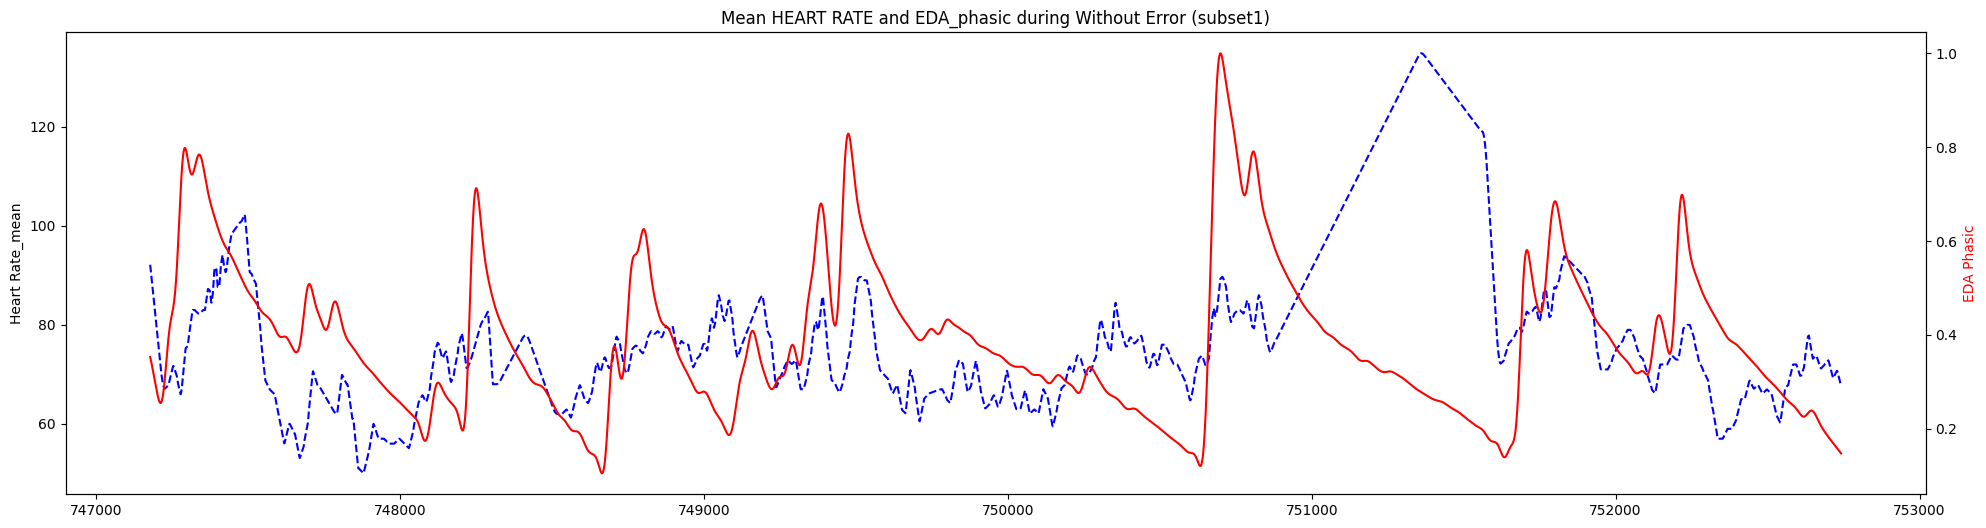

In [ ]:
# Create a wider figure
fig, ax = plt.subplots(figsize=(24, 6))

# Plot the first set of data

ax.plot( df_id[df_id['Automation Error']=='Without Error']['Heart Rate_mean'],  color='b',markersize = 5,linestyle='--') #marker='s'
ax.set_ylabel('Heart Rate_mean')

ax2= ax.twinx()

# Plot the second set of data on the same axis, stacked on top of the first set

ax2.plot(df_id[df_id['Automation Error']=='Without Error']['EDA_Phasic_norm'], color='r',markersize = 5,linestyle='solid') #marker='o'


ax2.set_ylabel('EDA Phasic',color='r')

plt.title('Mean HEART RATE and EDA_phasic during Without Error (subset1)')


In [ ]:
df_id.groupby(['Risk Perception','Automation Error'])['EDA_Phasic_norm'].count()

Risk Perception  Automation Error
HR               With Error          4483
                 Without Error       2313
Name: EDA_Phasic_norm, dtype: int64

In [ ]:
df_id[df_id['Automation Error']=='Without Error']['EDA_Phasic_norm'].max()

0.3832830542649188

In [ ]:
x = final_df.groupby(['Risk Perception','Automation Error'])['Record Number'].max()
x

Risk Perception  Automation Error
Control          With Error          18075
                 Without Error       16695
HR               With Error          18821
                 Without Error       17650
LR               With Error          20164
                 Without Error       19655
Name: Record Number, dtype: int64

In [ ]:
x = final_df.groupby(['Automation Error'])['Record Number'].
x

Automation Error
With Error       16271
Without Error    16271
Name: Record Number, dtype: int64

In [ ]:
final_df[(final_df['Automation Error']=='With Error') & (final_df['Record Number']==16271)]['Heart Rate_mean'].count()

35

# ANOVAs

In [ ]:
cols = final_df.loc[:,['EDA_Raw', 'Heart Rate_raw', 'Heart Rate_cleaned', 'Heart Rate_mean',
       'Heart Rate_std',
       'EDA_Clean', 'EDA_Tonic', 'EDA_Tonic_norm', 'EDA_Phasic',
       'EDA_Phasic_norm', 'SCR_Onsets', 'SCR_Peaks',
       'SCR_Height', 'SCR_Amplitude', 'SCR_RiseTime']].columns
print(cols)

Index(['EDA_Raw', 'Heart Rate_raw', 'Heart Rate_cleaned', 'Heart Rate_mean',
       'Heart Rate_std', 'EDA_Clean', 'EDA_Tonic', 'EDA_Tonic_norm',
       'EDA_Phasic', 'EDA_Phasic_norm', 'SCR_Onsets', 'SCR_Peaks',
       'SCR_Height', 'SCR_Amplitude', 'SCR_RiseTime'],
      dtype='object')


In [ ]:
final_df.shape

(0, 30)

In [ ]:
import pandas as pd
import numpy as np

# Load the data
df = final_df# pd.read_csv('physiologicalData_norm_Nov8_clean.csv')

# Check distribution considering Risk Perception as between-subjects factor
balance_check = df.groupby(['ID', 'Risk Perception', 'Automation Error']).size().reset_index(name='count')

# First, verify that each participant has only one Risk Perception level
rp_per_participant = df.groupby('ID')['Risk Perception'].nunique()
print("Number of Risk Perception levels per participant:")
print(rp_per_participant.value_counts())

# Check if participants have both Automation Error conditions within their Risk Perception group
ae_per_participant = balance_check.groupby('ID').size()
print("\
Number of Automation Error conditions per participant:")
print(ae_per_participant.value_counts())

# Find participants with complete data (both Automation Error conditions)
complete_participants = ae_per_participant[ae_per_participant == 2].index

# Create balanced dataset
balanced_df = df[df['ID'].isin(complete_participants)].copy()

# Show final distribution
final_balance = balanced_df.groupby(['Risk Perception', 'Automation Error']).agg({
    'ID': 'nunique',
    'Heart Rate_mean': 'count'
}).reset_index()

print("\
Final distribution in balanced dataset:")
print(final_balance.rename(columns={'ID': 'Num_Participants', 'Heart Rate_mean': 'Observations'}))

Number of Risk Perception levels per participant:
Risk Perception
1    70
Name: count, dtype: int64
Number of Automation Error conditions per participant:
2    70
Name: count, dtype: int64
Final distribution in balanced dataset:
  Risk Perception Automation Error  Num_Participants  Observations
0         Control       With Error                24        330205
1         Control    Without Error                24        298126
2              HR       With Error                24        328507
3              HR    Without Error                24        294868
4              LR       With Error                22        297329
5              LR    Without Error                22        272471


In [ ]:
from scipy.stats import zscore

# Identify numerical columns for outlier detection
numerical_columns = final_df.select_dtypes(include=['float64', 'int64']).columns

# Calculate z-scores for numerical columns
z_scores = final_df[numerical_columns].apply(zscore)

# Filter out rows with z-scores greater than 3 or less than -3
filtered_df = final_df[(z_scores.abs() <= 3).all(axis=1)]

# Compare the size of the dataset before and after outlier removal
print("Original dataset size:", final_df.shape)
print("Filtered dataset size:", final_df.shape)

Original dataset size: (1821506, 33)
Filtered dataset size: (1821506, 33)


In [ ]:
for feature in cols:
  print(f'\n\n -------#------- {feature}----------\n\n')
  #aov = pg.anova(dv='EDA_Phasic', between='Group',data=final_df)
  aov = pg.mixed_anova(dv=feature, between='Risk Perception', within='Automation Error', subject='ID', data=final_df).round(3)

  # Print the result
  print(aov)



 -------#------- EDA_Raw----------


             Source       SS  DF1  DF2      MS      F  p-unc    np2  eps
0   Risk Perception  161.041    2   67  80.520  0.918  0.404  0.027  NaN
1  Automation Error    6.507    1   67   6.507  0.410  0.524  0.006  1.0
2       Interaction   21.679    2   67  10.839  0.684  0.508  0.020  NaN


 -------#------- Heart Rate_raw----------


             Source       SS  DF1  DF2       MS      F  p-unc    np2  eps
0   Risk Perception  187.242    2   67   93.621  0.100  0.905  0.003  NaN
1  Automation Error  172.459    1   67  172.459  3.672  0.060  0.052  1.0
2       Interaction   16.400    2   67    8.200  0.175  0.840  0.005  NaN


 -------#------- Heart Rate_cleaned----------


             Source       SS  DF1  DF2       MS      F  p-unc    np2  eps
0   Risk Perception  380.893    2   67  190.447  0.456  0.636  0.013  NaN
1  Automation Error  258.697    1   67  258.697  5.826  0.019  0.080  1.0
2       Interaction   14.764    2   67    7.382  0.166 

## MixedML

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:

df = final_df.copy()
# df['Risk_Perception'] = df['Risk Perception']
# df['Automation_Error'] = df['Automation Error']

df.columns = [col.replace(' ', '_').capitalize() for col in df.columns]
cols = ['Eda_raw', 'Heart_rate_raw',
       'Heart_rate_cleaned', 'Heart_rate_mean', 'Eda_clean',
       'Eda_tonic',  'Eda_tonic_norm', 'Eda_phasic', 'Eda_phasic_norm']#, 'Scr_peaks', 'Scr_amplitude','Scr_recoverytime']#df.columns[7:27]
# print(df.columns)

   # Ensure both feature and Automation_Error are of appropriate type for regression
# df[feature] = pd.to_numeric(df[feature], errors='coerce') # Convert feature to numeric if possible, handling errors
# df['Automation_Error'] = pd.Categorical(df['Automation_Error']) # Convert Automation_Error to categorical type

for feature in cols:
  # Define the mixed model formula
  formula = f'{feature}~ Risk_perception * Automation_error'



  # Fit the mixed model
  mixed_model = smf.mixedlm(formula, data=df, groups=df['Id']).fit()

  # Print the model summary
  print(mixed_model.summary())

                               Mixed Linear Model Regression Results
Model:                           MixedLM              Dependent Variable:              Eda_raw      
No. Observations:                1821506              Method:                          REML         
No. Groups:                      70                   Scale:                           13.5173      
Min. group size:                 19307                Log-Likelihood:                  -4956573.9779
Max. group size:                 26597                Converged:                       Yes          
Mean group size:                 26021.5                                                            
----------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.    z     P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------------
Intercept             

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                              Mixed Linear Model Regression Results
Model:                          MixedLM              Dependent Variable:              Eda_phasic  
No. Observations:               1821506              Method:                          REML        
No. Groups:                     70                   Scale:                           0.0937      
Min. group size:                19307                Log-Likelihood:                  -428423.7493
Max. group size:                26597                Converged:                       Yes         
Mean group size:                26021.5                                                           
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                              Mixed Linear Model Regression Results
Model:                         MixedLM             Dependent Variable:             Eda_phasic_norm
No. Observations:              1821506             Method:                         REML           
No. Groups:                    70                  Scale:                          0.0028         
Min. group size:               19307               Log-Likelihood:                 2777620.5658   
Max. group size:               26597               Converged:                      Yes            
Mean group size:               26021.5                                                            
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

In [ ]:
# after Nov 7

df = final_df.copy()
# df['Risk_Perception'] = df['Risk Perception']
# df['Automation_Error'] = df['Automation Error']

df.columns = [col.replace(' ', '_').capitalize() for col in df.columns]
cols = ['Eda_raw', 'Heart_rate_raw',
       'Heart_rate_cleaned', 'Heart_rate_mean', 'Eda_clean',
       'Eda_tonic',  'Eda_tonic_norm', 'Eda_phasic', 'Eda_phasic_norm', 'Scr_peaks', 'Scr_amplitude','Scr_recoverytime', 'Record_number']#df.columns[7:27]
# print(df.columns)

   # Ensure both feature and Automation_Error are of appropriate type for regression
# df[feature] = pd.to_numeric(df[feature], errors='coerce') # Convert feature to numeric if possible, handling errors
# df['Automation_Error'] = pd.Categorical(df['Automation_Error']) # Convert Automation_Error to categorical type

for feature in cols:
  # Define the mixed model formula
  formula = f'{feature}~ Risk_perception * Automation_error + (1|Id)'



  # Fit the mixed model
  mixed_model = smf.mixedlm(formula, data=df, groups=df['Id']).fit()

  # Print the model summary
  print(mixed_model.summary())

                               Mixed Linear Model Regression Results
Model:                           MixedLM              Dependent Variable:              Eda_raw      
No. Observations:                2187758              Method:                          REML         
No. Groups:                      70                   Scale:                           14.1931      
Min. group size:                 22392                Log-Likelihood:                  -6006492.7499
Max. group size:                 39779                Converged:                       Yes          
Mean group size:                 31253.7                                                            
----------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.    z     P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------------
Intercept             

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

                              Mixed Linear Model Regression Results
Model:                          MixedLM              Dependent Variable:              Eda_phasic  
No. Observations:               2187758              Method:                          REML        
No. Groups:                     70                   Scale:                           0.0855      
Min. group size:                22392                Log-Likelihood:                  -413716.6229
Max. group size:                39779                Converged:                       No          
Mean group size:                31253.7                                                           
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                              Mixed Linear Model Regression Results
Model:                         MixedLM             Dependent Variable:             Eda_phasic_norm
No. Observations:              2187758             Method:                         REML           
No. Groups:                    70                  Scale:                          0.0034         
Min. group size:               22392               Log-Likelihood:                 3112978.6845   
Max. group size:               39779               Converged:                      Yes            
Mean group size:               31253.7                                                            
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                              Mixed Linear Model Regression Results
Model:                          MixedLM              Dependent Variable:              Scr_peaks   
No. Observations:               2187758              Method:                          REML        
No. Groups:                     70                   Scale:                           0.0002      
Min. group size:                22392                Log-Likelihood:                  6294460.2362
Max. group size:                39779                Converged:                       Yes         
Mean group size:                31253.7                                                           
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                              Mixed Linear Model Regression Results
Model:                         MixedLM              Dependent Variable:              Scr_amplitude
No. Observations:              2187758              Method:                          REML         
No. Groups:                    70                   Scale:                           0.0005       
Min. group size:               22392                Log-Likelihood:                  5304884.7256 
Max. group size:               39779                Converged:                       Yes          
Mean group size:               31253.7                                                            
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                              Mixed Linear Model Regression Results
Model:                        MixedLM             Dependent Variable:             Scr_recoverytime
No. Observations:             2187758             Method:                         REML            
No. Groups:                   70                  Scale:                          0.3920          
Min. group size:              22392               Log-Likelihood:                 -2080066.0301   
Max. group size:              39779               Converged:                      Yes             
Mean group size:              31253.7                                                             
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

In [ ]:
for feature in cols:
  # Create an interaction plot using seaborn
  sns.lineplot(data=df,  y=feature, x='Risk Perception', hue='Automation Error')

  # Customize the plot
  # plt.title('Interaction Effect of Risk Perception and Automation Error on EDA Phasic Norm')
  plt.legend('Automation Error')
  plt.ylabel(feature)
  plt.xlabel(title=('Risk Perception'))
  plt.tight_layout()

  # Show the plot
  plt.show()

ValueError: Could not interpret value `Risk Perception` for `x`. An entry with this name does not appear in `data`.

# Test

In [ ]:
df8['EDA_Phasic'].max()

3.791307457029268

In [ ]:
# normalize the EDA_Phasic in final_df in the range of (0,1) for every participant

from sklearn.preprocessing import MinMaxScaler

# Group data by participant ID
for participant_id in final_df['ID'].unique():
  participant_data = final_df[final_df['ID'] == participant_id]

  # Extract EDA_Phasic values for the participant
  eda_phasic_values = participant_data['EDA_Phasic'].values.reshape(-1, 1)

  # Initialize the scaler
  scaler = MinMaxScaler()

  # Fit and transform the EDA_Phasic values
  normalized_eda_phasic = scaler.fit_transform(eda_phasic_values)

  # Update the 'EDA_Phasic' column in the DataFrame for the participant
  final_df.loc[final_df['ID'] == participant_id, 'EDA_Phasic_norm'] = normalized_eda_phasic.flatten()


<ipython-input-121-905c983c86aa>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.loc[final_df['ID'] == participant_id, 'EDA_Phasic_norm'] = normalized_eda_phasic.flatten()


In [ ]:
('/content/drive/MyDrive/Emotion_Em/Results/Datasets/physiologicalDataAll_Oct25_filtered.csv',index=False)

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (<ipython-input-123-428996e0b9fa>, line 1)

In [ ]:
df['Heart Rate PPG ALG']= df['Heart Rate PPG ALG'].fillna(-1)

(0.0, 100000.0)

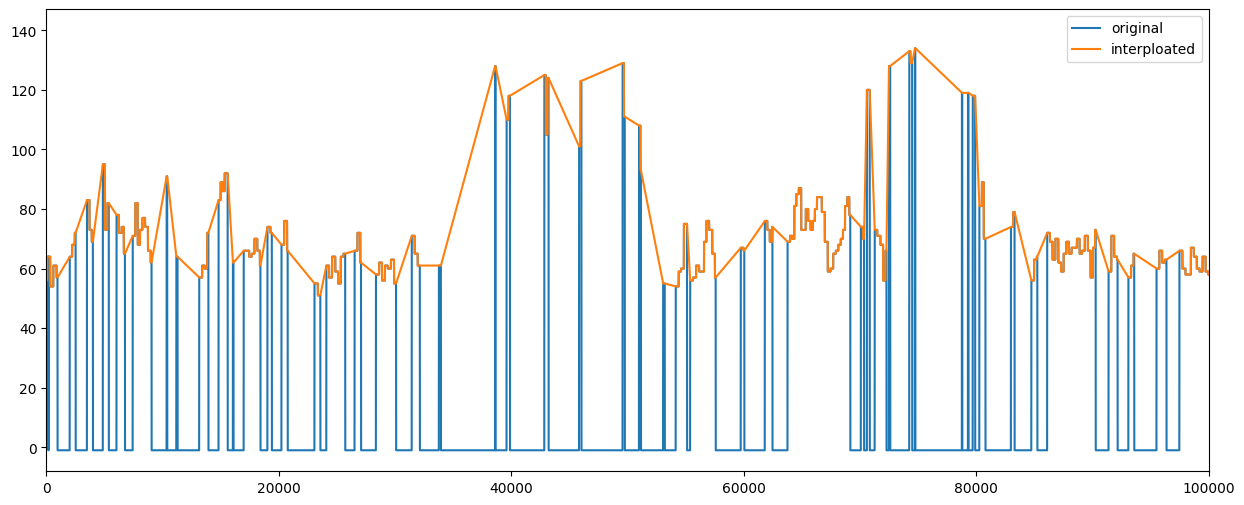

In [ ]:
fig = plt.figure(figsize=(15, 6))
plt.plot(df['Heart Rate PPG ALG'],label='original')
plt.plot(df['Heart Rate PPG ALG_int'],label = 'interploated')

plt.legend()
plt.xlim(0,100000)

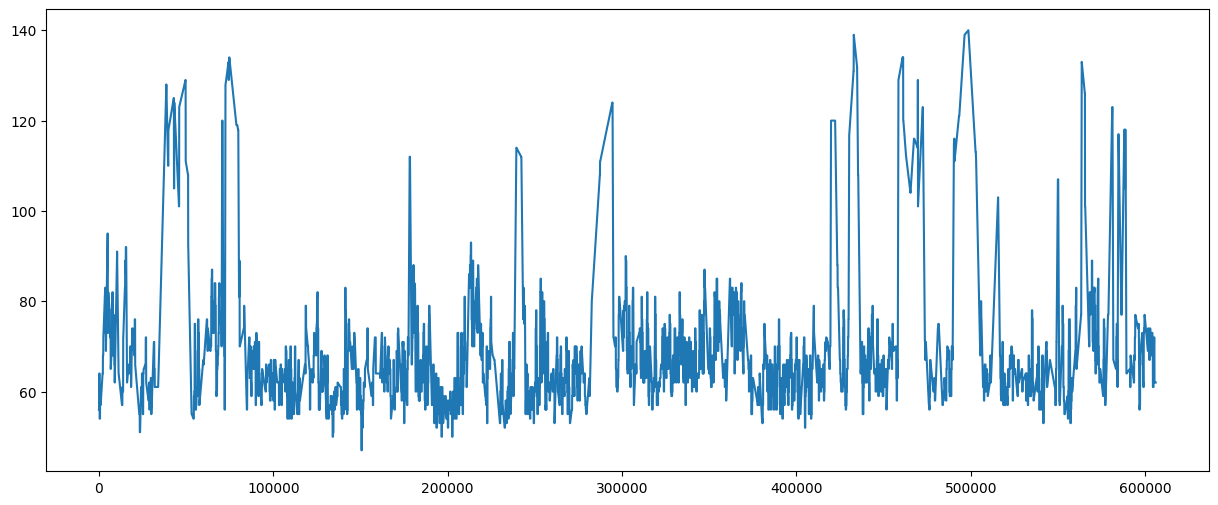

In [ ]:
fig = plt.figure(figsize=(15, 6))
plt.plot(df['Heart Rate PPG ALG_int'])


In [ ]:
df[df['Heart Rate PPG ALG'] == -1].shape

(258981, 38)

In [ ]:
df['Heart Rate_Smoothed'] = df['Heart Rate PPG ALG'].rolling(window=500).mean()

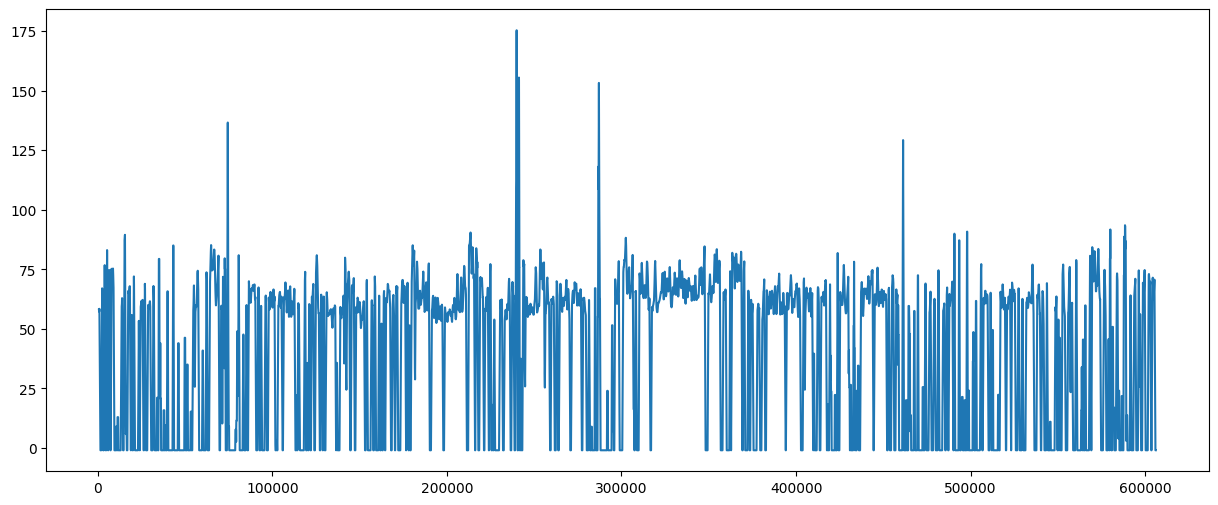

In [ ]:
fig = plt.figure(figsize=(15, 6))
plt.plot(df['Heart Rate_Smoothed'])

In [ ]:
# #  filll -1 values in df['Heart Rate PPG ALG'] with the average of last non -1 value and next non -1 value

# import numpy as np

# def fill_minus_one_with_average(df):
#   """
#   Fills -1 values in df['Heart Rate PPG ALG'] with the average of the last and next non -1 value.

#   Args:
#     df: The pandas DataFrame containing the 'Heart Rate PPG ALG' column.

#   Returns:
#     The DataFrame with filled -1 values.
#   """
#   hr_column = df['Heart Rate PPG ALG'].copy()
#   for i in range(len(hr_column)):
#     if hr_column[i] == -1:
#       last_valid_value = np.nan
#       next_valid_value = np.nan

#       # Find the last valid value before the -1
#       for j in range(i - 1, -1, -1):
#         if hr_column[j] != -1:
#           last_valid_value = hr_column[j]
#           break

#       # Find the next valid value after the -1
#       for j in range(i + 1, len(hr_column)):
#         if hr_column[j] != -1:
#           next_valid_value = hr_column[j]
#           break

#       if np.isnan(last_valid_value) and np.isnan(next_valid_value):
#         # If no valid values are found, keep -1
#         continue
#       elif np.isnan(last_valid_value):
#         hr_column[i] = next_valid_value
#       elif np.isnan(next_valid_value):
#         hr_column[i] = last_valid_value
#       else:
#         hr_column[i] = (last_valid_value + next_valid_value) / 2

#   df['Heart Rate PPG ALG_int'] = hr_column
#   return df


# Example usage:
# df = fill_minus_one_with_average(df)


In [ ]:
df1 = fill_minus_one_with_average(df)

KeyboardInterrupt: 

In [ ]:

plt.plot(df['Heart Rate PPG ALG_int'])

## Resampling

In [ ]:
resampled_df = final_df.copy()
resampled_df.drop_duplicates(subset=['Time'], keep='first',inplace=True)
resampled_df.shape

(2115214, 31)

In [ ]:
resampled_df.dropna(inplace=True)

In [ ]:

resampled_df['Time'] = pd.to_datetime(resampled_df['time'],format='%H:%M:%S.%f')
resampled_df = resampled_df.set_index('Time')

In [ ]:
resampled_df

Risk Perception Automation Error  ID  System Timestamp CAL  \
Time                                                                         
13:21:03.229000              HR    Without Error  55          1.723051e+12   
13:21:03.291000              HR    Without Error  55          1.723051e+12   
13:21:03.354000              HR    Without Error  55          1.723051e+12   
13:21:03.416000              HR    Without Error  55          1.723051e+12   
13:21:03.479000              HR    Without Error  55          1.723051e+12   
...                         ...              ...  ..                   ...   
14:13:27.108000         Control    Without Error  72          1.725042e+12   
14:13:27.171000         Control    Without Error  72          1.725042e+12   
14:13:27.233000         Control    Without Error  72          1.725042e+12   
14:13:27.296000         Control    Without Error  72          1.725042e+12   
14:13:27.358000         Control    Without Error  72          1.725042e+12   

                 Timestamp RAW        Date    EDA_Raw  Heart Rate_raw  \
Time                                                                    
13:21:03.229000      6120102.0  2024-08-07  13.944940           102.0   
13:21:03.291000      6122150.0  2024-08-07  14.067466           103.0   
13:21:03.354000      6124198.0  2024-08-07  14.184886           103.0   
13:21:03.416000      6126246.0  2024-08-07  14.271675           103.0   
13:21:03.479000      6128294.0  2024-08-07  14.368674           103.0   
...                        ...         ...        ...             ...   
14:13:27.108000      9577004.0  2024-08-30   6.016515            57.0   
14:13:27.171000      9579052.0  2024-08-30   6.011410            57.0   
14:13:27.233000      9581100.0  2024-08-30   6.006305            57.0   
14:13:27.296000      9583148.0  2024-08-30   6.006305            57.0   
14:13:27.358000      9585196.0  2024-08-30   6.006305            57.0   

                 Heart Rate_cleaned  Heart Rate_mean  ...  SCR_Peaks  \
Time                                                  ...              
13:21:03.229000               102.0       102.488281  ...          0   
13:21:03.291000               103.0       102.441406  ...          0   
13:21:03.354000               103.0       102.441406  ...          0   
13:21:03.416000               103.0       102.441406  ...          0   
13:21:03.479000               103.0       102.441406  ...          0   
...                             ...              ...  ...        ...   
14:13:27.108000                57.0        57.246094  ...          0   
14:13:27.171000                57.0        57.183594  ...          0   
14:13:27.233000                57.0        57.121094  ...          0   
14:13:27.296000                57.0        57.058594  ...          0   
14:13:27.358000                57.0        57.000000  ...          0   

                 SCR_Height  SCR_Amplitude  SCR_RiseTime  SCR_Recovery  \
Time                                                                     
13:21:03.229000         0.0            0.0           0.0             0   
13:21:03.291000         0.0            0.0           0.0             0   
13:21:03.354000         0.0            0.0           0.0             0   
13:21:03.416000         0.0            0.0           0.0             0   
13:21:03.479000         0.0            0.0           0.0             0   
...                     ...            ...           ...           ...   
14:13:27.108000         0.0            0.0           0.0             0   
14:13:27.171000         0.0            0.0           0.0             0   
14:13:27.233000         0.0            0.0           0.0             0   
14:13:27.296000         0.0            0.0           0.0             0   
14:13:27.358000         0.0            0.0           0.0             0   

                 SCR_RecoveryTime  EDA_Phasic_abs             time  \
Time                                                                 
13:21:03.22

In [ ]:
resampled_df.dropna(inplace=True)

In [ ]:
resampled = resampled_df.iloc[:,[2,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]]
resampled.head(2)

ID    EDA_Raw  Heart Rate_raw  Heart Rate_cleaned  \
Time                                                                         
1900-01-01 13:21:03.229  55  13.944940           102.0               102.0   
1900-01-01 13:21:03.291  55  14.067466           103.0               103.0   

                         Heart Rate_mean  Heart Rate_max  Heart Rate_min  \
Time                                                                       
1900-01-01 13:21:03.229       102.488281           103.0           102.0   
1900-01-01 13:21:03.291       102.441406           103.0           102.0   

                         Heart Rate_std  IBI PPG ALG  EDA_Clean  ...  \
Time                                                             ...   
1900-01-01 13:21:03.229        0.500842         -1.0  13.967207  ...   
1900-01-01 13:21:03.291        0.497528         -1.0  14.034293  ...   

                         EDA_Phasic  N_Video  P_Video  SCR_Onsets  SCR_Peaks  \
Time                                                                           
1900-01-01 13:21:03.229    0.545448      0.0      1.0           0          0   
1900-01-01 13:21:03.291    0.611166      0.0      1.0           0          0   

                         SCR_Height  SCR_Amplitude  SCR_RiseTime  \
Time                                                               
1900-01-01 13:21:03.229         0.0            0.0           0.0   
1900-01-01 13:21:03.291         0.0            0.0           0.0   

                         SCR_Recovery  SCR_RecoveryTime  
Time                                                     
1900-01-01 13:21:03.229             0               0.0  
1900-01-01 13:21:03.291             0               0.0  

[2 rows x 21 columns]

In [ ]:
resampled.isna().sum()

ID                    0
EDA_Raw               0
Heart Rate_raw        0
Heart Rate_cleaned    0
Heart Rate_mean       0
Heart Rate_max        0
Heart Rate_min        0
Heart Rate_std        0
IBI PPG ALG           0
EDA_Clean             0
EDA_Tonic             0
EDA_Phasic            0
N_Video               0
P_Video               0
SCR_Onsets            0
SCR_Peaks             0
SCR_Height            0
SCR_Amplitude         0
SCR_RiseTime          0
SCR_Recovery          0
SCR_RecoveryTime      0
dtype: int64

In [ ]:
#resampled.index = pd.to_datetime(resampled.index)
new_df = resampled.resample('s').mean()
new_df.reset_index(inplace=True)
new_df

Time    ID    EDA_Raw  Heart Rate_raw  \
0     1900-01-01 07:55:17  54.0   7.585864        101.0000   
1     1900-01-01 07:55:18  54.0   7.834297        100.6250   
2     1900-01-01 07:55:19  54.0   7.942783         90.6875   
3     1900-01-01 07:55:20  54.0   7.789945         79.6875   
4     1900-01-01 07:55:21  54.0   7.733469         74.0000   
...                   ...   ...        ...             ...   
39811 1900-01-01 18:58:48   6.0  15.822070         66.3750   
39812 1900-01-01 18:58:49   6.0  15.787610         65.5000   
39813 1900-01-01 18:58:50   6.0  15.761764         68.8125   
39814 1900-01-01 18:58:51   6.0  15.735919         67.0000   
39815 1900-01-01 18:58:52   6.0  15.706755         64.0000   

       Heart Rate_cleaned  Heart Rate_mean  Heart Rate_max  Heart Rate_min  \
0                101.0000        95.183594        101.0000         88.9000   
1                100.6250       101.484863        104.0000         96.9375   
2                 90.6875        95.556641        100.6250         90.6875   
3                 79.6875        84.861084         90.6875         79.6875   
4                 74.0000        76.155029         79.6875         74.0000   
...                   ...              ...             ...             ...   
39811             66.3750        67.289062         68.0000         66.3750   
39812             65.5000        65.562500         66.6250         65.0000   
39813             68.8125        67.398682         69.0000         65.3750   
39814             67.0000        68.241943         68.8125         67.0000   
39815             64.0000        65.859375         68.0000         64.0000   

       Heart Rate_std  IBI PPG ALG  ...  EDA_Phasic  N_Video  P_Video  \
0            4.262037    -1.000000  ...   -0.010914    0.000      0.0   
1            2.768390    -1.000000  ...    0.199437    0.000      0.0   
2            3.858832    -1.000000  ...    0.292934    0.000      0.0   
3            3.614775    -1.000000  ...    0.135853    0.625      0.0   
4            2.320294    -1.000000  ...    0.063285    1.000      0.0   
...               ...          ...  ...         ...      ...      ...   
39811        0.702230    -1.000000  ...   -0.014513    0.000      0.0   
39812        0.518677    -1.000000  ...   -0.022233    0.000      0.0   
39813        1.517909    -1.000000  ...   -0.017464    0.000      0.0   
39814        0.599239    57.412109  ...   -0.016005    0.000      0.0   
39815        1.859812    -1.000000  ...   -0.012789    0.000      0.0   

       SCR_Onsets  SCR_Peaks  SCR_Height  SCR_Amplitude  SCR_RiseTime  \
0             0.0        0.0         0.0            0.0           0.0   
1             0.0        0.0         0.0            0.0           0.0   
2             0.0        0.0         0.0            0.0           0.0   
3             0.0        0.0         0.0            0.0           0.0   
4             0.0        0.0         0.0            0.0           0.0   
...           ...        ...         ...            ...           ...   
39811         0.0        0.0         0.0            0.0           0.0   
39812         0.0        0.0         0.0            0.0           0.0   
39813         0.0        0.0         0.0            0.0           0.0   
39814         0.0        0.0         0.0            0.0           0.0   
39815         0.0        0.0         0.0            0.0           0.0   

       SCR_Recovery  SCR_RecoveryTime  
0               0.0               0.0  
1               0.0               0.0  
2               0.0               0.0  
3               0.0               0.0  
4               0.0               0.0  
...             ...               ...  
39811           0.0               0.0  
39812           0.0               0.0  
39813           0.0               0.0  
39814           0.0               0.0  
39815           0.0               0.0  

[39816 rows x 22 columns]

In [ ]:
#new_df.ffill(inplace=True)
new_df.dropna(inplace=True)

In [ ]:
# new_df[new_df.isna()]
new_df.isna().sum()

Time                  0
ID                    0
EDA_Raw               0
Heart Rate_raw        0
Heart Rate_cleaned    0
Heart Rate_mean       0
Heart Rate_max        0
Heart Rate_min        0
Heart Rate_std        0
IBI PPG ALG           0
EDA_Clean             0
EDA_Tonic             0
EDA_Phasic            0
N_Video               0
P_Video               0
SCR_Onsets            0
SCR_Peaks             0
SCR_Height            0
SCR_Amplitude         0
SCR_RiseTime          0
SCR_Recovery          0
SCR_RecoveryTime      0
dtype: int64

In [ ]:
new_df['ID'] = new_df['ID'].astype(int)

In [ ]:
#df8 = new_df[new_df['ID'] == 12]
df8 = resampled_df[resampled_df['ID'] == 12]

In [ ]:
df8.tail(100)

Risk Perception Automation Error  ID  \
Time                                                           
1900-01-01 15:52:36.662              LR       With Error  12   
1900-01-01 15:52:36.724              LR       With Error  12   
1900-01-01 15:52:36.787              LR       With Error  12   
1900-01-01 15:52:36.849              LR       With Error  12   
1900-01-01 15:52:36.912              LR       With Error  12   
...                                 ...              ...  ..   
1900-01-01 15:52:42.599              LR       With Error  12   
1900-01-01 15:52:42.662              LR       With Error  12   
1900-01-01 15:52:42.724              LR       With Error  12   
1900-01-01 15:52:42.787              LR       With Error  12   
1900-01-01 15:52:42.849              LR       With Error  12   

                         System Timestamp CAL  Timestamp RAW        Date  \
Time                                                                       
1900-01-01 15:52:36.662          1.717012e+12     12276623.0  2024-05-29   
1900-01-01 15:52:36.724          1.717012e+12     12278671.0  2024-05-29   
1900-01-01 15:52:36.787          1.717012e+12     12280719.0  2024-05-29   
1900-01-01 15:52:36.849          1.717012e+12     12282767.0  2024-05-29   
1900-01-01 15:52:36.912          1.717012e+12     12284815.0  2024-05-29   
...                                       ...            ...         ...   
1900-01-01 15:52:42.599          1.717012e+12     12471183.0  2024-05-29   
1900-01-01 15:52:42.662          1.717012e+12     12473231.0  2024-05-29   
1900-01-01 15:52:42.724          1.717012e+12     12475279.0  2024-05-29   
1900-01-01 15:52:42.787          1.717012e+12     12477327.0  2024-05-29   
1900-01-01 15:52:42.849          1.717012e+12     12479375.0  2024-05-29   

                          EDA_Raw  Heart Rate_raw  Heart Rate_cleaned  \
Time                                                                    
1900-01-01 15:52:36.662  6.179883            -1.0           77.456674   
1900-01-01 15:52:36.724  6.184988            -1.0           77.475410   
1900-01-01 15:52:36.787  6.179883            -1.0           77.494145   
1900-01-01 15:52:36.849  6.179883            -1.0           77.512881   
1900-01-01 15:52:36.912  6.179883            -1.0           77.531616   
...                           ...             ...                 ...   
1900-01-01 15:52:42.599  6.154357            73.0           73.000000   
1900-01-01 15:52:42.662  6.154357            73.0           73.000000   
1900-01-01 15:52:42.724  6.154357            73.0           73.000000   
1900-01-01 15:52:42.787  6.154357            73.0           73.000000   
1900-01-01 15:52:42.849  6.149251            73.0           73.000000   

                         Heart Rate_mean  ...  SCR_Peaks  SCR_Height  \
Time                                      ...                          
1900-01-01 15:52:36.662        77.307377  ...          0         0.0   
1900-01-01 15:52:36.724        77.326112  ...          0         0.0   
1900-01-01 15:52:36.787        77.344848  ...          0         0.0   
1900-01-01 15:52:36.849        77.363583  ...          0         0.0   
1900-01-01 15:52:36.912        77.382319  ...          0         0.0   
...                                  ...  ...        ...         ...   
1900-01-01 15:52:42.599        71.500000  ...          0         0.0   
1900-01-01 15:52:42.662        71.687500  ...          0         0.0   
1900-01-01 15:52:42.724        71.875000  ...          0         0.0   
1900-01-01 15:52:42.787        72.062500  ...          0         0.0   
1900-01-01 15:52:42.849        72.250000  ...          0         0.0   

                         SCR_Amplitude  SCR_RiseTime  SCR_Recovery  \
Time                                                                 
1900-01-01 15:52:36.662            0.0           0.0             0   
1900-01-01 15:52:36.724            0.0           0.0             0   
1900-01-01 15:52:36.787            

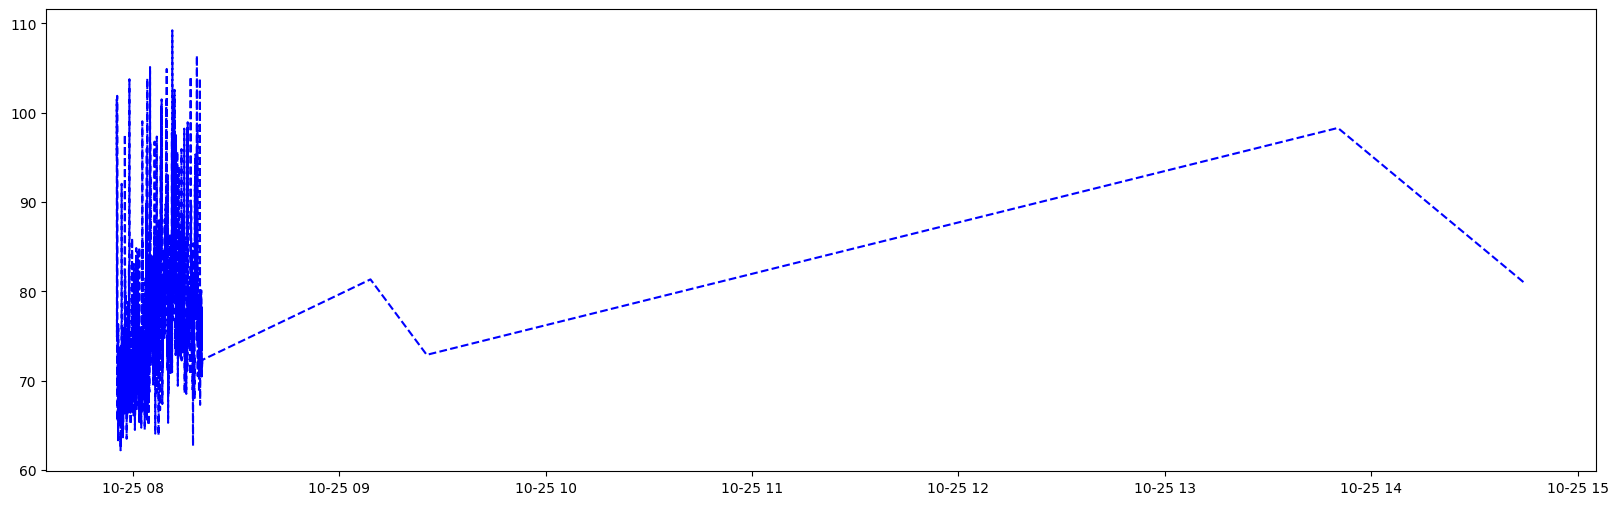

In [ ]:
fig = plt.figure(figsize=(20, 6))
plt.plot(df8['Heart Rate_mean'],  color='b',markersize = 5,linestyle='--') #marker='s'
#plt.plot(df8['Heart Rate_max'].index, df8['Heart Rate_max'],  color='r',markersize = 5,linestyle='--') #marker='s'
#plt.xticks(range(0, len(df8) + 1,100),rotation=45)

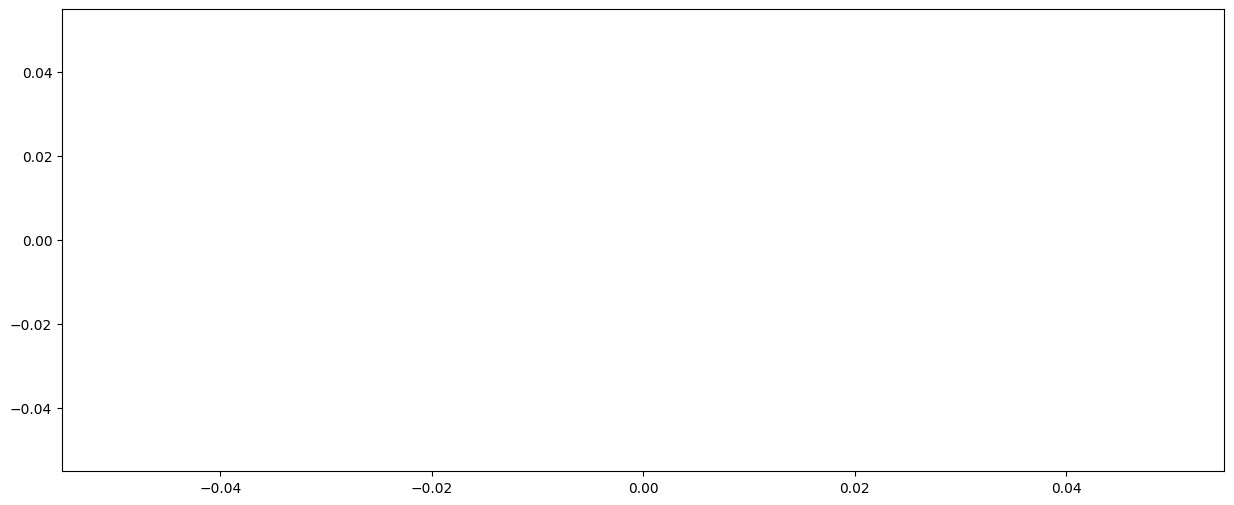

In [ ]:
fig = plt.figure(figsize=(15, 6))
plt.plot(df8[df8['SCR_Peaks']>0]['Heart Rate_mean'].index, df8[df8['SCR_Peaks']>0]['Heart Rate_mean'],  color='b',markersize = 5,linestyle='--') #marker='s'
#plt.xticks(range(0, len(df8) + 1,100),rotation=45)

## Heart Rate Anova

In [ ]:
df8[df8['N_Video']==1].shape[0]

0

NameError: name 'df8' is not defined

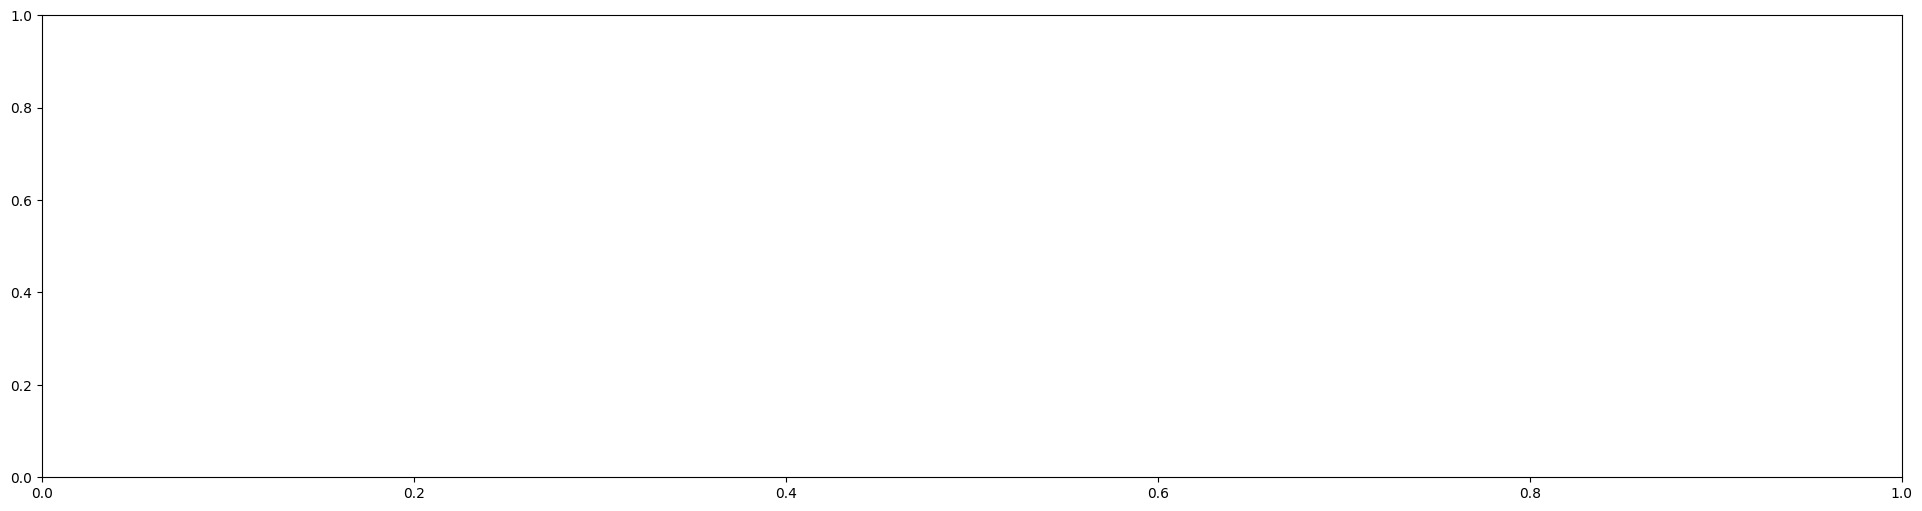

In [ ]:
# Create a wider figure
fig, ax = plt.subplots(figsize=(24, 6))

# Plot the first set of data
ax.plot(df8['Heart Rate_mean'].index, df8['Heart Rate_mean'],  color='b',markersize = 5,linestyle='--') #marker='s'
ax.set_ylabel('Heart Rate_mean')

ax2= ax.twinx()

# Plot the second set of data on the same axis, stacked on top of the first set
ax2.plot(df8['Heart Rate_mean'].index, df8['EDA_Phasic'], label='Phasic', color='r',markersize = 5,linestyle='dashdot') #marker='o'

ax2.set_ylabel('EDA Phasic',color='r')

In [ ]:
df.columns

Index(['Risk Perception', 'Automation Error', 'ID', 'System Timestamp CAL',
       'Timestamp RAW', 'Date', 'Time', 'EDA_Raw', 'Heart Rate_raw',
       'Heart Rate_cleaned', 'Heart Rate_mean', 'Heart Rate_max',
       'Heart Rate_min', 'Heart Rate_std', 'IBI PPG ALG', 'EDA_Clean',
       'EDA_Tonic', 'EDA_Phasic', 'N_Video', 'P_Video', 'SCR_Onsets',
       'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude', 'SCR_RiseTime',
       'SCR_Recovery', 'SCR_RecoveryTime', 'Record Number', 'EDA_Phasic_norm'],
      dtype='object')

In [ ]:
#------- Heart Rate
#aov = pg.anova(dv='EDA_Phasic', between='Group',data=final_df)
aov = pg.mixed_anova(dv='Heart Rate_mean', between='Risk Perception', within='Automation Error', subject='ID', data=final_df).round(3)

# Print the result
print(aov)

             Source       SS  DF1  DF2       MS      F  p-unc    np2  eps
0   Risk Perception  344.856    2   67  172.428  0.412  0.664  0.012  NaN
1  Automation Error  210.541    1   67  210.541  4.152  0.046  0.058  1.0
2       Interaction   24.716    2   67   12.358  0.244  0.784  0.007  NaN


             Source       SS  DF1  DF2       MS      F  p-unc    np2  eps
0   Risk Perception  377.420    2   67  188.710  0.440  0.646  0.013  NaN
1  Automation Error  257.779    1   67  257.779  7.796  0.007  0.104  1.0
2       Interaction    5.395    2   67    2.697  0.082  0.922  0.002  NaN


<Axes: xlabel='Risk Perception', ylabel='Heart Rate_max'>

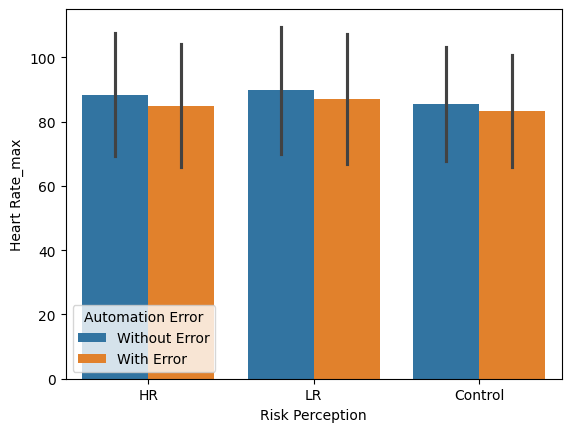

In [ ]:
#------- Heart Rate max
#aov = pg.anova(dv='EDA_Phasic', between='Group',data=final_df)
aov = pg.mixed_anova(dv='Heart Rate_max', between='Risk Perception', within='Automation Error', subject='ID', data=final_df).round(3)

# Print the result
print(aov)

sns.barplot(data=final_df, y='Heart Rate_max',hue='Automation Error',x='Risk Perception',errorbar='sd')

             Source       SS  DF1  DF2       MS      F  p-unc    np2  eps
0   Risk Perception  295.985    2   67  147.992  0.356  0.702  0.011  NaN
1  Automation Error  203.781    1   67  203.781  3.864  0.053  0.055  1.0
2       Interaction   20.507    2   67   10.254  0.194  0.824  0.006  NaN


<Axes: xlabel='Risk Perception', ylabel='Heart Rate_min'>

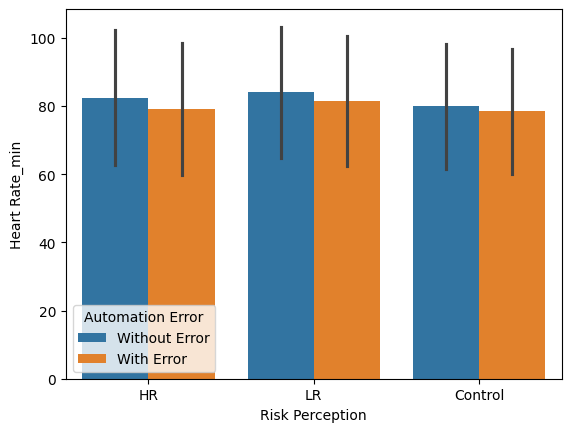

In [ ]:
#------- Heart Rate min
#aov = pg.anova(dv='EDA_Phasic', between='Group',data=final_df)
aov = pg.mixed_anova(dv='Heart Rate_min', between='Risk Perception', within='Automation Error', subject='ID', data=final_df).round(3)

# Print the result
print(aov)

sns.barplot(data=final_df, y='Heart Rate_min',hue='Automation Error',x='Risk Perception',errorbar='sd')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

In [ ]:
sns.barplot(data=final_df, y='Heart Rate_mean',hue='Automation Error',x='Risk Perception')

NameError: name 'sns' is not defined

In [ ]:
final_df[final_df['P_Video']==0]['Automation Error'].count()

1064461

In [ ]:
nan_columns = final_df.columns[final_df.isna().any()].tolist()
print(nan_columns)

['SCR_Amplitude', 'SCR_RiseTime', 'SCR_RecoveryTime']


In [ ]:
#plt.savefig('Trust.png',dpi=300)

#post-hoc comparisons
posthoc_result = pg.pairwise_tests(data=final_df, between='Risk Perception', dv='Heart Rate_mean',within='Automation Error',subject='ID').round(3)
print(posthoc_result.round(3))

#plt.savefig('Trust.png',dpi=300)



                             Contrast Automation Error           A  \
0                    Automation Error                -  With Error   
1                     Risk Perception                -     Control   
2                     Risk Perception                -     Control   
3                     Risk Perception                -          HR   
4  Automation Error * Risk Perception       With Error     Control   
5  Automation Error * Risk Perception       With Error     Control   
6  Automation Error * Risk Perception       With Error          HR   
7  Automation Error * Risk Perception    Without Error     Control   
8  Automation Error * Risk Perception    Without Error     Control   
9  Automation Error * Risk Perception    Without Error          HR   

               B Paired Parametric      T     dof alternative  p-unc  \
0  Without Error   True       True -5.968  69.000   two-sided  0.000   
1             HR  False       True -0.332  46.000   two-sided  0.742   
2            

# Subsets p values

In [ ]:
df.columns

Index(['Risk_perception', 'Automation_error', 'Id', 'System_timestamp_cal',
       'Timestamp_raw', 'Date', 'Time', 'Eda_raw', 'Heart_rate_raw',
       'Heart_rate_cleaned', 'Heart_rate_mean', 'Heart_rate_max',
       'Heart_rate_min', 'Heart_rate_std', 'Ibi_ppg_alg', 'Eda_clean',
       'Eda_tonic', 'Eda_tonic_norm', 'Eda_phasic', 'Eda_phasic_norm',
       'N_video', 'P_video', 'Scr_onsets', 'Scr_peaks', 'Scr_height',
       'Scr_amplitude', 'Scr_risetime', 'Scr_recovery', 'Scr_recoverytime',
       'Record_number'],
      dtype='object')

In [ ]:
final_df['chunk'] = final_df['Record Number'] // 160
final_df.loc[:,['chunk','Time','ID']]

KeyError: 161

In [ ]:

def compare_stats(data,feature, n):
  """
  Compares statistical differences for every n points based on average_HR_nE and average_HR_E values.

  Args:
    data: DataFrame containing 'Record Number', 'Heart Rate_mean', 'P_Video', and 'N_Video' columns.
    n: Number of data points to group for comparison.

  Returns:
    None. Prints statistical comparison results and plots.
  """

  average_HR_nE = data[(data['P_Video'] == 1)].groupby('Record Number')[feature].mean()
  average_HR_E = data[(data['N_Video'] == 1)].groupby('Record Number')[feature].mean()

  min_len = min(len(average_HR_nE), len(average_HR_E))

  #Statistical test (e.g., paired t-test)
  import pingouin as pg

  results = []
  p_values = []
  for i in range(0,min_len,n):
    group1 = average_HR_nE[i:i+n]
    group2 = average_HR_E[i:i+n]

    if len(group1) != len(group2) or len(group1) == 0:
      continue

    t_test = pg.ttest(group1, group2, paired=True)
    results.append((i, i+n, t_test))
    # print(f"Comparison for Record Numbers {i} to {i+n}:")
    # print(t_test)

    p = t_test['p-val'].iloc[0]
    p_values.append(p)
    # print(f"P-value: {p}")
    # if p<0.05:
      # print(f"Significant difference found in chunk {i}!")


  plt.figure(figsize=(10, 6))
  plt.plot(p_values, marker='o')
  plt.axhline(0.05, color='r', linestyle='--', label='Significance Threshold (p = 0.05)')
  plt.title('P-values Comparison Across Chunks')
  plt.xlabel('Chunk Number')
  plt.ylabel('P-value')
  plt.legend()
  plt.grid(True)
  plt.show()





  # import matplotlib.pyplot as plt

  # #Plotting
  # plt.figure(figsize=(12, 6))
  # plt.plot(average_HR_nE.index[:min_len], average_HR_nE[:min_len], label='Without Error', marker='o', linestyle='-')
  # plt.plot(average_HR_E.index[:min_len], average_HR_E[:min_len], label='With Error', marker='x', linestyle='--')

  # #Highlighting comparison sections
  # for start, end, result in results:
  #     plt.axvspan(start, end, alpha=0.2, color='grey')

  # plt.xlabel('Record Number')
  # plt.ylabel('Average Heart Rate')
  # plt.title('Average Heart Rate by Automation Error with Statistical Comparisons')
  # plt.legend()
  # plt.show()

Comparison for Record Numbers 0 to 160:
Comparison for Record Numbers 160 to 320:
Comparison for Record Numbers 320 to 480:
Comparison for Record Numbers 480 to 640:
Comparison for Record Numbers 640 to 800:
Comparison for Record Numbers 800 to 960:
Comparison for Record Numbers 960 to 1120:
Comparison for Record Numbers 1120 to 1280:
Comparison for Record Numbers 1280 to 1440:
Comparison for Record Numbers 1440 to 1600:
Comparison for Record Numbers 1600 to 1760:
Comparison for Record Numbers 1760 to 1920:
Comparison for Record Numbers 1920 to 2080:
Comparison for Record Numbers 2080 to 2240:
Comparison for Record Numbers 2240 to 2400:
Comparison for Record Numbers 2400 to 2560:
Comparison for Record Numbers 2560 to 2720:
Comparison for Record Numbers 2720 to 2880:
Comparison for Record Numbers 2880 to 3040:
Comparison for Record Numbers 3040 to 3200:
Comparison for Record Numbers 3200 to 3360:
Comparison for Record Numbers 3360 to 3520:
Comparison for Record Numbers 3520 to 3680:
Com

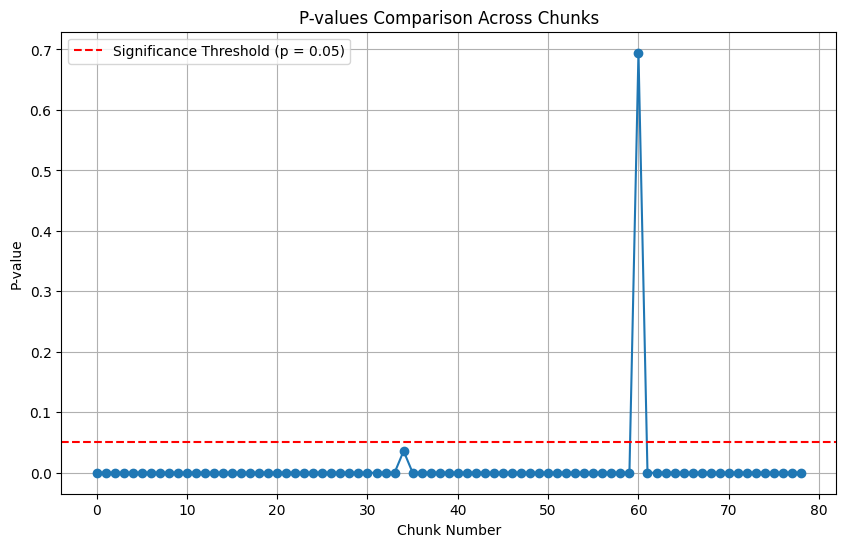

In [ ]:
compare_stats(final_df,'Heart Rate_mean',160)

#### Comparisons and p-value plots

In [ ]:
df.columns

Index(['level_0', 'Unnamed: 0', 'index', 'Risk Perception', 'Automation Error',
       'ID', 'System Timestamp CAL', 'Timestamp RAW', 'Date', 'Time',
       'EDA_Raw', 'Heart Rate_raw', 'Heart Rate_cleaned', 'Heart Rate_mean',
       'Heart Rate_max', 'Heart Rate_min', 'Heart Rate_std', 'IBI PPG ALG',
       'EDA_Clean', 'EDA_Tonic', 'EDA_Tonic_norm', 'EDA_Phasic',
       'EDA_Phasic_norm', 'N_Video', 'P_Video', 'SCR_Onsets', 'SCR_Peaks',
       'SCR_Height', 'SCR_Amplitude', 'SCR_RiseTime', 'SCR_Recovery',
       'SCR_RecoveryTime', 'Record Number', 'chunk'],
      dtype='object')

   chunk Automation Error  SCR_RecoveryTime
0      0       With Error          0.000190
1      0    Without Error          0.001503
2      1       With Error          0.000271
3      1    Without Error          0.001292
4      2       With Error          0.000940
5      2    Without Error          0.001239
6      3       With Error          0.001929
7      3    Without Error          0.000246
8      4       With Error          0.000000
9      4    Without Error          0.000000
87
80


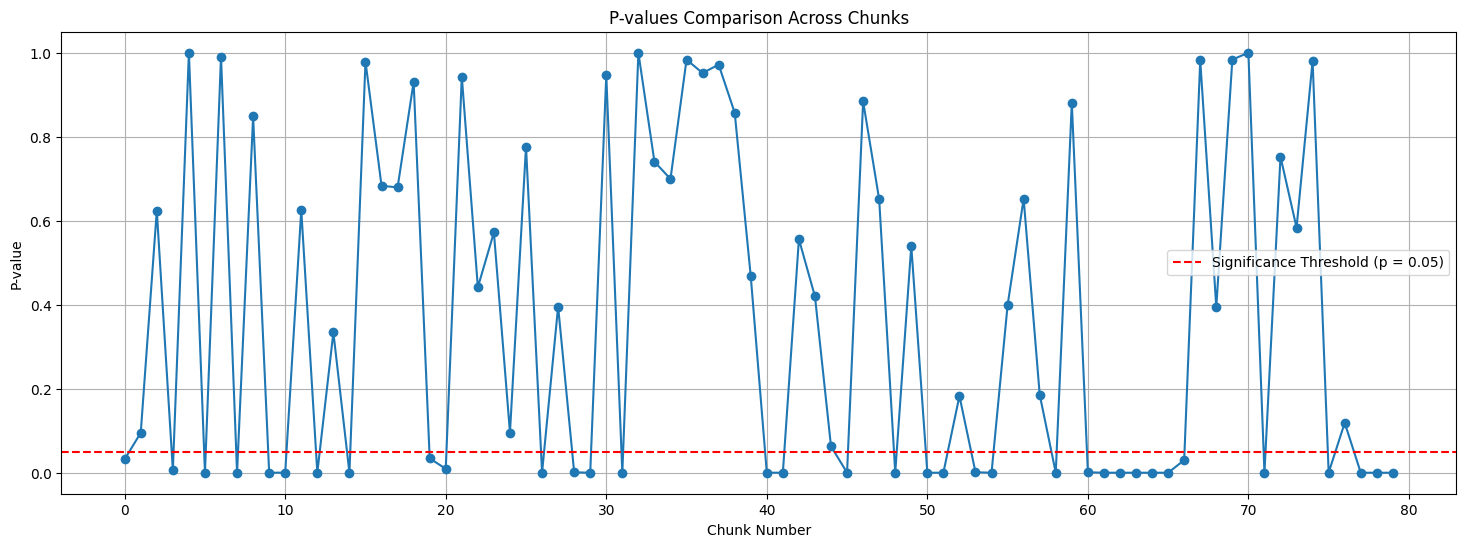

In [ ]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt


df = final_df.copy()
# print(df.shape)

# # Calculate the number of unique IDs for each group
# id_counts = df.groupby(['Record Number', 'Automation Error'])['ID'].nunique()

# # Filter out records with less than 22 unique IDs
# valid_records = id_counts[id_counts >= 22].index

# # Use the filtered records to create a new DataFrame
# filtered_final_df = df[df['Record Number'].isin(valid_records.get_level_values(0))]
# df = filtered_final_df

# print(df.shape)

var = 'SCR_RecoveryTime'
df = df.dropna(subset=[])
df = df.reset_index()


chunk_size = 160


# df['chunk'] = df.index // chunk_size

# df['chunk'] = df.index // chunk_size
df['chunk'] =  df['Record Number'] // chunk_size
grouped_df = df.groupby(['chunk', 'Automation Error']).agg({var: 'mean'}).reset_index()
# grouped_df = df.groupby(['chunk']).agg({var: 'mean', 'Risk Perception': 'first', 'Automation Error': 'first'}).reset_index()
print(grouped_df.head(10))
# print(df.chunk.max())

# print(len(df[df['N_Video']==1]))
# print(len(df[df['Automation Error']=='With Error']))

# print(len(df[df['P_Video']==1]))
# print(len(df[df['Automation Error']=='Without Error']))

# group1 = grouped_df[grouped_df['N_Video']==1]
group1 = grouped_df[grouped_df['Automation Error'] == 'With Error']

# group2 = grouped_df[grouped_df['P_Video']==1]
group2 = grouped_df[grouped_df['Automation Error'] == 'Without Error']

print(len(group1))
print(len(group2))

p_values = []


min_length = min(len(group1), len(group2))


for i in range(min_length):
    mean1 = group1.iloc[i][var]
    mean2 = group2.iloc[i][var]

    std1 = np.std(group1[var])
    std2 = np.std(group2[var])


    t_stat, p_value = stats.ttest_ind_from_stats(
        mean1=mean1, std1=std1, nobs1=len(group1),
        mean2=mean2, std2=std2, nobs2=len(group2)
    )

    p_values.append(p_value)


plt.figure(figsize=(18, 6))
plt.plot(p_values, marker='o')
plt.axhline(0.05, color='r', linestyle='--', label='Significance Threshold (p = 0.05)')
plt.title('P-values Comparison Across Chunks')
plt.xlabel('Chunk Number')
plt.ylabel('P-value')
plt.legend()
plt.grid(True)
plt.show()

80
87
80


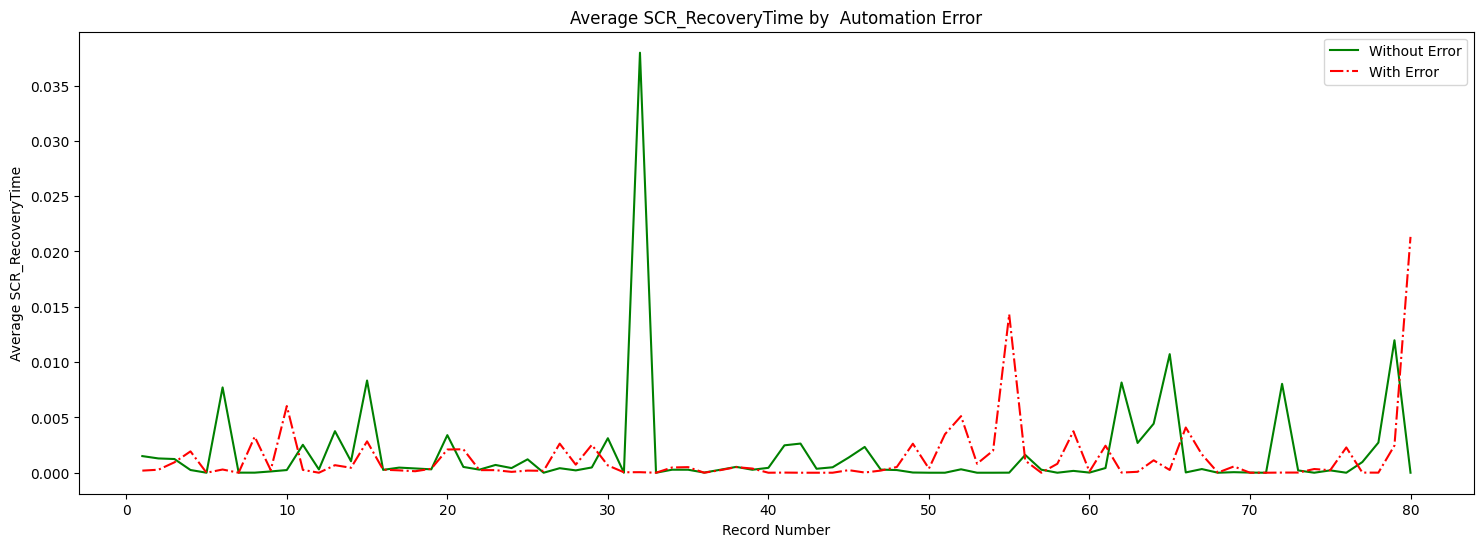

In [ ]:
import matplotlib.pyplot as plt
# var = 'Heart Rate_cleaned'
# average_Phasic_nE = final_df[(final_df['P_Video']==1)].groupby('Record Number')[var].mean()
# average_Phasic_E = final_df[(final_df['N_Video']==1)].groupby('Record Number')[var].mean()
average_Phasic_nE = df[(df['P_Video']==1)].groupby('chunk')[var].mean()
average_Phasic_E = df[(df['N_Video']==1)].groupby('chunk')[var].mean()

dim = min(len(average_Phasic_nE),len(average_Phasic_E))
print(len(average_Phasic_nE))
print(len(average_Phasic_E))
print(dim)
x = range(1, dim + 1)

# Create a wider figure
fig, ax = plt.subplots(figsize=(18, 6))

# Plot the first set of data
ax.plot(x, average_Phasic_nE[:dim], label='Without Error',  color='green',markersize=1) #marker='x',

# Plot the second set of data on the same axis, stacked on top of the first set
ax.plot(x, average_Phasic_E[:dim], label='With Error', color='r',linestyle='dashdot',markersize=1) #marker='o',

# Set labels and title
ax.set_xlabel('Record Number')
ax.set_ylabel(f'Average {var}')
ax.set_title(f'Average {var} by  Automation Error')

# Add legend
ax.legend()
# plt.xlim(100,dim)
# plt.ylim(0.42,0.52)
#plt.xticks(range(0, dim),rotation=45)
# Display the plot
plt.show()

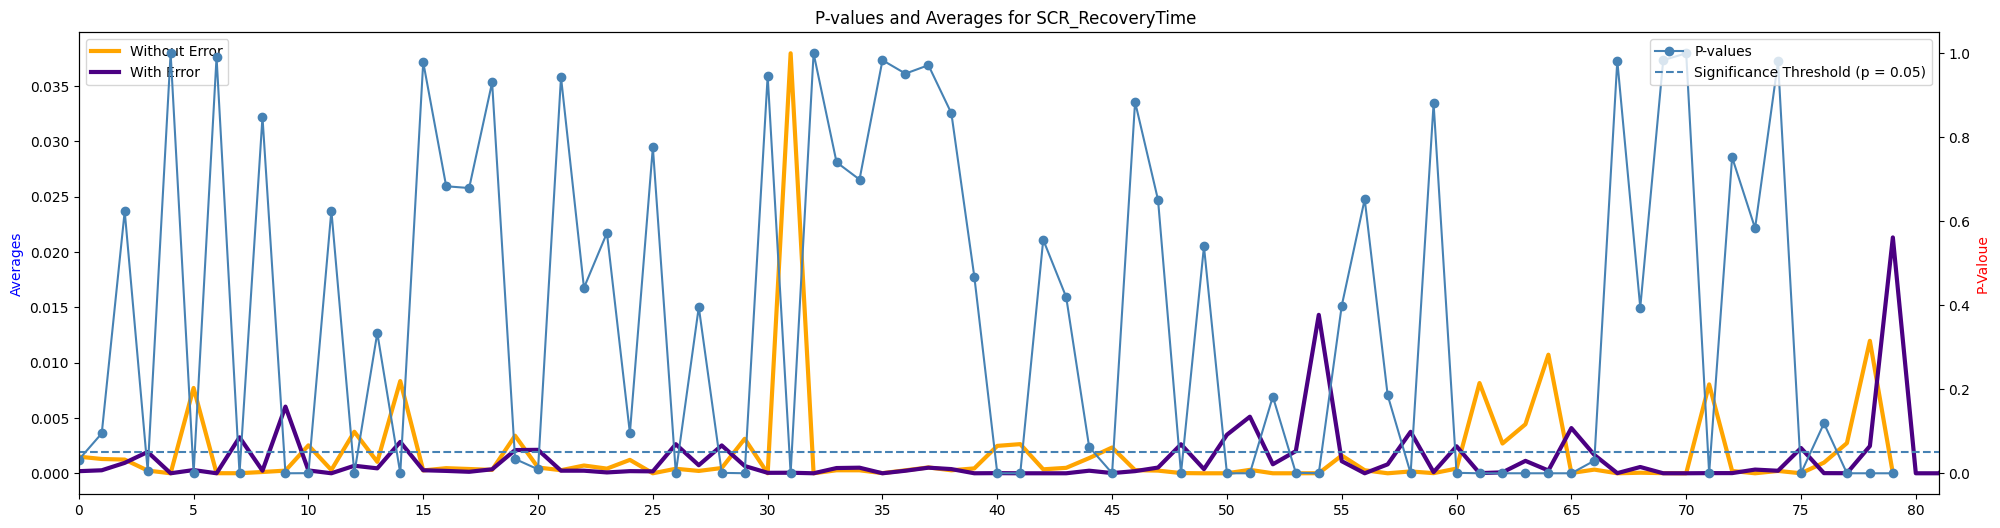

In [ ]:

# Create the plot
fig, ax = plt.subplots(figsize=(24, 6))


# Plot the first set of data
ax.plot(average_Phasic_nE, label='Without Error',  color='orange',linewidth=3) #marker='x',
ax.plot(average_Phasic_E, label='With Error', color='indigo',lw=3) #marker='o', ,linestyle='dashdot',
# plt.ylim(0.000,0.002)
ax.set_ylabel('Averages', color='blue')
# Create a second y-axis for averages
ax2 = ax.twinx()
# Plot p-values
ax2.plot(p_values, label='P-values', marker='o', linestyle='-', color='steelblue')
ax2.set_ylabel('P-Valoue',color='r')
# Plot the second set of data on the same axis, stacked on top of the first set


# Set labels and title
plt.xlabel('Chunk Number')


ax2.axhline(0.05, color='steelblue', linestyle='--', label='Significance Threshold (p = 0.05)')
plt.title(f'P-values and Averages for {var} ')

# Add legends
ax2.legend(loc='upper right')
ax.legend(loc='upper left')
plt.xlim(0,min_length+1)
plt.xticks(range(0, min_length+1,5),rotation=45)
#


# Display the plot
# plt.grid(True)
plt.savefig('/content/drive/MyDrive/Emotion_Em/Results/Figures/'+var+'.png',dpi=300)
plt.show()


##### Per Risk Perceptin

In [ ]:
df.columns

Index(['Risk_Perception', 'Automation_Error', 'ID', 'Gender', 'Years_Driving',
       'Eagerness_to_Adopt', 'Knowledge_of_SDV',
       'Perceived_Benefits_of_Using_a_Self-Driving_Vehicle',
       'Dispositional_Trust', 'Risk_Propensity', 'Learned_Trust', 'Trust',
       'Risk', 'Hostility', 'Confidence', 'Loneliness', 'Anxiety',
       'SCR_Onsets', 'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude',
       'SCR_RiseTime', 'SCR_Recovery', 'SCR_RecoveryTime',
       'Heart_Rate_cleaned', 'Heart_Rate_mean', 'Heart_Rate_max',
       'Heart_Rate_min', 'Heart_Rate_std', 'EDA_Phasic', 'EDA_Clean',
       'EDA_Tonic'],
      dtype='object')

In [ ]:
features = ['Heart Rate_mean','Heart Rate_cleaned','EDA_Phasic','EDA_Phasic_norm','EDA_Tonic','EDA_Tonic_norm','SCR_Amplitude','SCR_RiseTime','SCR_RecoveryTime']
n = 0

In [ ]:
var = 'Heart Rate_mean'#features[n]#'Heart Rate_mean'#'Heart Rate_cleaned','EDA_Phasic_norm'
n=n+1

In [ ]:
grouped_df

chunk Risk Perception  Heart Rate_mean
0        0         Control        87.082233
1        0              HR        87.909267
2        0              LR        88.689565
3        1         Control        88.620952
4        1              HR        86.768984
..     ...             ...              ...
256     85              HR        80.057888
257     85              LR        82.555116
258     86         Control        77.668335
259     86              HR        81.222742
260     86              LR        83.948623

[261 rows x 3 columns]

<Axes: xlabel='Risk Perception', ylabel='Heart Rate_mean'>

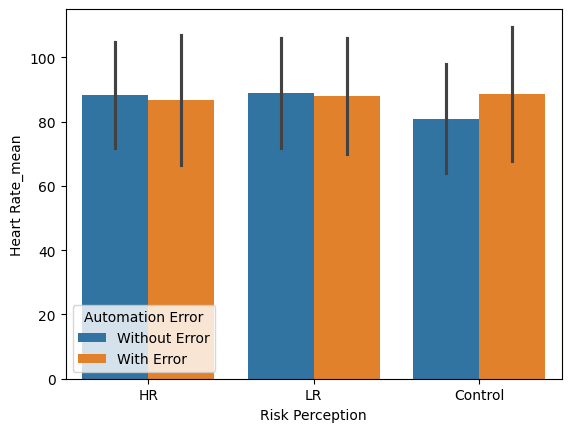

In [ ]:
sns.barplot(data=final_df[final_df['chunk']==1], y='Heart Rate_mean',hue='Automation Error',x='Risk Perception',errorbar='sd')

In [ ]:
grouped_df

2
2
2
81.79243458357372
83.9941303219972
80.69751101176527
82.09592254698934
84.302596178319
77.56863815081914


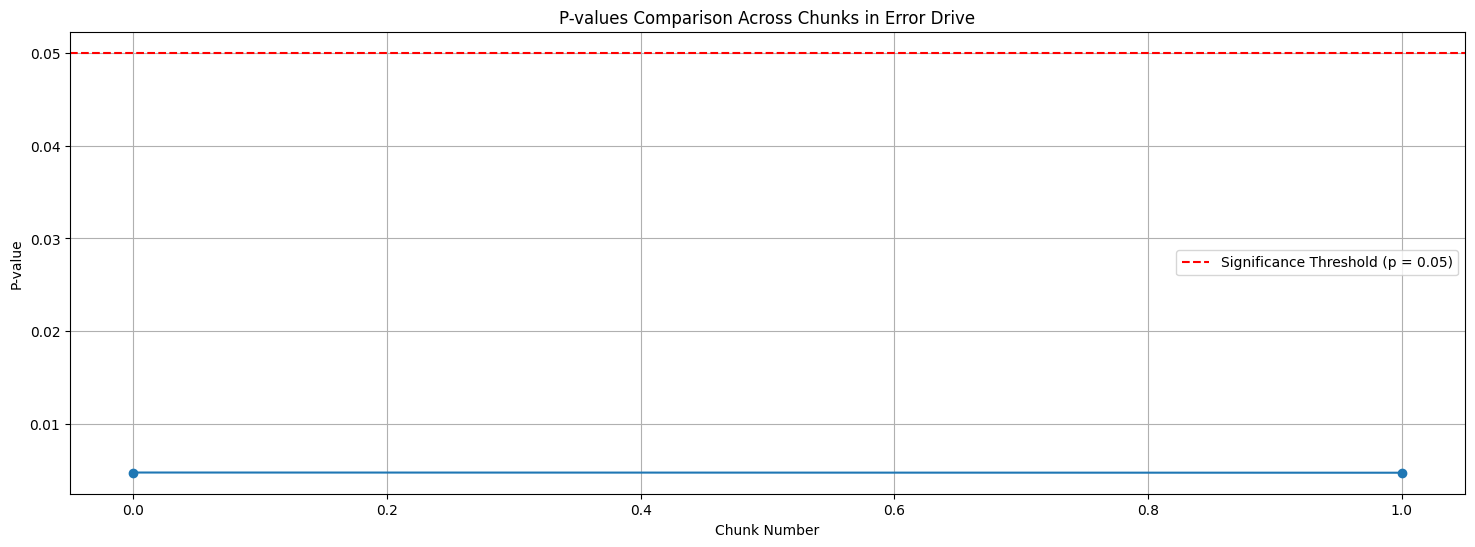

In [ ]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt


df = final_df.copy()
# df = df.dropna(subset=[])
df = df.reset_index()


chunk_size = 160


# df['chunk'] = df.index // chunk_size

# df['chunk'] = df.index // chunk_size
df['chunk'] =  df['Record Number'] // chunk_size
# grouped_df = df.groupby(['chunk', 'Risk Perception'])[var].mean().reset_index()
grouped_df = df[df['N_Video']==1].groupby(['chunk', 'Risk Perception']).agg({var: 'mean'}).reset_index()
# grouped_df = df.groupby(['chunk']).agg({var: 'mean', 'Risk Perception': 'first', 'Automation Error': 'first'}).reset_index()
# print(grouped_df.head(10))


# group1 = grouped_df[grouped_df['N_Video']==1]
group1 = grouped_df[grouped_df['Risk Perception'] == 'HR']

# group2 = grouped_df[grouped_df['P_Video']==1]
group2 = grouped_df[grouped_df['Risk Perception'] == 'LR']
group3 = grouped_df[grouped_df['Risk Perception'] == 'Control']

print(len(group1))
print(len(group2))
print(len(group3))

p_values = []


min_length = min(len(group1), len(group2),len(group3))


for i in range(min_length):
    # mean1 = df[(df['Risk Perception'] == 'HR') & (df['chunk']==i) & (df['N_Video']==1)][var]#group1.iloc[i][var]
    # mean2 = df[(df['Risk Perception'] == 'LR') & (df['chunk']==i) & (df['N_Video']==1)][var]#group2.iloc[i][var]
    # mean3 = df[(df['Risk Perception'] == 'Control') & (df['chunk']==i) & (df['N_Video']==1)][var]#group3.iloc[i][var]
    mean1 = group1.iloc[i][var]
    print(mean1)
    mean2 = group2.iloc[i][var]
    print(mean2)
    mean3 = group3.iloc[i][var]
    print(mean3)

    std1 = np.std(group1[var])
    std2 = np.std(group2[var])
    std3 = np.std(group3[var])


    t_stat, p_value = stats.ttest_ind_from_stats(
        mean1=mean1, std1=std1, nobs1=len(group1),
       # mean1=mean3, std1=std3, nobs1=len(group3),
        mean2=mean2, std2=std2, nobs2=len(group2)
    )
    #  f_statistic, p_value = stats.f_oneway(mean1, mean2,mean3)
    # print(p_value)

    p_values.append(p_value)


plt.figure(figsize=(18, 6))
plt.plot(p_values, marker='o')
plt.axhline(0.05, color='r', linestyle='--', label='Significance Threshold (p = 0.05)')
plt.title('P-values Comparison Across Chunks in Error Drive')
plt.xlabel('Chunk Number')
plt.ylabel('P-value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
 print(mean3)
 print(mean2)
 print(mean1)

77.56863815081914
84.302596178319
82.09592254698934


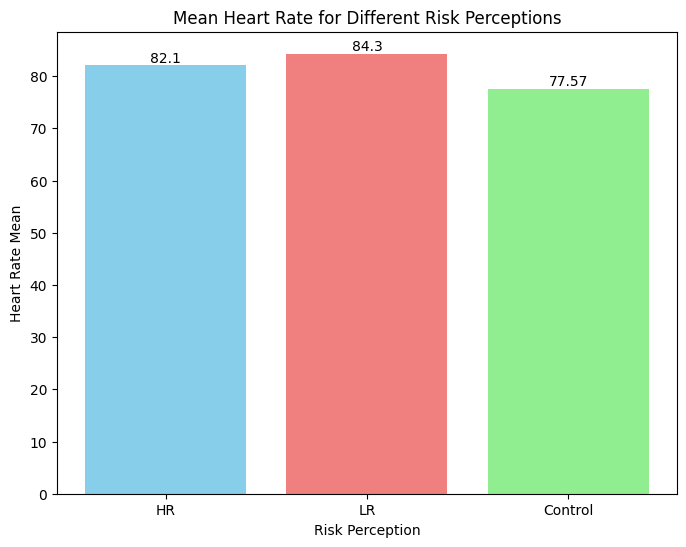

In [ ]:
# prompt: print bargraph of mean1 mean2 and mean3

import matplotlib.pyplot as plt
import numpy as np

# Sample means (replace with your actual means)
# mean1 = np.mean(final_df[final_df['Risk Perception'] == 'HR']['Heart Rate_mean'])
# mean2 = np.mean(final_df[final_df['Risk Perception'] == 'LR']['Heart Rate_mean'])
# mean3 = np.mean(final_df[final_df['Risk Perception'] == 'Control']['Heart Rate_mean'])

means = [mean1, mean2, mean3]
labels = ['HR', 'LR', 'Control']

# Create the bar graph
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.bar(labels, means, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.xlabel("Risk Perception")
plt.ylabel("Heart Rate Mean")
plt.title("Mean Heart Rate for Different Risk Perceptions")

# Add value labels on top of the bars
for i, v in enumerate(means):
    plt.text(i, v + 0.01, str(round(v, 2)), ha='center', va='bottom', fontsize=10)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
# var = 'Heart Rate_cleaned'
# average_Phasic_nE = final_df[(final_df['P_Video']==1)].groupby('Record Number')[var].mean()
# average_Phasic_E = final_df[(final_df['N_Video']==1)].groupby('Record Number')[var].mean()
# average_Phasic_nE = df[(df['P_Video']==1)].groupby('chunk')[var].mean()
# average_Phasic_E = df[(df['N_Video']==1)].groupby('chunk')[var].mean()


#------- using video annotations-------
average_HR_nE = df[(df['Risk Perception']=='HR')& (df['P_Video']==1)].groupby('chunk')[var].mean()
average_HR_E = df[(df['Risk Perception']=='HR') & (df['N_Video']==1)].groupby('chunk')[var].mean()
average_LR_nE = df[(df['Risk Perception']=='LR') & (df['P_Video']==1)].groupby('chunk')[var].mean()
average_LR_E = df[(df['Risk Perception']=='LR') & (df['N_Video']==1)].groupby('chunk')[var].mean()
average_C_nE = df[(df['Risk Perception']=='Control') & (df['P_Video']==1)].groupby('chunk')[var].mean()
average_C_E = df[(df['Risk Perception']=='Control') & (df['N_Video']==1)].groupby('chunk')[var].mean()

dim = min(len(average_HR_E),len(average_LR_E),len(average_C_E))
print(dim)
x = range(1, dim + 1)

# # Create a wider figure
# fig, ax = plt.subplots(figsize=(18, 6))

# # Plot the first set of data
# ax.plot(x, average_HR_nE[:dim], label='High risk',  color='green',lw=1) #marker='x',

# # Plot the second set of data on the same axis, stacked on top of the first set
# ax.plot(x, average_LR_nE[:dim], label='Low risk', color='r',linestyle='dashdot',lw=1) #marker='o',
# ax.plot(x, average_C_nE[:dim], label='Control', color='b',linestyle='dashdot',lw=1) #marker='o',

# # Set labels and title
# ax.set_xlabel('Record Number')
# ax.set_ylabel(f'Average {var}')
# ax.set_title(f'Average {var} by  Risk Perception')

# # Add legend
# ax.legend()
# # plt.xlim(100,dim)
# # plt.ylim(0.42,0.52)
# #plt.xticks(range(0, dim),rotation=45)
# # Display the plot
# plt.show()

2


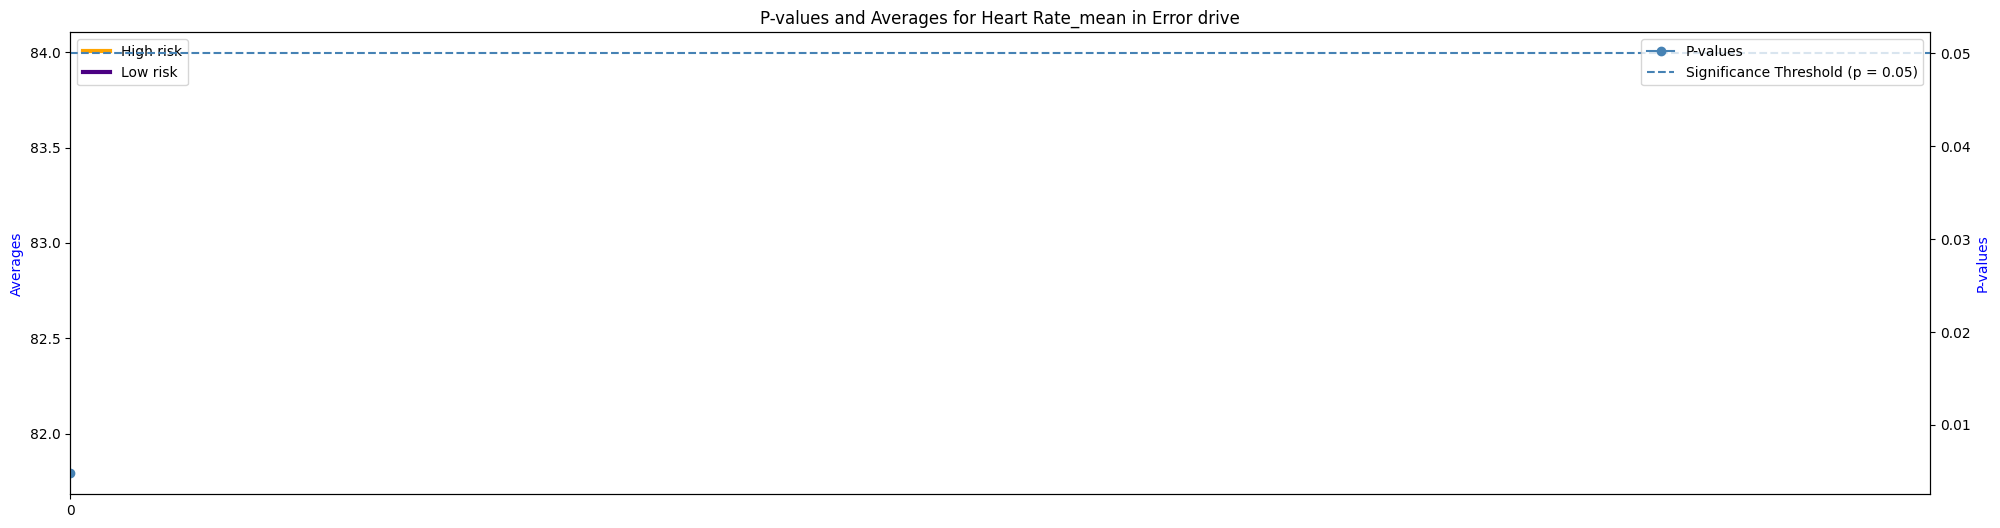

In [ ]:

# Create the plot
fig, ax = plt.subplots(figsize=(24, 6))


# Plot the first set of data
ax.plot(average_HR_E[:-1], label='High risk',  color='orange',linewidth=3) #marker='x', #[:-1]
ax.plot(average_LR_E[:-1], label='Low risk', color='indigo',lw=3) #marker='o', ,linestyle='dashdot',
# ax.plot(average_C_E, label='Control', color='green',lw=3) #marker='o', ,linestyle='dashdot',
# plt.ylim(-0.18,0.2)

# Create a second y-axis for averages
ax2 = ax.twinx()
# Plot p-values
ax2.plot(p_values[:-1], label='P-values', marker='o', linestyle='-', color='steelblue')
ax2.set_ylabel('P-Valoue',color='r')
# Plot the second set of data on the same axis, stacked on top of the first set


# Set labels and title
plt.xlabel('Chunk Number')
plt.ylabel('P-values', color='blue')
ax.set_ylabel('Averages', color='blue')
ax2.axhline(0.05, color='steelblue', linestyle='--', label='Significance Threshold (p = 0.05)')
plt.title(f'P-values and Averages for {var} in Error drive')

# Add legends
ax2.legend(loc='upper right')
ax.legend(loc='upper left')
plt.xlim(0,min_length+1)
plt.xticks(range(0, min_length+1,5),rotation=45)



# Display the plot
# plt.grid(True)
# plt.savefig('/content/drive/MyDrive/Emotion_Em/Results/Figures/LR_vs_HR/'+var+'_by_Risk_error.png',dpi=300)
plt.show()


In [ ]:
df.groupby('Automation Error').chunk.max()

Automation Error
With Error       86
Without Error    79
Name: chunk, dtype: int64

<Axes: xlabel='Risk Perception', ylabel='SCR_RecoveryTime'>

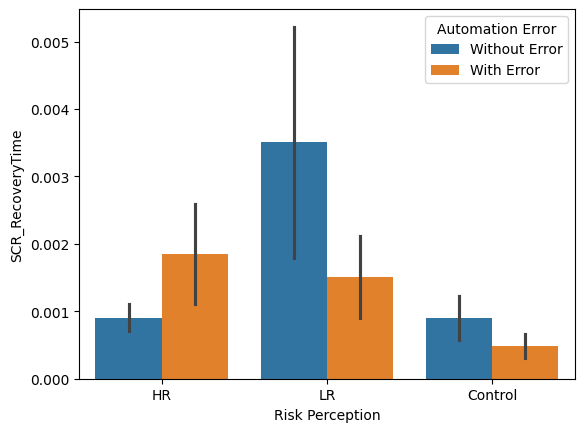

In [ ]:
sns.barplot(x='Risk Perception', y=var, data=final_df,hue='Automation Error',errorbar='se')

In [ ]:
f_statistic,p_val = stats.f_oneway(df[(df['Risk Perception'] == 'HR') &(df['N_Video']==1)], df[(df['Risk Perception'] == 'LR') &(df['N_Video']==1)], df[(df['Risk Perception'] == 'Control') &(df['N_Video']==1)])
print(p_val)

In [ ]:
final_df.columns

Index(['Unnamed: 0', 'index', 'Risk Perception', 'Automation Error', 'ID',
       'System Timestamp CAL', 'Timestamp RAW', 'Date', 'Time', 'EDA_Raw',
       'Heart Rate_raw', 'Heart Rate_cleaned', 'Heart Rate_mean',
       'Heart Rate_max', 'Heart Rate_min', 'Heart Rate_std', 'IBI PPG ALG',
       'EDA_Clean', 'EDA_Tonic', 'EDA_Tonic_norm', 'EDA_Phasic',
       'EDA_Phasic_norm', 'N_Video', 'P_Video', 'SCR_Onsets', 'SCR_Peaks',
       'SCR_Height', 'SCR_Amplitude', 'SCR_RiseTime', 'SCR_Recovery',
       'SCR_RecoveryTime', 'Record Number', 'chunk'],
      dtype='object')

In [ ]:
anv = pg.anova(dv=var, between='Risk Perception', data=final_df,detailed=True)
anv

Source            SS       DF            MS            F  p-unc  \
0  Risk Perception  4.857606e+06        2  2.428803e+06  6873.661896    0.0   
1           Within  6.436266e+08  1821503  3.533492e+02          NaN    NaN   

        np2  
0  0.007491  
1       NaN

In [ ]:
pg.mixed_anova(data=final_df, dv=var, between='Risk Perception', within='Automation Error', subject='ID')

Source          SS  DF1  DF2          MS         F     p-unc  \
0   Risk Perception  379.938058    2   67  189.969029  0.454322  0.636820   
1  Automation Error  257.773642    1   67  257.773642  5.795489  0.018829   
2       Interaction   15.056569    2   67    7.528284  0.169257  0.844651   

        np2  eps  
0  0.013380  NaN  
1  0.079613  1.0  
2  0.005027  NaN

In [ ]:
final_df[final_df['Automation Error']=='Without Error']['Record Number'].max()

12762

In [ ]:
print(final_df['Record Number'].max())

20164


In [ ]:
print(final_df.shape)
df.shape

(1823632, 30)


(1821506, 32)

In [ ]:
output_file

'/content/drive/MyDrive/Emotion_Em/Results/Datasets/physiologicalData_norm_Nov8.csv'

In [ ]:
df.to_csv('/content/drive/MyDrive/Emotion_Em/Results/Datasets/physiologicalData_norm_Nov8_clean.csv')

# Eye-tracking

In [ ]:
root_directory = "/content/drive/MyDrive/Emotion_Em/Fixations" # for Lily


In [ ]:
folder_path = "/content/drive/MyDrive/Emotion_Em/Fixations"
output_file = "/content/drive/MyDrive/Emotion_Em/Results/Datasets/eye-tracking.csv"
combined_df = pd.DataFrame()

In [ ]:
import glob
# Get all CSV files in the specified folder

csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
print(len(csv_files))
# Check if there are any CSV files
if not csv_files:
    print("No CSV files found in the specified folder.")


70


In [ ]:
df = pd.read_csv(csv_files[3])
df.columns

id = (csv_files[3].split('/')[-1])
id

'5.csv'

In [ ]:
# participants = final_df[['Risk Perception', 'Automation Error', 'ID']].drop_duplicates()


In [ ]:
# df_unique_risk_id.to_csv('/content/drive/MyDrive/Emotion_Em/Results/Datasets/participants.csv', index=False)

In [ ]:

# List to store individual DataFrames
df_list = []

# Read each CSV file and append to the list
for file in csv_files:
    df = pd.read_csv(file)
    df = df[['id', 'start_timestamp', 'duration', 'dispersion','confidence']]
    id = (file.split('/')[-1]).split('.')[0]
    df['ID'] = id
    print(id)

    df.rename(columns={'id': 'fixationID'}, inplace=True)
    df_list.append(df)

# Concatenate all DataFrames in the list
combined_df = pd.concat(df_list, ignore_index=True)
# Write the combined DataFrame to a new CSV file


1
3
4
5
7
8
9
10
11
12
13
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73


<ipython-input-78-ed57b41a5360>:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(df_list, ignore_index=True)


In [ ]:
combined_df['ID'] = combined_df['ID'].astype(int)
combined_df

fixationID  start_timestamp  duration  dispersion  confidence  ID
0               2   -220790.769874  211.7520    1.330228    0.921564   1
1               3   -220790.500259  100.2400    0.876013    0.922392   1
2               4   -220790.319922  147.7715    1.221365    0.922596   1
3               5   -220789.976075  148.0440    1.367435    1.000000   1
4               6   -220789.824155  192.0660    1.287404    1.000000   1
...           ...              ...       ...         ...         ...  ..
572956       6817   -491977.194181  144.0820    1.031553    0.823825  73
572957       6818   -491976.258159  124.8980    0.244858    0.763882  73
572958       6819   -491975.870067  199.9470    0.340793    0.740073  73
572959       6820   -491975.510191  124.0990    0.385458    0.716125  73
572960       6821   -491975.126101   80.0230    0.694877    0.820900  73

[572961 rows x 6 columns]

In [ ]:
part = participants[['ID','Risk Perception']].drop_duplicates()
part

ID Risk Perception
0        55              HR
29360     1              HR
59439     5              HR
89269    13              HR
121570   21              HR
...      ..             ...
2041839  48         Control
2071647  54         Control
2101876  60         Control
2132856  66         Control
2163015  72         Control

[70 rows x 2 columns]

In [ ]:
len(part.ID.unique())

70

In [ ]:
merged_df = pd.merge(combined_df, part, on=['ID'],how='left')
merged_df

fixationID  start_timestamp  duration  dispersion  confidence  ID  \
0               2   -220790.769874  211.7520    1.330228    0.921564   1   
1               3   -220790.500259  100.2400    0.876013    0.922392   1   
2               4   -220790.319922  147.7715    1.221365    0.922596   1   
3               5   -220789.976075  148.0440    1.367435    1.000000   1   
4               6   -220789.824155  192.0660    1.287404    1.000000   1   
...           ...              ...       ...         ...         ...  ..   
572956       6817   -491977.194181  144.0820    1.031553    0.823825  73   
572957       6818   -491976.258159  124.8980    0.244858    0.763882  73   
572958       6819   -491975.870067  199.9470    0.340793    0.740073  73   
572959       6820   -491975.510191  124.0990    0.385458    0.716125  73   
572960       6821   -491975.126101   80.0230    0.694877    0.820900  73   

       Risk Perception  
0                   HR  
1                   HR  
2                   HR  
3                   HR  
4                   HR  
...                ...  
572956              HR  
572957              HR  
572958              HR  
572959              HR  
572960              HR  

[572961 rows x 7 columns]

In [ ]:
merged_df.to_csv(output_file, index=False)
print(f"All CSV files have been appended to {output_file}")

All CSV files have been appended to /content/drive/MyDrive/Emotion_Em/Results/Datasets/eye-tracking.csv


In [ ]:

# Group by 'Risk Perception' and 'Automation Error' and calculate the average duration and number of fixations
average_fixations_duration = merged_df.groupby(['Risk Perception']) \
    .agg({'duration': 'mean', 'fixationID': 'count'}) \
    .rename(columns={'duration': 'Average Duration', 'fixationID': 'Average Fixations'})

print(average_fixations_duration)

                 Average Duration  Average Fixations
Risk Perception                                     
Control                167.899477             180366
HR                     159.656267             178430
LR                     162.363737             198152


In [ ]:
participants['Risk Perception'].unique()

array(['HR', 'LR', 'Control'], dtype=object)

In [ ]:
len(combined_df['ID'].unique())

1

# MixedML Mediation

In [ ]:
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 5.3 MB/s eta 0:00:00


In [ ]:
import statsmodels.api as sm
import pandas as pd
import statsmodels.genmod.families.links as links
from statsmodels.stats.mediation import Mediation
from statsmodels.regression.mixed_linear_model import MixedLM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Emotion_Em/Results/Datasets/merged_data_Nov14.csv')

In [ ]:
df.columns

Index(['Risk Perception', 'Automation Error', 'ID', 'Gender', 'Years Driving',
       'Eagerness to Adopt New Technologies',
       'Knowledge of Self-Driving Vehicles',
       'Perceived Benefits of Using a Self-Driving Vehicle',
       'Dispositional Trust', 'Risk Propensity', 'Learned Trust', 'Trust',
       'Risk', 'Hostility', 'Confidence', 'Loneliness', 'Anxiety',
       'SCR_Onsets', 'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude',
       'SCR_RiseTime', 'SCR_Recovery', 'SCR_RecoveryTime',
       'Heart Rate_cleaned', 'Heart Rate_mean', 'Heart Rate_max',
       'Heart Rate_min', 'Heart Rate_std', 'EDA_Phasic', 'EDA_Clean',
       'EDA_Tonic'],
      dtype='object')

In [ ]:
df.shape

(140, 32)

In [ ]:
cols = ['Heart Rate_cleaned', 'Heart Rate_mean', 'Heart Rate_max',
       'Heart Rate_min', 'EDA_Phasic', 'EDA_Clean',
       'EDA_Tonic']
for feature in cols:
  print(f'\n\n -------#------- {feature}----------\n\n')
  #aov = pg.anova(dv='EDA_Phasic', between='Group',data=final_df)
  aov = pg.mixed_anova(dv=feature, between='Risk Perception', within='Automation Error', subject='ID', data=final_df).round(3)

  # Print the result
  print(aov)



 -------#------- Heart Rate_cleaned----------


             Source       SS  DF1  DF2       MS      F  p-unc    np2  eps
0   Risk Perception  380.893    2   67  190.447  0.456  0.636  0.013  NaN
1  Automation Error  258.697    1   67  258.697  5.826  0.019  0.080  1.0
2       Interaction   14.764    2   67    7.382  0.166  0.847  0.005  NaN


 -------#------- Heart Rate_mean----------


             Source       SS  DF1  DF2       MS      F  p-unc    np2  eps
0   Risk Perception  379.938    2   67  189.969  0.454  0.637  0.013  NaN
1  Automation Error  257.774    1   67  257.774  5.795  0.019  0.080  1.0
2       Interaction   15.057    2   67    7.528  0.169  0.845  0.005  NaN


 -------#------- Heart Rate_max----------


             Source       SS  DF1  DF2       MS      F  p-unc    np2  eps
0   Risk Perception  446.641    2   67  223.321  0.527  0.593  0.015  NaN
1  Automation Error  271.543    1   67  271.543  6.339  0.014  0.086  1.0
2       Interaction   20.014    2   67   10

In [ ]:
df = df.reset_index()

In [ ]:
df.columns

Index(['index', 'Risk Perception', 'Automation Error', 'ID', 'Gender',
       'Years Driving', 'Eagerness to Adopt New Technologies',
       'Knowledge of Self-Driving Vehicles',
       'Perceived Benefits of Using a Self-Driving Vehicle',
       'Dispositional Trust', 'Risk Propensity', 'Learned Trust', 'Trust',
       'Risk', 'Skeptical', 'Excited', 'Uncertain', 'Anxiety', 'SCR_Onsets',
       'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude', 'SCR_RiseTime',
       'SCR_Recovery', 'SCR_RecoveryTime', 'Heart Rate_cleaned',
       'Heart Rate_mean', 'Heart Rate_max', 'Heart Rate_min', 'Heart Rate_std',
       'EDA_Phasic'],
      dtype='object')

In [ ]:
import pandas as pd

def rename_columns(df):
  """Renames DataFrame columns by replacing spaces with underscores.

  Args:
    df: pandas DataFrame.

  Returns:
    pandas DataFrame with renamed columns.
  """
  new_columns = []
  for col in df.columns:
    new_col = col.replace(" ", "_")
    new_columns.append(new_col)
  df.columns = new_columns
  return df


In [ ]:
# Rename columns for better readability and analysis
# df = rename_columns(df)
# df = df.rename(columns={
#     'Eagerness_to_Adopt_New_Technologies': 'Eagerness_to_Adopt',
#     'Knowledge_of_Self-Driving_Vehicles': 'Knowledge_of_SDV',
#     'Skeptical': 'Hostility',
#     'Excited': 'Confidence',
#     'Uncertain': 'Loneliness',
#     # Add more column renames as needed
# })
df = df.rename(columns={
    'Risk Perception': 'Risk_Perception',
    'Automation Error': 'Automation_Error',
    'Years Driving': 'Years_Driving',
    'Eagerness to Adopt New Technologies': 'Eagerness_to_Adopt',
    'Knowledge of Self-Driving Vehicles': 'Knowledge_of_SDV',
    'Dispositional Trust': 'Dispositional_Trust',
    'Risk Propensity': 'Risk_Propensity',
    'Learned Trust': 'Learned_Trust',
    'Skeptical': 'Hostility',
    'Excited': 'Confidence',
    'Uncertain': 'Loneliness',
    # Add more column renames as needed
})
rename_columns(df)
df.columns


Index(['Risk_Perception', 'Automation_Error', 'ID', 'Gender', 'Years_Driving',
       'Eagerness_to_Adopt', 'Knowledge_of_SDV',
       'Perceived_Benefits_of_Using_a_Self-Driving_Vehicle',
       'Dispositional_Trust', 'Risk_Propensity', 'Learned_Trust', 'Trust',
       'Risk', 'Hostility', 'Confidence', 'Loneliness', 'Anxiety',
       'SCR_Onsets', 'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude',
       'SCR_RiseTime', 'SCR_Recovery', 'SCR_RecoveryTime',
       'Heart_Rate_cleaned', 'Heart_Rate_mean', 'Heart_Rate_max',
       'Heart_Rate_min', 'Heart_Rate_std', 'EDA_Phasic', 'EDA_Clean',
       'EDA_Tonic'],
      dtype='object')

In [ ]:
model = MixedLM.from_formula(
    "Hostility ~ C(Automation_Error) + Years_Driving + Eagerness_to_Adopt + Knowledge_of_SDV + Dispositional_Trust + Risk_Propensity + Learned_Trust",
    groups="ID",
    re_formula="~ C(Automation_Error)",  # Random slope for Automation Error (Performance)
    data=df
)

# Fit the model
result = model.fit()
print(result.summary())

                    Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        Hostility
No. Observations:         140            Method:                    REML     
No. Groups:               70             Scale:                     0.5031   
Min. group size:          2              Log-Likelihood:            -200.3464
Max. group size:          2              Converged:                 Yes      
Mean group size:          2.0                                                
-----------------------------------------------------------------------------
                                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                          3.738    0.850   4.398 0.000  2.072  5.404
C(Automation_Error)[T.2]          -1.637    0.146 -11.221 0.000 -1.923 -1.351
Years_Driving                      0.023    0.038   0.602 0.547 -0.051  0.097
Eagern

In [ ]:
df.columns

Index(['Risk_Perception', 'Automation_Error', 'ID', 'Gender', 'Years_Driving',
       'Eagerness_to_Adopt', 'Knowledge_of_SDV',
       'Perceived_Benefits_of_Using_a_Self-Driving_Vehicle',
       'Dispositional_Trust', 'Risk_Propensity', 'Learned_Trust', 'Trust',
       'Risk', 'Hostility', 'Confidence', 'Loneliness', 'Anxiety',
       'SCR_Onsets', 'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude',
       'SCR_RiseTime', 'SCR_Recovery', 'SCR_RecoveryTime',
       'Heart_Rate_cleaned', 'Heart_Rate_mean', 'Heart_Rate_max',
       'Heart_Rate_min', 'Heart_Rate_std', 'EDA_Phasic', 'EDA_Clean',
       'EDA_Tonic'],
      dtype='object')

In [ ]:
cols = ['Trust','Risk']#,'Hostility', 'Confidence', 'Loneliness', 'Anxiety']
for feature in cols:
  # Define the mixed model formula
  formula = f'{feature}~ Risk_Perception* Automation_Error + (1|ID)'



  # Fit the mixed model
  mixed_model = MixedLM.from_formula(formula, data=df, groups=df['ID']).fit()

  # Print the model summary
  print(mixed_model.summary())

                   Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       Trust    
No. Observations:         140           Method:                   REML     
No. Groups:               70            Scale:                    0.4226   
Min. group size:          2             Log-Likelihood:           -170.6265
Max. group size:          2             Converged:                Yes      
Mean group size:          2.0                                              
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                         1.216    0.493  2.469 0.014  0.251  2.182
Risk_Perception                   0.142    0.220  0.643 0.520 -0.290  0.573
Automation_Error                  1.966    0.287  6.844 0.000  1.403  2.529
Risk_Perception:Automation_Erro

In [ ]:
df.columns

Index(['Risk_Perception', 'Automation_Error', 'ID', 'Gender', 'Years_Driving',
       'Eagerness_to_Adopt', 'Knowledge_of_SDV',
       'Perceived_Benefits_of_Using_a_Self-Driving_Vehicle',
       'Dispositional_Trust', 'Risk_Propensity', 'Learned_Trust', 'Trust',
       'Risk', 'Hostility', 'Confidence', 'Loneliness', 'Anxiety',
       'SCR_Onsets', 'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude',
       'SCR_RiseTime', 'SCR_Recovery', 'SCR_RecoveryTime',
       'Heart_Rate_cleaned', 'Heart_Rate_mean', 'Heart_Rate_max',
       'Heart_Rate_min', 'Heart_Rate_std', 'EDA_Phasic', 'EDA_Clean',
       'EDA_Tonic'],
      dtype='object')

In [ ]:
mediators = ['Hostility', 'Confidence', 'Loneliness', 'Anxiety']
#covars = ['Years_Driving', 'Dispositional_Trust', 'Risk_Propensity', 'Learned_Trust']
covars = 'Years_Driving + Dispositional_Trust +Risk_Propensity +Learned_Trust'

for feature in mediators:
  # Define the mixed model formula
  formula = f'{feature}~  Automation_Error + (1|ID) +{covars}'



  # Fit the mixed model
  mixed_model = MixedLM.from_formula(formula, data=df, groups=df['ID']).fit()

  # Print the model summary
  print(mixed_model.summary())

             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   Hostility
No. Observations:     140       Method:               REML     
No. Groups:           70        Scale:                0.7446   
Min. group size:      2         Log-Likelihood:       -213.2657
Max. group size:      2         Converged:            Yes      
Mean group size:      2.0                                      
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            4.447    1.010   4.405 0.000  2.468  6.426
Automation_Error    -1.637    0.146 -11.221 0.000 -1.923 -1.351
1 | ID               0.001    0.005   0.259 0.796 -0.009  0.011
Years_Driving        0.085    0.042   2.039 0.041  0.003  0.166
Dispositional_Trust  0.402    0.343   1.171 0.241 -0.271  1.075
Risk_Propensity      0.037    0.099   0.374 0.708 -0.

In [ ]:
# direct_effect = MixedLM.from_formula( f'Trust~  Automation_Error + (1|ID)', data=df, groups=df['ID']).fit()
# mediation_effect = MixedLM.from_formula(f'Trust~  Automation_Error + (1|ID)+{covars}', data=df, groups=df['ID']).fit()
# print(mediation_effect.summary())

total_effect =MixedLM.from_formula( f'Trust~  Automation_Error + Hostility + (1|ID)+{covars}', data=df, groups=df['ID']).fit()
total_effect.summary()

# med = Mediation(total_effect, mediation_effect, "Automation_Error", "Hostility").fit()
# med.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:               MixedLM   Dependent Variable:   Trust    
No. Observations:    140       Method:               REML     
No. Groups:          70        Scale:                0.4034   
Min. group size:     2         Log-Likelihood:       -162.9771
Max. group size:     2         Converged:            Yes      
Mean group size:     2.0                                      
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           -0.011    0.683 -0.017 0.987 -1.351  1.328
Automation_Error     1.635    0.144 11.373 0.000  1.353  1.916
Hostility           -0.130    0.058 -2.228 0.026 -0.245 -0.016
1 | ID              -0.000    0.003 -0.075 0.941 -0.007  0.006
Years_Driving       -0.033    0.026 -1.248 0.212 -0.084  0.019
Dispositional_Trust  0.434    0.214  2.027 0.043  0.014  0.854
Risk_Propensity      0.114    0.062  1.853 0.064 -0.007  0.235
Learned_Trust        0.212    0.092  2.320 0.020  0.033  0.392
Group Var            0.109    0.120                           
==============================================================

"""

In [ ]:
df.columns

Index(['index', 'Risk_Perception', 'Automation_Error', 'ID', 'Gender',
       'Years_Driving', 'Eagerness_to_Adopt', 'Knowledge_of_SDV',
       'Perceived_Benefits_of_Using_a_Self-Driving_Vehicle',
       'Dispositional_Trust', 'Risk_Propensity', 'Learned_Trust', 'Trust',
       'Risk', 'Hostility', 'Confidence', 'Loneliness', 'Anxiety',
       'SCR_Onsets', 'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude',
       'SCR_RiseTime', 'SCR_Recovery', 'SCR_RecoveryTime',
       'Heart_Rate_cleaned', 'Heart_Rate_mean', 'Heart_Rate_max',
       'Heart_Rate_min', 'Heart_Rate_std', 'EDA_Phasic', 'EDA_Clean',
       'EDA_Tonic'],
      dtype='object')

In [ ]:
from pingouin import mediation_analysis, read_dataset
# df_test = read_dataset('mediation')

In [ ]:
mediation_analysis(data=df, x='Automation_Error', m='Hostility', y='Trust',covar=['Years_Driving', 'Dispositional_Trust', 'Risk_Propensity', 'Learned_Trust'],n_boot=1000 ,seed=42).round(3)
# mediation_analysis(data=df, x='Risk_Perception',m=mediators,  y='Trust',covar=['Years_Driving', 'Dispositional_Trust', 'Risk_Propensity', 'Learned_Trust'],n_boot=1000 ,seed=42).round(3)

path   coef     se   pval  CI[2.5%]  CI[97.5%]  sig
0  Hostility ~ X -1.637  0.182  0.000    -1.996     -1.277  Yes
1  Y ~ Hostility -0.504  0.061  0.000    -0.626     -0.383  Yes
2          Total  1.848  0.122  0.000     1.607      2.089  Yes
3         Direct  1.641  0.152  0.000     1.340      1.942  Yes
4       Indirect  0.207  0.104  0.062     0.004      0.416   No

In [ ]:
outcome_model_confidence = MixedLM.from_formula( f'Trust~  Automation_Error + Confidence', data=df, groups=df['ID'])

mediator_model_confidence = MixedLM.from_formula(
    "Confidence ~ Automation_Error + Years_Driving + Eagerness_to_Adopt+ Heart_Rate_mean", groups=df["ID"],
    data=df
)

# Conduct mediation analysis for Confidence
med_confidence = Mediation(outcome_model_confidence, mediator_model_confidence, "Automation_Error", "Confidence").fit()
print(med_confidence.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


LinAlgError: Matrix is not positive definite

In [ ]:
import statsmodels.api as sm
import statsmodels.genmod.families.links as links
from statsmodels.stats.mediation import Mediation

# Assuming `df` is your DataFrame containing the data

# Confidence as mediator with both Risk_Perception and Automation_Error as predictors

# Step 1: Define the outcome model with both predictors and the mediator
outcome_model_confidence = sm.MixedLM.from_formula(
    "Trust ~ Confidence  + Automation_Error + Years_Driving + Eagerness_to_Adopt + Knowledge_of_SDV+1|ID",
    data=df, family=sm.families.Gaussian()
)

# Step 2: Define the mediator model with both predictors
mediator_model_confidence = sm.OLS.from_formula(
    "Confidence ~ Automation_Error + Years_Driving + Eagerness_to_Adopt + Knowledge_of_SDV",
    data=df
)

# Conduct mediation analysis for Confidence
med_confidence = Mediation(outcome_model_confidence, mediator_model_confidence, [ "Automation_Error"], "Confidence").fit()
print(med_confidence.summary())

# Repeat the above steps for each mediator: Hostility, Anxiety, and Loneliness

# Hostility as mediator
outcome_model_hostility = sm.GLM.from_formula(
    "Trust ~ Hostility + Automation_Error + Years_Driving + Eagerness_to_Adopt + Knowledge_of_SDV",
    data=df, family=sm.families.Gaussian()
)

mediator_model_hostility = sm.OLS.from_formula(
    "Hostility ~  Automation_Error + Years_Driving + Eagerness_to_Adopt + Knowledge_of_SDV",
    data=df
)

med_hostility = Mediation(outcome_model_hostility, mediator_model_hostility, [ "Automation_Error"], "Hostility").fit()
print(med_hostility.summary())

# Anxiety as mediator
outcome_model_anxiety = sm.GLM.from_formula(
    "Trust ~ Anxiety + Risk_Perception + Automation_Error + Years_Driving + Eagerness_to_Adopt + Knowledge_of_SDV",
    data=df, family=sm.families.Gaussian()
)

mediator_model_anxiety = sm.OLS.from_formula(
    "Anxiety ~ Risk_Perception + Automation_Error + Years_Driving + Eagerness_to_Adopt + Knowledge_of_SDV",
    data=df
)

med_anxiety = Mediation(outcome_model_anxiety, mediator_model_anxiety, ["Risk_Perception", "Automation_Error"], "Anxiety").fit()
print(med_anxiety.summary())

# Loneliness as mediator
outcome_model_loneliness = sm.GLM.from_formula(
    "Trust ~ Loneliness + Risk_Perception + Automation_Error + Years_Driving + Eagerness_to_Adopt + Knowledge_of_SDV",
    data=df, family=sm.families.Gaussian()
)

mediator_model_loneliness = sm.OLS.from_formula(
    "Loneliness ~ Risk_Perception + Automation_Error + Years_Driving + Eagerness_to_Adopt + Knowledge_of_SDV",
    data=df
)

med_loneliness = Mediation(outcome_model_loneliness, mediator_model_loneliness, ["Risk_Perception", "Automation_Error"], "Loneliness").fit()
print(med_loneliness.summary())

                          Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)            0.886906        0.650083        1.169021      0.0
ACME (treated)            0.886906        0.650083        1.169021      0.0
ADE (control)             0.958879        0.694188        1.213327      0.0
ADE (treated)             0.958879        0.694188        1.213327      0.0
Total effect              1.845785        1.574022        2.117977      0.0
Prop. mediated (control)  0.479336        0.368212        0.607732      0.0
Prop. mediated (treated)  0.479336        0.368212        0.607732      0.0
ACME (average)            0.886906        0.650083        1.169021      0.0
ADE (average)             0.958879        0.694188        1.213327      0.0
Prop. mediated (average)  0.479336        0.368212        0.607732      0.0


KeyboardInterrupt: 

# 17-dec

In [ ]:
df.columns

Index(['Risk Perception', 'Automation Error', 'ID', 'Gender', 'Years Driving',
       'Eagerness to Adopt New Technologies',
       'Knowledge of Self-Driving Vehicles',
       'Perceived Benefits of Using a Self-Driving Vehicle',
       'Dispositional Trust', 'Risk Propensity', 'Learned Trust', 'Trust',
       'Risk', 'Hostility', 'Confidence', 'Loneliness', 'Anxiety',
       'SCR_Onsets', 'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude',
       'SCR_RiseTime', 'SCR_Recovery', 'SCR_RecoveryTime',
       'Heart Rate_cleaned', 'Heart Rate_mean', 'Heart Rate_max',
       'Heart Rate_min', 'Heart Rate_std', 'EDA_Phasic', 'EDA_Clean',
       'EDA_Tonic'],
      dtype='object')

In [ ]:
!pip install pingouin
import pingouin as pg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 5.3 MB/s eta 0:00:00


In [ ]:
# prompt: one way anova for Learned trust with pingouin package

import pingouin as pg

# Assuming 'final_df' and 'var' are defined in your previous code
# Perform one-way ANOVA
aov = pg.anova(dv=var, between='Risk Perception', data=final_df, detailed=True)
aov

In [ ]:
aov = pg.anova(dv='Learned Trust', between='Risk Perception',data=df1,detailed=True).round(10)

# Print the result
print(aov)

            Source         SS   DF         MS          F  p-unc       np2
0  Risk Perception  37.558442    2  18.779221  50.998857    0.0  0.426773
1           Within  50.447273  137   0.368228        NaN    NaN       NaN


In [ ]:
df1 = df.drop_duplicates(subset=['ID'])

In [ ]:
df1.shape

(70, 32)

70

In [ ]:
aov = pg.anova(dv='Dispositional Trust', between='Risk Perception',data=df1,detailed=True,effsize="n2").round(3)

# Print the result
print(aov)

            Source     SS  DF     MS     F  p-unc     n2
0  Risk Perception  0.129   2  0.065  0.54  0.585  0.016
1           Within  8.012  67  0.120   NaN    NaN    NaN


In [ ]:
plt.rcParams['font.family'] = 'Liberation Serif'
plt.rcParams['font.size'] = 14

<ipython-input-111-c9f4060c89de>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Risk Perception', y='Learned Trust', data=df1,palette="rocket")#, errorbar='sd')


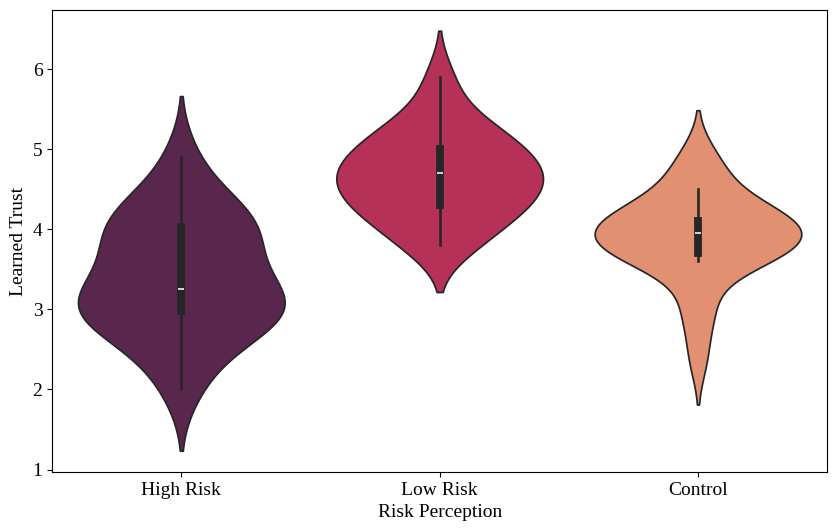

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.violinplot(x='Risk Perception', y='Learned Trust', data=df1,palette="rocket")#, errorbar='sd')
#plt.title('Learned Trust per Risk Perception Group')
plt.xlabel('Risk Perception')
plt.ylabel('Learned Trust')
#plt.savefig("/content/drive/MyDrive/Emotion_Em/Results/Figures/other metrics/LearnedTrust.png", dpi=300)
plt.show()

In [ ]:
post_hoc = pg.pairwise_tukey(dv='Learned Trust', between='Risk Perception',effsize="eta-square", data=df1).round(5)
print(post_hoc)

           A          B  mean(A)  mean(B)     diff       se        T  p-tukey  \
0    Control  High Risk      3.9  3.40000  0.50000  0.17712  2.82289  0.01700   
1    Control   Low Risk      3.9  4.67273 -0.77273  0.18110 -4.26676  0.00019   
2  High Risk   Low Risk      3.4  4.67273 -1.27273  0.18110 -7.02760  0.00000   

   eta-square  
0     0.13083  
1     0.33186  
2     0.49575  


<ipython-input-97-194365e4c5fb>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Risk Perception', y='Dispositional Trust', data=df, palette="rocket")#, errorbar='sd')


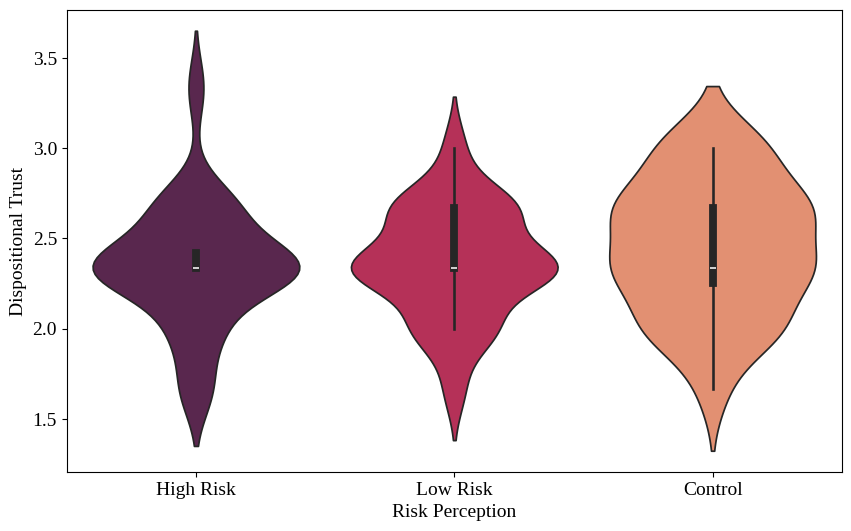

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Risk Perception', y='Dispositional Trust', data=df, palette="rocket")#, errorbar='sd')
#plt.title('Dispositional Trust per Risk Perception Group')
plt.xlabel('Risk Perception')
plt.ylabel('Dispositional Trust')
plt.savefig("/content/drive/MyDrive/Emotion_Em/Results/Figures/other metrics/DispositionalTrust.png", dpi=300)
plt.show()

In [ ]:
df['Risk Perception'].unique()

array([1, 2, 3])

In [ ]:
mapping = {
    1: 'High Risk',
    2: 'Low Risk',
    3: 'Control'
}

df['Risk Perception'] = df['Risk Perception'].replace(mapping)

In [ ]:
mapping = {
    1: 'With Errors',
    2: 'Without Errors'
}

df['Automation Error'] = df['Automation Error'].replace(mapping)

In [ ]:
# prompt: rename 'Automation Error' column to "AV Performance"

df = df.rename(columns={'Automation Error': 'AV Performance'})

In [ ]:
##-------------------Trust--------
print("-------------------Trust--------")
aov = pg.mixed_anova(dv='Trust', between='Risk Perception',within='AV Performance', subject="ID",data=df).round(3)
print(aov)

print("##-------------------Risk--------")
aov = pg.mixed_anova(dv='Risk', between='Risk Perception',within='AV Performance', subject="ID",data=df).round(3)

# Print the result
print(aov)

-------------------Trust--------
            Source       SS  DF1  DF2       MS        F  p-unc    np2  eps
0  Risk Perception    1.402    2   67    0.701    0.837  0.438  0.024  NaN
1   AV Performance  119.486    1   67  119.486  278.590  0.000  0.806  1.0
2      Interaction    0.085    2   67    0.042    0.099  0.906  0.003  NaN
##-------------------Risk--------
            Source      SS  DF1  DF2      MS       F  p-unc    np2  eps
0  Risk Perception   2.494    2   67   1.247   0.594  0.555  0.017  NaN
1   AV Performance  67.207    1   67  67.207  81.283  0.000  0.548  1.0
2      Interaction   0.458    2   67   0.229   0.277  0.759  0.008  NaN


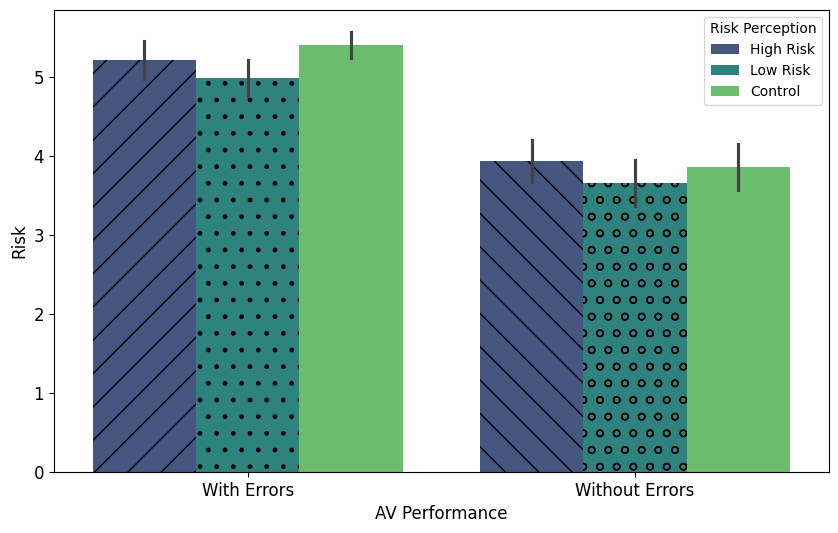

In [ ]:
plt.figure(figsize=(10, 6))
ax =sns.barplot(hue='Risk Perception', y='Risk', data=df,x="AV Performance", errorbar='se',palette='viridis')
#plt.title('Experienced Risk per Risk Perception Group and Performance')
plt.xlabel('AV Performance',fontsize=12)
plt.ylabel('Risk',fontsize=12)
# plt.show()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Get the bar objects from the plot
bars = ax.patches

# Define your hatch patterns (e.g., '/', '\\', '.', 'o', '*', '+', 'x')
patterns = ['/', '\\', '.', 'o']

# Assign hatch patterns to bars
for bar, pattern in zip(bars, patterns):
    bar.set_hatch(pattern)

plt.savefig("/content/drive/MyDrive/Emotion_Em/Results/Figures/other metrics/Risk.png", dpi=400)
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
df1.groupby('Risk Perception')['Risk Propensity'].mean()

Risk Perception
Control      3.979167
High Risk    4.031250
Low Risk     3.982955
Name: Risk Propensity, dtype: float64

<ipython-input-114-6c95b278288f>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Risk Perception', y='Risk Propensity', data=df1, errorbar='se',palette='viridis')


<Axes: xlabel='Risk Perception', ylabel='Risk Propensity'>

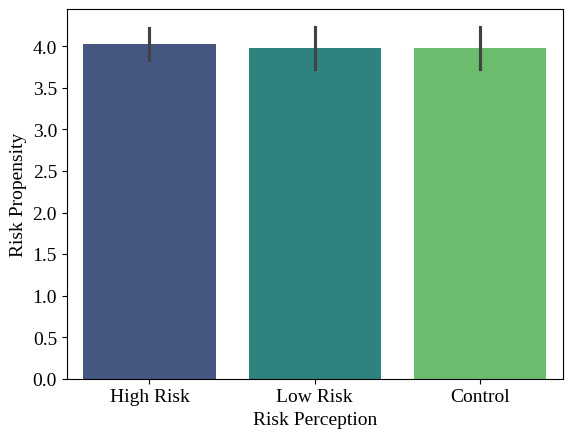

In [ ]:
sns.barplot(x='Risk Perception', y='Risk Propensity', data=df1, errorbar='se',palette='viridis')

Risk Perception
Control      5.406250
High Risk    5.218750
Low Risk     4.988636
Name: Risk, dtype: float64


<ipython-input-120-3d783dc1cf15>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Risk Perception', y='Risk', data=df[df['AV Performance']=='With Errors'], errorbar='se',palette='viridis')


<Axes: xlabel='Risk Perception', ylabel='Risk'>

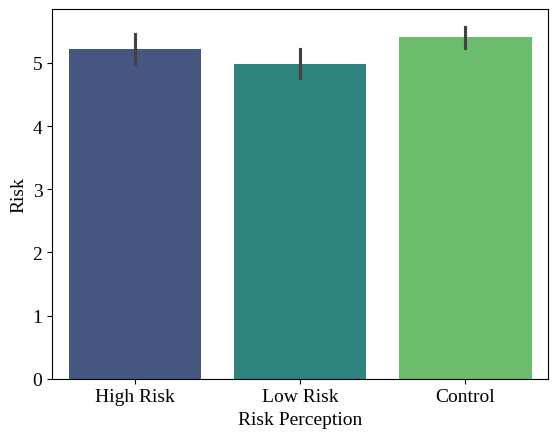

In [ ]:
##----------------- risk with errors---------
print(df[df['AV Performance']=="With Errors"].groupby('Risk Perception')['Risk'].mean())
sns.barplot(x='Risk Perception', y='Risk', data=df[df['AV Performance']=='With Errors'], errorbar='se',palette='viridis')

Risk Perception
Control      3.864583
High Risk    3.937500
Low Risk     3.659091
Name: Risk, dtype: float64


<ipython-input-121-d59a10dc9a51>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Risk Perception', y='Risk', data=df[df['AV Performance']=='Without Errors'], errorbar='se',palette='viridis')


<Axes: xlabel='Risk Perception', ylabel='Risk'>

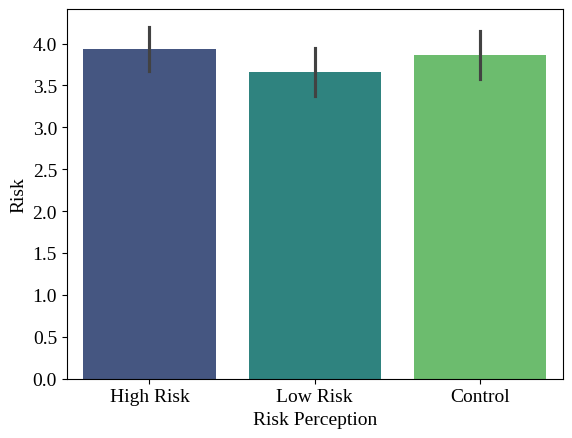

In [ ]:
##----------------- risk without errors---------
print(df[df['AV Performance']=="Without Errors"].groupby('Risk Perception')['Risk'].mean())
sns.barplot(x='Risk Perception', y='Risk', data=df[df['AV Performance']=='Without Errors'], errorbar='se',palette='viridis')

In [ ]:
df.groupby(['AV Performance','Risk Perception'])[['Risk','Trust','Hostility','Confidence','Anxiety','Loneliness']].mean().round(3)

Risk  Trust  Hostility  Confidence  Anxiety  \
AV Performance Risk Perception                                                 
With Errors    Control          5.406  3.389      3.417       2.975    4.615   
               High Risk        5.219  3.222      3.649       3.083    4.396   
               Low Risk         4.989  3.492      2.721       3.255    4.239   
Without Errors Control          3.865  5.174      1.679       5.158    3.052   
               High Risk        3.938  5.125      1.804       4.950    3.021   
               Low Risk         3.659  5.348      1.422       5.309    3.068   

                                Loneliness  
AV Performance Risk Perception              
With Errors    Control               3.062  
               High Risk             2.646  
               Low Risk              2.932  
Without Errors Control               2.500  
               High Risk             1.854  
               Low Risk              2.659

In [ ]:
df.groupby(['AV Performance','Risk Perception'])[['Risk','Trust','Hostility','Confidence','Anxiety','Loneliness']].std().round(2)

Risk  Trust  Hostility  Confidence  Anxiety  \
AV Performance Risk Perception                                                
With Errors    Control          0.83   0.95       1.33        1.25     1.45   
               High Risk        1.18   0.70       1.29        1.42     1.26   
               Low Risk         1.07   0.96       1.28        1.38     1.37   
Without Errors Control          1.42   0.89       0.91        1.12     1.19   
               High Risk        1.29   0.61       0.85        0.99     1.23   
               Low Risk         1.36   0.55       0.49        0.99     1.27   

                                Loneliness  
AV Performance Risk Perception              
With Errors    Control                1.87  
               High Risk              1.51  
               Low Risk               1.83  
Without Errors Control                1.55  
               High Risk              0.99  
               Low Risk               1.64

In [ ]:
df.groupby(['Risk Perception','AV Performance'])[['Risk','Risk Propensity']].mean().round(3)

Risk  Risk Propensity
Risk Perception AV Performance                        
Control         With Errors     5.406            3.979
                Without Errors  3.865            3.979
High Risk       With Errors     5.219            4.031
                Without Errors  3.938            4.031
Low Risk        With Errors     4.989            3.983
                Without Errors  3.659            3.983

In [ ]:
plt.show()

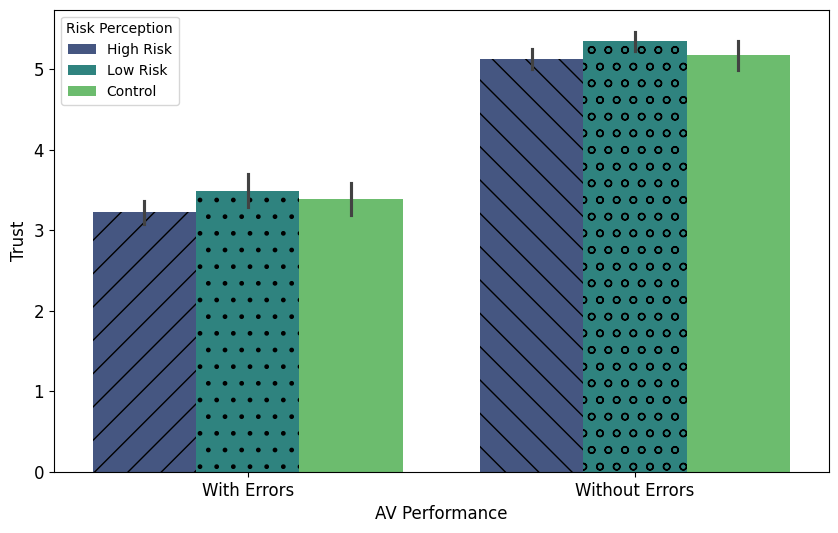

In [ ]:
plt.figure(figsize=(10, 6))
ax =sns.barplot(hue='Risk Perception', y='Trust', data=df,x="AV Performance", errorbar='se',palette='viridis')
#plt.title('Experienced Risk per Risk Perception Group and Performance')
plt.xlabel('AV Performance',fontsize=12)
plt.ylabel('Trust',fontsize=12)
# plt.show()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Get the bar objects from the plot
bars = ax.patches

# Define your hatch patterns (e.g., '/', '\\', '.', 'o', '*', '+', 'x')
patterns = ['/', '\\', '.','o']

# Assign hatch patterns to bars
for bar, pattern in zip(bars, patterns):
    bar.set_hatch(pattern)
plt.savefig("/content/drive/MyDrive/Emotion_Em/Results/Figures/other metrics/Trust.png", dpi=400)
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
df

Risk Perception  Automation Error  ID  Gender  Years Driving  \
0                  1                 1   1       1            4.0   
1                  1                 1   5       1            8.0   
2                  1                 1  13       1            6.0   
3                  1                 1  21       1           10.0   
4                  1                 1  24       2            3.0   
..               ...               ...  ..     ...            ...   
135                3                 2  48       1            6.0   
136                3                 2  54       2           10.0   
137                3                 2  60       2            3.0   
138                3                 2  66       1            2.0   
139                3                 2  72       1            4.0   

     Eagerness to Adopt New Technologies  Knowledge of Self-Driving Vehicles  \
0                                      6                                   5   
1                                      7                                   6   
2                                      6                                   5   
3                                      7                                   6   
4                                      7                                   5   
..                                   ...                                 ...   
135                                    7                                   5   
136                                    5                                   5   
137                                    5                                   2   
138                                    6                                   6   
139                                    6                                   5   

     Perceived Benefits of Using a Self-Driving Vehicle  Dispositional Trust  \
0                                                    5              2.666667   
1                                                    6              2.666667   
2                                                    4              2.000000   
3                                                    6              2.333333   
4                                                    4              2.000000   
..                                                 ...                   ...   
135                                                  7              3.000000   
136                                                  4              2.333333   
137                                                  3              2.000000   
138                                                  5              2.666667   
139                                                  6              2.666667   

     Risk Propensity  ...  SCR_Recovery  SCR_RecoveryTime  Heart Rate_cleaned  \
0              2.875  ...           1.0          0.234375           80.360147   
1              4.000  ...           1.0         57.773438           88.920512   
2              4.750  ...           1.0         20.025670           81.793017   
3              3.500  ...           1.0         10.799479          111.803548   
4              4.625  ...           1.0          0.296875           75.750115   
..               ...  ...           ...               ...                 ...   
135            4.375  ...           1.0         10.195312           84.255840   
136            1.750  ...           1.0          2.980469           79.689823   
137            4.750  ...           1.0          4.328125           93.933310   
138            4.000  ...           1.0          2.496094           77.742055   
139            5.750  ...           NaN               NaN           59.033987   

     Heart Rate_mean  Heart Rate_max  Heart Rate_min  Heart Rate_std  \
0          80.381872       84.547614       76.143207        2.900187   
1          88.942048       93.591896       84.132781        3.281232   
2          81.785996       85.019364       78.555822        2.254

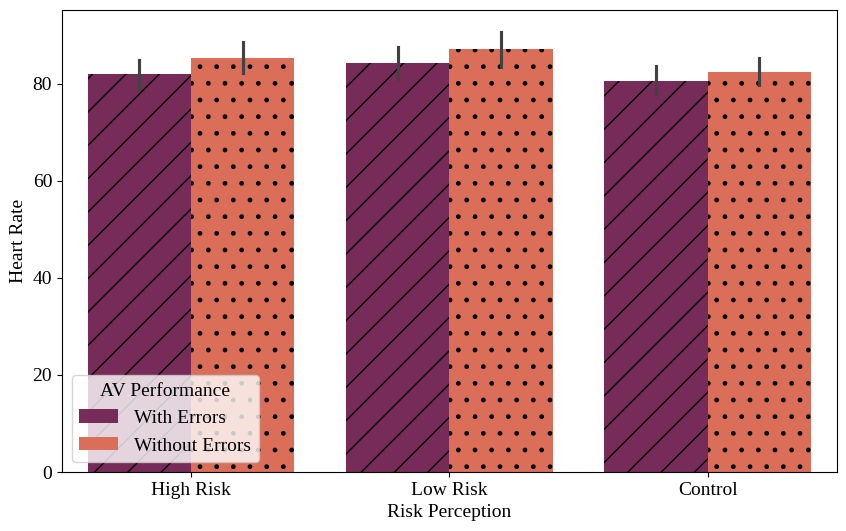

In [ ]:
plt.figure(figsize=(10, 6))
ax =sns.barplot(x='Risk Perception', y='Heart Rate_mean', data=df,hue="AV Performance", errorbar='se',palette='rocket')
#plt.title('Experienced Risk per Risk Perception Group and Performance')
plt.xlabel('Risk Perception',fontsize=14)
plt.ylabel('Heart Rate',fontsize=14)
# plt.show()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Get the bar objects from the plot
bars = ax.patches

# Define your hatch patterns (e.g., '/', '\\', '.', 'o', '*', '+', 'x')
patterns = ['/','/','/','.','.','.']#,'/','.','/', '.', '//']

# Assign hatch patterns to bars
for bar, pattern in zip(bars, patterns):
    bar.set_hatch(pattern)

plt.savefig("/content/drive/MyDrive/Emotion_Em/Results/Figures/other metrics/HR.png", dpi=400)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
ax =sns.barplot(x='Risk Perception', y='EDA_phasic_norm', data=df,hue="AV Performance", errorbar='se',palette='rocket')
#plt.title('Experienced Risk per Risk Perception Group and Performance')
plt.xlabel('Risk Perception',fontsize=14)
plt.ylabel('Heart Rate',fontsize=14)
# plt.show()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Get the bar objects from the plot
bars = ax.patches

# Define your hatch patterns (e.g., '/', '\\', '.', 'o', '*', '+', 'x')
patterns = ['/','/','/','.','.','.']#,'/','.','/', '.', '//']

# Assign hatch patterns to bars
for bar, pattern in zip(bars, patterns):
    bar.set_hatch(pattern)

#plt.savefig("/content/drive/MyDrive/Emotion_Em/Results/Figures/other metrics/HR.png", dpi=400)
plt.show()

NameError: name 'plt' is not defined